<h1>Data exploration</h1>

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
import pickle
import xgboost as xgb
import seaborn as sns
from seaborn import clustermap
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import scipy

Loading the train and test set.

In [11]:
train = pd.read_csv('../data/train.txt', sep='\t')
test = pd.read_csv('../data/test.txt', sep='\t')
print(train.shape, test.shape)
print(set(train.columns).difference(test.columns))

(334601, 152) (10842, 151)


In [14]:
test['oldTestset'] = True
test['sample_weight'] = 1.0
train['oldTestset'] = False

In [18]:
data = pd.concat([train, test])
data.shape

//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(345443, 153)

In [19]:
label_counts = data['label'].value_counts()
print('The dataset contains {} variants, of which {} ({}%) are benign and {} ({}%) are pathogenic, and has {} features.'
    .format(
        data.shape[0], 
        label_counts['Benign'], 
        round(label_counts['Benign']/data.shape[0]*100, 2), 
        label_counts['Pathogenic'], 
        round(label_counts['Pathogenic']/data.shape[0]*100, 2), 
        data.shape[1]
))


The dataset contains 345443 variants, of which 299341 (86.65%) are benign and 46102 (13.35%) are pathogenic, and has 153 features.


Not all features in the train set were used for training the model. Some features were only used for plotting afterwards. Load the CAPICE model to extract the used features.

In [4]:
model = pickle.load(open('../model/xgb_weightedSample_randomsearch.pickle.dat', 'rb'))
model_features = set(model.best_estimator_.get_booster().feature_names)
print(len(model_features))

131


//anaconda3/envs/py3_vp/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


The features used for the model are all from CADD 1.4. Categorical variables were converted to dummy variables, hence the large number of features. The used features should all be from CADD. Below I copied the features from CADD version 1.4 (https://cadd.gs.washington.edu/static/ReleaseNotes_CADD_v1.4.pdf) and checked the overlap etc. with the features in the train set.

In [6]:
#all_cadd_features contains all features from cadd, cadd_features only contains the features used for training.
all_cadd_features = set([ 'Chrom', 'Pos', 'Ref','Alt','Type','Length', 'Annotype', 'Consequence', 'ConsScore', 'ConsDetail', 'GC','CpG','motifECount', 'MotifEName', 'motifEHIPos','motifEScoreChng','oAA','nAA', 'GeneID', 'FeatureID', 'GeneName', 'CCDS', 'Intron', 'Exon', 'cDNApos','relcDNApos','CDSpos','relCDSpos','protPos','relProtPos','Domain','Dst2Splice','Dst2SplType','minDistTSS','minDistTSE','SIFTcat','SIFTval','PolyPhenCat','PolyPhenVal','priPhCons','mamPhCons','verPhCons','priPhyloP','mamPhyloP','verPhyloP','bStatistic','targetScan','mirSVR-Score','mirSVR-E','mirSVR-Aln','cHmmTssA','cHmmTssAFlnk','cHmmTxFlnk','cHmmTx','cHmmTxWk','cHmmEnhG','cHmmEnh','cHmmZnfRpts','cHmmHet','cHmmTssBiv','cHmmBivFlnk','cHmmEnhBiv','cHmmReprPC','cHmmReprPCWk','cHmmQuies','GerpRS','GerpRSpval','GerpN','GerpS','TFBS','TFBSPeaks','TFBSPeaksMax','tOverlapMotifs','motifDist','Segway','EncH3K27Ac','EncH3K4Me1','EncH3K4Me3','EncExp','EncNucleo','EncOCC','EncOCCombPVal','EncOCDNasePVal','EncOCFairePVal','EncOCpolIIPVal','EncOCctcfPVal','EncOCmycPVal','EncOCDNaseSig','EncOCFaireSig','EncOCpolIISig','EncOCctcfSig','EncOCmycSig','Grantham','Dist2Mutation','Freq100bp','Rare100bp','Sngl100bp','Freq1000bp','Rare1000bp','Sngl1000bp','Freq10000bp','Rare10000bp','Sngl10000bp','dbscSNV-ada_score','dbscSNV-rf_score','RawScore','PHRED'])
cadd_features = set(['Ref', 'Alt', 'Type', 'Length', 'Consequence', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'oAA', 'nAA', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Domain', 'Dst2Splice', 'Dst2SplType', 'minDistTSS', 'minDistTSE', 'SIFTcat', 'SIFTval', 'PolyPhenCat', 'PolyPhenVal', 'priPhCons', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'cHmmTssA', 'cHmmTssAFlnk', 'cHmmTxFlnk', 'cHmmTx', 'cHmmTxWk', 'cHmmEnhG', 'cHmmEnh', 'cHmmZnfRpts', 'cHmmHet', 'cHmmTssBiv', 'cHmmBivFlnk', 'cHmmEnhBiv', 'cHmmReprPC', 'cHmmReprPCWk', 'cHmmQuies', 'GerpRS', 'GerpRSpval', 'GerpN', 'GerpS', 'TFBS', 'TFBSPeaks', 'TFBSPeaksMax', 'tOverlapMotifs', 'motifDist', 'Segway', 'EncH3K27Ac', 'EncH3K4Me1', 'EncH3K4Me3', 'EncExp', 'EncNucleo', 'EncOCC', 'EncOCCombPVal', 'EncOCDNasePVal', 'EncOCFairePVal', 'EncOCpolIIPVal', 'EncOCctcfPVal', 'EncOCmycPVal', 'EncOCDNaseSig', 'EncOCFaireSig', 'EncOCpolIISig', 'EncOCctcfSig', 'EncOCmycSig', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score','dbscSNV-rf_score', 'RawScore', 'PHRED'])

#all_cadd_features = set(['Chrom', 'Pos', 'Ref','Anc', 'Alt','Type','Length','isTv','isDerived', 'AnnoType', 'Consequence','ConsScore', 'ConsDetail', 'GC','CpG','mapAbility20bp', 'mapAbility35bp', 'scoreSegDup', 'priPhCons','mamPhCons','verPhCons','priPhyloP','mamPhyloP','verPhyloP','GerpN','GerpS','GerpRS','GerpRSpval','bStatistic','EncExp','EncH3K27Ac','EncH3K4Me1','EncH3K4Me3','EncNucleo','EncOCC','EncOCCombPVal','EncOCDNasePVal','EncOCFairePVal','EncOCpolIIPVal','EncOCctcfPVal','EncOCmycPVal','EncOCDNaseSig','EncOCFaireSig','EncOCpolIISig','EncOCctcfSig', 'EncOCmycSig','Segway','tOverlapMotifs','motifDist','motifECount','motifEName','motifEHIPos','motifEScoreChng','TFBS','TFBSPeaks','TFBSPeaksMax','isKnownVariant','ESP_AF','ESP_AFR','ESP_EUR','TG_AF','TG_ASN','TG_AMR','TG_AFR','TG_EUR','minDistTSS','minDistTSE','GeneID','FeatureID','CCDS','GeneName','cDNApos','relcDNApos','CDSpos','relCDSpos','protPos','relProtPos','Dst2Splice','Dst2SplType','Exon','Intron','oAA','nAA','Grantham','PolyPhenCat','PolyPhenVal','SIFTcat','SIFTval'])
#cadd_features = set(['Ref', 'Alt', 'Type', 'Length', 'isTv','Consequence','GC','CpG','priPhCons','mamPhCons','verPhCons','priPhyloP','mamPhyloP','verPhyloP','GerpN','GerpS','GerpRS','GerpRSpval','bStatistic','EncExp','EncH3K27Ac','EncH3K4Me1','EncH3K4Me3','EncNucleo','EncOCC','EncOCCombPVal','EncOCDNasePVal','EncOCFairePVal','EncOCpolIIPVal','EncOCctcfPVal','EncOCmycPVal','EncOCDNaseSig','EncOCFaireSig','EncOCpolIISig','EncOCctcfSig', 'EncOCmycSig','Segway','tOverlapMotifs','motifDist','motifECount','motifEName','motifEHIPos','motifEScoreChng','TFBS','TFBSPeaks','TFBSPeaksMax','minDistTSS','minDistTSE','cDNApos','relcDNApos','CDSpos','relCDSpos','protPos','relProtPos','Dst2Splice','Dst2SplType','oAA','nAA','Grantham','PolyPhenCat','PolyPhenVal','SIFTcat','SIFTval'])
print('CADD 1.4 contains', len(all_cadd_features), 'features.', len(cadd_features), 'were used for training the CADD model.', len(all_cadd_features)-len(cadd_features), 'were not used.')
print('Features from CADD that were not used for CADD training:', list(all_cadd_features.difference(cadd_features)))
print('\n')

#Were all CADD features used for training CAPICE?
#check intersection cadd_features with model_features which are the numerical features. 
numerical_features_cadd = cadd_features.intersection(model_features)
print(len(numerical_features_cadd), 'features from CADD overlap with the features used for training CAPICE. That means there are', len(cadd_features)-len(numerical_features_cadd), 'left that should be the categorical variables converted to dummy variables.')
#12 variables left that should be the dummy vars.

print('\n')
vars_not_in_model = cadd_features.difference(numerical_features_cadd)
print('The', len(vars_not_in_model), 'features from CADD that are not in the model features:', list(vars_not_in_model), '\n')
print('Are these the features that were converted to dummy variables?')

print('\nThe features from the model that were not in CADD:')
model_vars_not_in_cadd = model_features.difference(cadd_features)
#get difference model_feat - cadd_feat
print(model_vars_not_in_cadd)

print('\nCleaned up (dummy variables summarized as the original feature):')
cleanedup = set(list(map(lambda x: x.split('_')[0], model_vars_not_in_cadd)))
print(cleanedup)

print('\n', len(vars_not_in_model.intersection(cleanedup)), 'variables from CADD that were converted to dummy variables in the model:')
categorical_features_cadd = vars_not_in_model.intersection(cleanedup)
print(categorical_features_cadd)

features_not_in_cadd = cleanedup.difference(vars_not_in_model)
print('\n', len(features_not_in_cadd), 'features from the model not in CADD:')
print(features_not_in_cadd)

print('\n')
all_features_model = list(numerical_features_cadd.union(categorical_features_cadd).union(features_not_in_cadd))
print('Summary:', len(all_features_model), 'features were used for training the CAPICE model. ')
print(len(numerical_features_cadd), 'numerical features from CADD,')
print(len(categorical_features_cadd), 'categorical features from CADD,')
print(len(features_not_in_cadd), 'features not from CADD.')
features_not_in_model = cadd_features.difference(all_features_model)
print(len(features_not_in_model), 'features from CADD not in model:')
print(features_not_in_model)

CADD 1.4 contains 107 features. 95 were used for training the CADD model. 12 were not used.
Features from CADD that were not used for CADD training: ['MotifEName', 'GeneName', 'Exon', 'GeneID', 'Chrom', 'ConsDetail', 'ConsScore', 'Pos', 'Annotype', 'Intron', 'FeatureID', 'CCDS']


82 features from CADD overlap with the features used for training CAPICE. That means there are 13 left that should be the categorical variables converted to dummy variables.


The 13 features from CADD that are not in the model features: ['PolyPhenCat', 'Domain', 'Dst2SplType', 'Ref', 'nAA', 'Type', 'PHRED', 'Consequence', 'Alt', 'oAA', 'SIFTcat', 'RawScore', 'Segway'] 

Are these the features that were converted to dummy variables?

The features from the model that were not in CADD:
{'Domain_UD', 'nAA_L', 'PolyPhenCat_unknown', 'oAA_unknown', 'Segway_R5', 'Ref_CT', 'PolyPhenCat_benign', 'SIFTcat_deleterious', 'Alt_G', 'oAA_P', 'Alt_C', 'nAA_S', 'Dst2SplType_DONOR', 'Domain_hmmpanther', 'Segway_GE0', 'Segway_

There are a lot of features in the data. What do they look like?

In [7]:
#some chromosome values are integers, some are strings. Convert everything to string for consistency. 
train['#Chrom'] = train['#Chrom'].apply(lambda x: str(x))

COLUMN 0 : #Chrom
Nr of values: 24
Type of column: object
2     40122
1     35027
17    24755
9     19984
14    17697
16    15910
11    15731
12    15263
5     14538
19    14398
X     14356
3     14216
4     12433
6     12169
7     12047
10    10221
15     9452
8      8650
13     7022
22     6250
18     6000
20     5888
21     2460
Y        12
Name: #Chrom, dtype: int64


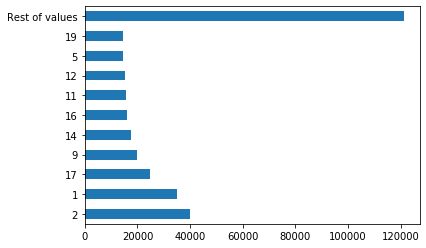




COLUMN 1 : Allergy/Immunology/Infectious
Nr of values: 2
Type of column: bool
False    308584
True      26017
Name: Allergy/Immunology/Infectious, dtype: int64


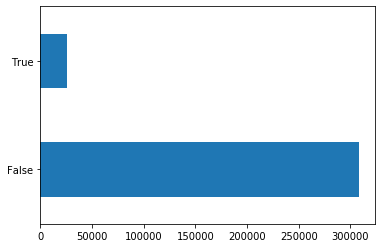




COLUMN 2 : Alt
Nr of values: 3051
Type of column: object
T                                                97772
A                                                95892
C                                                65289
G                                                64680
AA                                                 756
                                                 ...  
TCACAT                                               1
CTTCTT                                               1
CCAGGCCCAGGCC                                        1
CTGTTGTCTAGTTCATCCATGGCTGGTTGATCATGTCTTCACTGA        1
GCCCCTCGTGTTCATGGGAGCTCGTTTT                         1
Name: Alt, Length: 3051, dtype: int64


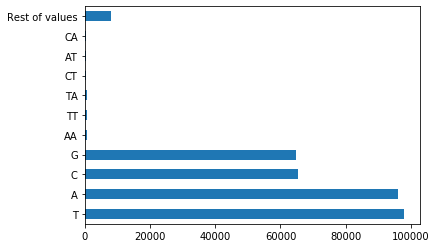




COLUMN 3 : AnnoType
Nr of values: 5
Type of column: object
CodingTranscript       231033
Transcript              69987
Intergenic              25628
RegulatoryFeature        6658
NonCodingTranscript      1295
Name: AnnoType, dtype: int64


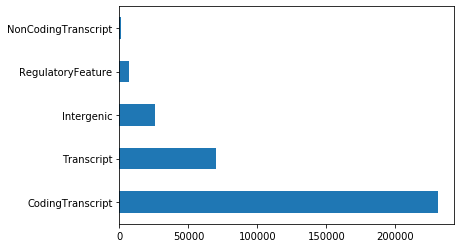




COLUMN 4 : Audiologic/Otolaryngologic
Nr of values: 2
Type of column: bool
False    310514
True      24087
Name: Audiologic/Otolaryngologic, dtype: int64


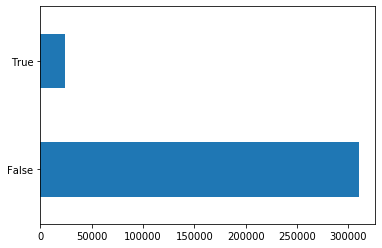




COLUMN 5 : Biochemical
Nr of values: 2
Type of column: bool
False    318153
True      16448
Name: Biochemical, dtype: int64


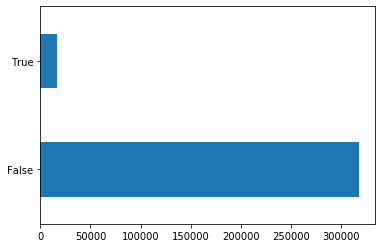




COLUMN 6 : CCDS
Nr of values: 8192
Type of column: object
CCDS59435.1    13653
CCDS9761.2      6576
CCDS48036.1     3237
CCDS9344.1      2938
CCDS41446.1     2291
               ...  
CCDS7283.1         1
CCDS6064.1         1
CCDS56057.1        1
CCDS2955.1         1
CCDS44687.1        1
Name: CCDS, Length: 8192, dtype: int64


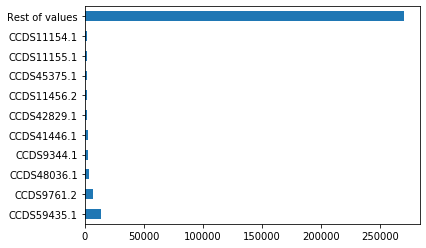




COLUMN 7 : CDSpos
Nr of values: 26047
Type of column: float64
33.0       135
114.0      130
330.0      124
171.0      123
543.0      122
          ... 
59348.0      1
38945.0      1
7642.0       1
47658.0      1
65531.0      1
Name: CDSpos, Length: 26047, dtype: int64


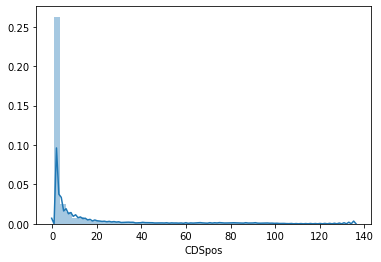




COLUMN 8 : Cardiovascular
Nr of values: 2
Type of column: bool
False    266008
True      68593
Name: Cardiovascular, dtype: int64


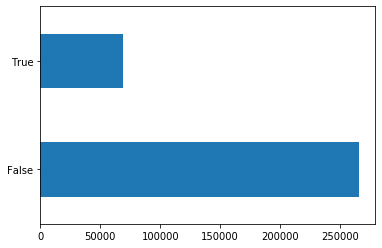




COLUMN 9 : ConsDetail
Nr of values: 94
Type of column: object
missense                                  123722
synonymous                                 67555
intron                                     42935
frameshift                                 16550
downstream                                 16284
                                           ...  
splice,inframe_deletion,stop_gained            1
splice,stop_retained,inframe_insertion         1
intron,non_coding_exon,splice_acceptor         1
frameshift,NMD,stop_gained                     1
frameshift,NMD,start_lost                      1
Name: ConsDetail, Length: 94, dtype: int64


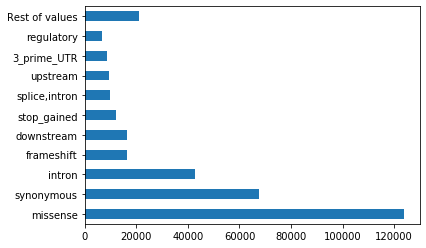




COLUMN 10 : ConsScore
Nr of values: 9
Type of column: float64
7.0    145445
5.0     80636
2.0     52862
1.0     25619
8.0     12788
6.0      9212
4.0      6657
3.0      1372
0.0         9
Name: ConsScore, dtype: int64


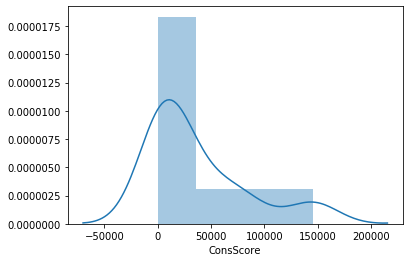




COLUMN 11 : Consequence
Nr of values: 17
Type of column: object
NON_SYNONYMOUS      128064
SYNONYMOUS           67625
INTRONIC             44145
FRAME_SHIFT          17306
DOWNSTREAM           16284
STOP_GAINED          12788
SPLICE_SITE          11730
UPSTREAM              9335
3PRIME_UTR            8717
REGULATORY            6657
CANONICAL_SPLICE      5813
INFRAME               3399
5PRIME_UTR            1372
NONCODING_CHANGE      1278
STOP_LOST               75
INTERGENIC               9
UNKNOWN                  3
Name: Consequence, dtype: int64


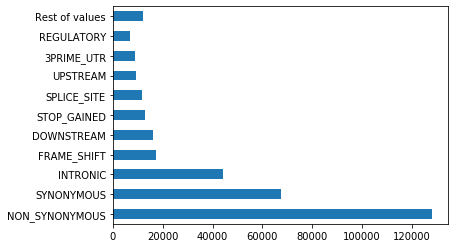




COLUMN 12 : CpG
Nr of values: 889
Type of column: float64
0.013333    51308
0.026667    48064
0.000000    38413
0.040000    37746
0.053333    29780
            ...  
0.254777        1
0.393443        1
0.248521        1
0.268293        1
0.109890        1
Name: CpG, Length: 889, dtype: int64


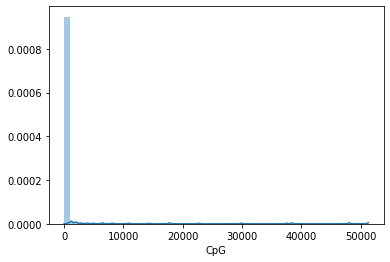




COLUMN 13 : Craniofacial
Nr of values: 2
Type of column: bool
False    286034
True      48567
Name: Craniofacial, dtype: int64


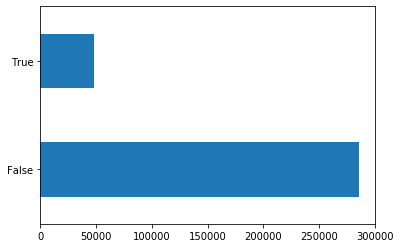




COLUMN 14 : Dental
Nr of values: 2
Type of column: bool
False    324484
True      10117
Name: Dental, dtype: int64


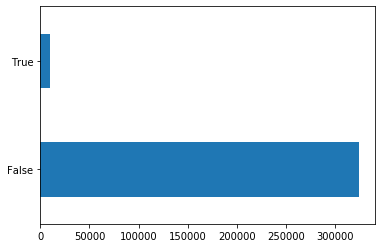




COLUMN 15 : Dermatologic
Nr of values: 2
Type of column: bool
False    290272
True      44329
Name: Dermatologic, dtype: int64


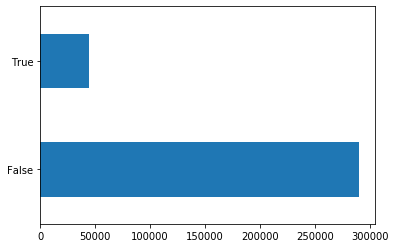




COLUMN 16 : Dist2Mutation
Nr of values: 534
Type of column: float64
15.0       7756
12.0       7706
9.0        7615
17.0       7471
14.0       7461
           ... 
646.0         1
59068.0       1
522.0         1
301.0         1
1161.0        1
Name: Dist2Mutation, Length: 534, dtype: int64


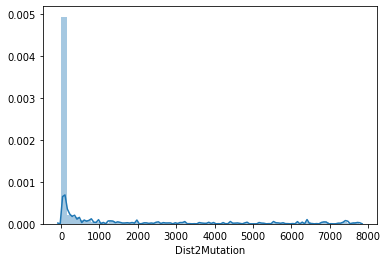




COLUMN 17 : Domain
Nr of values: 6
Type of column: object
ndomain       141779
hmmpanther     50405
lcompl         20929
ncoils         11060
sigp            1180
other            118
Name: Domain, dtype: int64


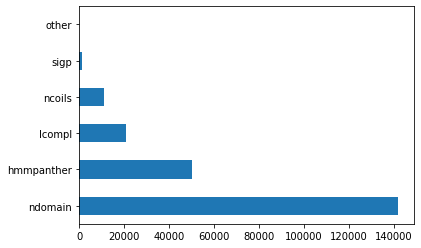




COLUMN 18 : Dst2SplType
Nr of values: 2
Type of column: object
ACCEPTOR    42758
DONOR       41307
Name: Dst2SplType, dtype: int64


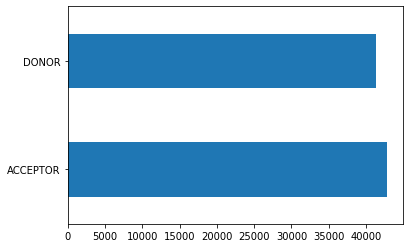




COLUMN 19 : Dst2Splice
Nr of values: 40
Type of column: float64
-1.0     3777
 1.0     2772
 13.0    2533
 6.0     2497
 19.0    2496
 12.0    2496
 10.0    2492
 3.0     2484
 18.0    2473
 16.0    2468
 7.0     2398
 15.0    2377
 17.0    2363
 14.0    2357
 9.0     2341
 8.0     2335
 11.0    2305
 20.0    2291
 4.0     2276
 5.0     2198
 2.0     2181
-2.0     2113
-9.0     2060
-10.0    2019
-8.0     1975
-7.0     1921
-5.0     1669
-14.0    1660
-18.0    1658
-15.0    1644
-4.0     1642
-11.0    1629
-13.0    1628
-16.0    1626
-12.0    1587
-6.0     1556
-17.0    1516
-20.0    1503
-19.0    1490
-3.0     1259
Name: Dst2Splice, dtype: int64


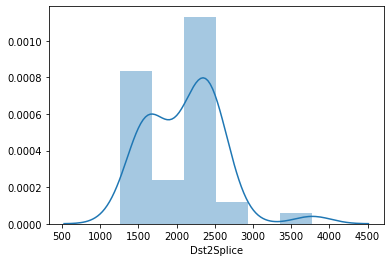




COLUMN 20 : EncExp
Nr of values: 26891
Type of column: float64
0.841077       2945
1.682150       2184
0.444104       2047
2.523230       1816
0.888208       1642
               ... 
6700.740000       1
7128.970000       1
3070.090000       1
4679.750000       1
1314.660000       1
Name: EncExp, Length: 26891, dtype: int64


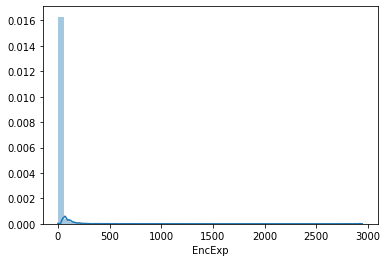




COLUMN 21 : EncH3K27Ac
Nr of values: 4313
Type of column: float64
3.00      34866
2.00      34111
4.00      25193
1.00      17224
5.00      15667
          ...  
282.56        1
107.96        1
162.52        1
115.08        1
181.24        1
Name: EncH3K27Ac, Length: 4313, dtype: int64


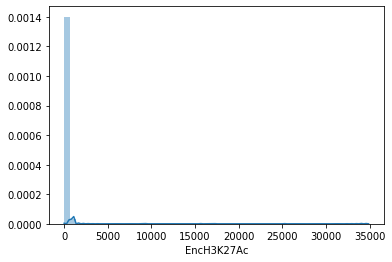




COLUMN 22 : EncH3K4Me1
Nr of values: 1895
Type of column: float64
2.00     43672
3.00     33545
1.00     23238
4.00     19565
5.00     10589
         ...  
66.64        1
73.60        1
96.68        1
67.68        1
62.24        1
Name: EncH3K4Me1, Length: 1895, dtype: int64


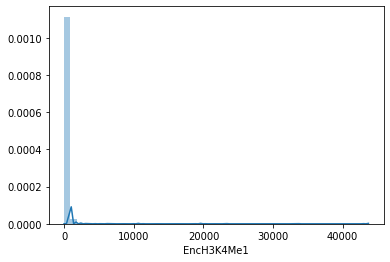




COLUMN 23 : EncH3K4Me3
Nr of values: 6120
Type of column: float64
2.00      56002
3.00      48944
4.00      26220
1.00      21043
5.00      11413
          ...  
170.48        1
170.52        1
223.92        1
110.16        1
428.88        1
Name: EncH3K4Me3, Length: 6120, dtype: int64


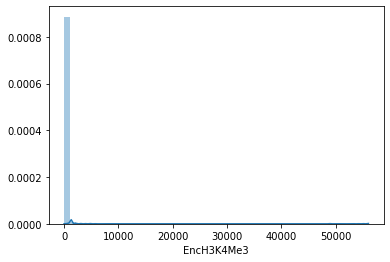




COLUMN 24 : EncNucleo
Nr of values: 139
Type of column: float64
1.2     15303
1.0     15251
1.1     15164
0.9     14990
1.3     14706
        ...  
17.8        1
22.4        1
9.5         1
11.1        1
16.9        1
Name: EncNucleo, Length: 139, dtype: int64


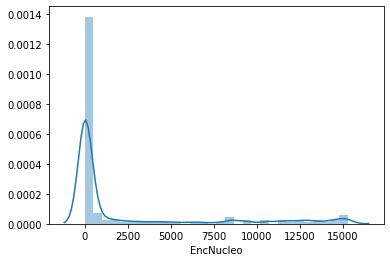




COLUMN 25 : EncOCC
Nr of values: 4
Type of column: float64
2.0    87577
3.0    14808
1.0    12516
4.0     6733
Name: EncOCC, dtype: int64


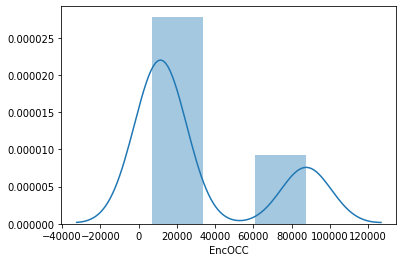




COLUMN 26 : EncOCCombPVal
Nr of values: 1378
Type of column: float64
16.00    14398
14.42     2879
15.18     2627
15.48     1489
0.00      1411
         ...  
10.72        1
11.75        1
7.57         1
14.12        1
14.14        1
Name: EncOCCombPVal, Length: 1378, dtype: int64


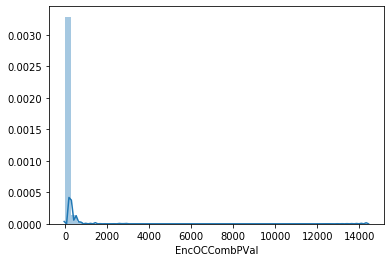




COLUMN 27 : EncOCDNasePVal
Nr of values: 991
Type of column: float64
16.00    22778
0.00     11554
2.98       800
11.80      773
1.93       592
         ...  
7.25         1
9.34         1
6.01         1
0.52         1
5.99         1
Name: EncOCDNasePVal, Length: 991, dtype: int64


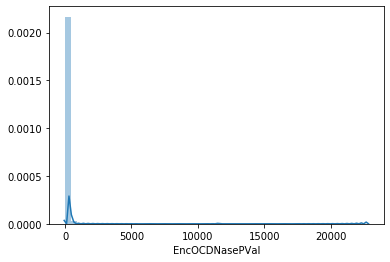




COLUMN 28 : EncOCDNaseSig
Nr of values: 4597
Type of column: float64
0.6610    2145
0.4070     625
1.6873     576
0.3814     517
0.6858     485
          ... 
0.1853       1
0.3306       1
0.1120       1
0.1513       1
0.3088       1
Name: EncOCDNaseSig, Length: 4597, dtype: int64


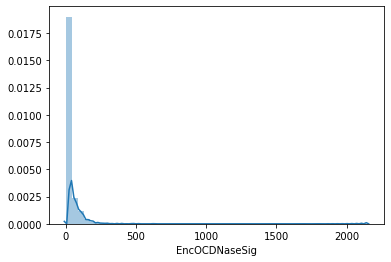




COLUMN 29 : EncOCFairePVal
Nr of values: 831
Type of column: float64
0.00    39408
1.63     2577
0.83     1309
0.78     1181
0.74      863
        ...  
9.57        1
8.35        1
7.59        1
8.73        1
7.79        1
Name: EncOCFairePVal, Length: 831, dtype: int64


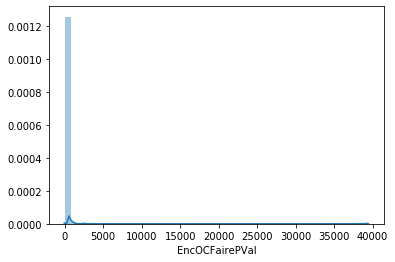




COLUMN 30 : EncOCFaireSig
Nr of values: 688
Type of column: float64
0.0180    2584
0.0113    1442
0.0093    1353
0.0117    1338
0.0095    1159
          ... 
0.0568       1
0.0767       1
0.0751       1
0.0622       1
0.0694       1
Name: EncOCFaireSig, Length: 688, dtype: int64


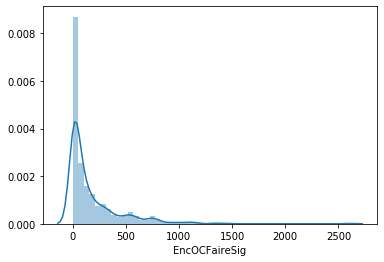




COLUMN 31 : EncOCctcfPVal
Nr of values: 866
Type of column: float64
0.00     56320
16.00    10996
11.00     2184
1.88       827
1.95       727
         ...  
8.06         1
6.49         1
5.66         1
6.54         1
7.67         1
Name: EncOCctcfPVal, Length: 866, dtype: int64


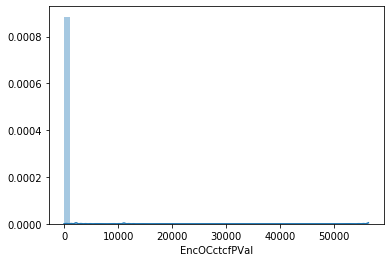




COLUMN 32 : EncOCctcfSig
Nr of values: 5440
Type of column: float64
0.0000    4753
1.8090    2145
0.1899     777
1.3494     576
0.0515     503
          ... 
0.8393       1
1.0186       1
0.8087       1
0.6696       1
4.7445       1
Name: EncOCctcfSig, Length: 5440, dtype: int64


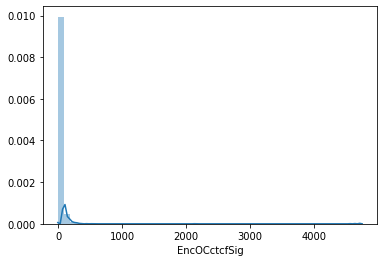




COLUMN 33 : EncOCmycPVal
Nr of values: 787
Type of column: float64
0.00     66884
2.23      2254
3.09      1179
16.00     1027
2.00       659
         ...  
9.00         1
7.67         1
5.06         1
8.02         1
8.91         1
Name: EncOCmycPVal, Length: 787, dtype: int64


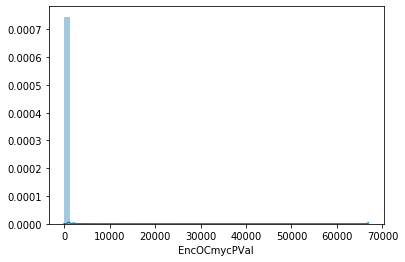




COLUMN 34 : EncOCmycSig
Nr of values: 2427
Type of column: float64
0.0000    29922
0.1351     2138
0.2063     1133
0.0856      518
0.0782      492
          ...  
0.2890        1
0.2096        1
0.1847        1
0.1705        1
0.4320        1
Name: EncOCmycSig, Length: 2427, dtype: int64


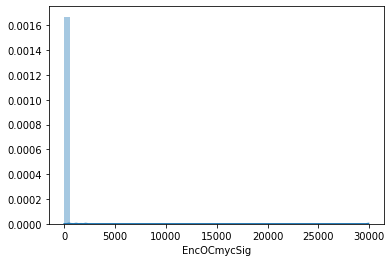




COLUMN 35 : EncOCpolIIPVal
Nr of values: 908
Type of column: float64
0.00     56841
16.00     8318
6.33      2241
2.71       605
5.85       588
         ...  
9.96         1
8.06         1
7.28         1
8.12         1
4.45         1
Name: EncOCpolIIPVal, Length: 908, dtype: int64


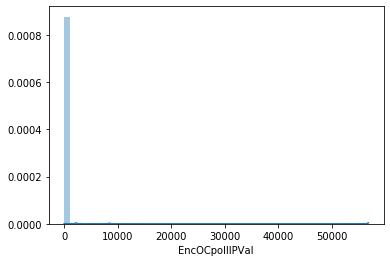




COLUMN 36 : EncOCpolIISig
Nr of values: 3200
Type of column: float64
0.0000    32612
0.1161     2147
0.1154      587
0.0816      513
0.0509      487
          ...  
0.6695        1
0.2772        1
0.2657        1
0.1428        1
0.0858        1
Name: EncOCpolIISig, Length: 3200, dtype: int64


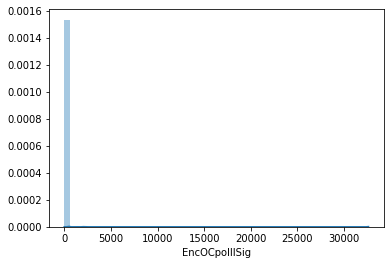




COLUMN 37 : Endocrine
Nr of values: 2
Type of column: bool
False    313759
True      20842
Name: Endocrine, dtype: int64


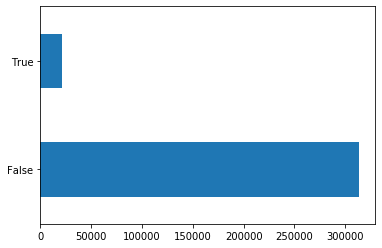




COLUMN 38 : Exon
Nr of values: 4433
Type of column: object
2/2        5020
4/4        3508
3/3        3423
1/1        3109
326/363    2776
           ... 
50/90         1
9/93          1
104/363       1
16/118        1
80/89         1
Name: Exon, Length: 4433, dtype: int64


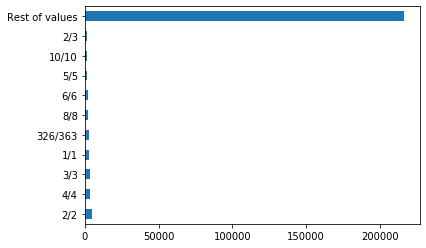




COLUMN 39 : FeatureID
Nr of values: 11990
Type of column: object
ENST00000589042    13653
ENST00000358025     6576
ENST00000372739     3237
ENST00000544455     2938
ENST00000367478     2291
                   ...  
ENST00000365389        1
ENST00000293831        1
ENSR00000260418        1
ENSR00000183843        1
ENSR00000263066        1
Name: FeatureID, Length: 11990, dtype: int64


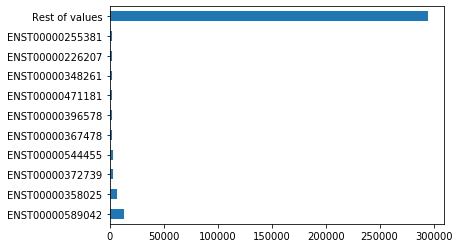




COLUMN 40 : Freq10000bp
Nr of values: 195
Type of column: float64
11.0     13124
13.0     12966
14.0     12771
8.0      12638
12.0     12574
         ...  
564.0        1
424.0        1
558.0        1
612.0        1
138.0        1
Name: Freq10000bp, Length: 195, dtype: int64


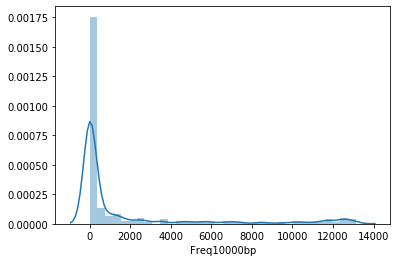




COLUMN 41 : Freq1000bp
Nr of values: 75
Type of column: float64
0.0     88685
1.0     88459
2.0     63143
3.0     38627
4.0     23012
        ...  
46.0        1
97.0        1
54.0        1
78.0        1
93.0        1
Name: Freq1000bp, Length: 75, dtype: int64


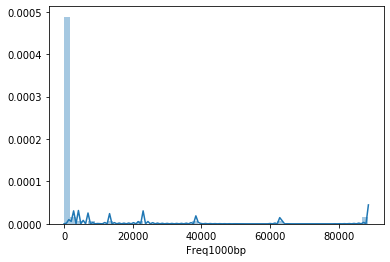




COLUMN 42 : Freq100bp
Nr of values: 23
Type of column: float64
0.0     274456
1.0      47851
2.0       7063
3.0       1004
4.0        231
5.0         40
10.0        37
9.0         32
6.0         22
8.0         22
7.0         13
11.0         9
15.0         9
12.0         7
13.0         6
16.0         6
19.0         3
25.0         3
18.0         2
14.0         2
22.0         2
26.0         1
23.0         1
Name: Freq100bp, dtype: int64


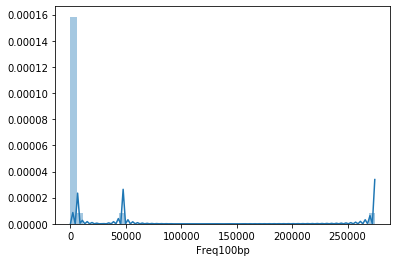




COLUMN 43 : GC
Nr of values: 2083
Type of column: float64
0.423841    5999
0.430464    5847
0.410596    5813
0.437086    5781
0.417219    5750
            ... 
0.443787       1
0.808743       1
0.478261       1
0.612500       1
0.670213       1
Name: GC, Length: 2083, dtype: int64


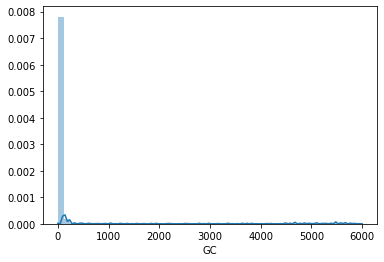




COLUMN 44 : Gastrointestinal
Nr of values: 2
Type of column: bool
False    307381
True      27220
Name: Gastrointestinal, dtype: int64


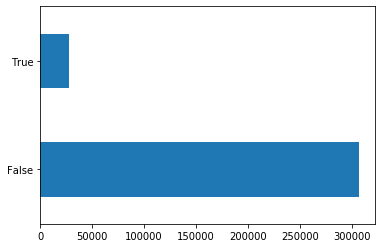




COLUMN 45 : GeneID
Nr of values: 9882
Type of column: object
ENSG00000155657    13653
ENSG00000054654     6576
ENSG00000197694     3237
ENSG00000139618     2938
ENSG00000047410     2291
                   ...  
ENSG00000145700        1
ENSG00000129946        1
ENSG00000258759        1
ENSG00000084710        1
ENSG00000266978        1
Name: GeneID, Length: 9882, dtype: int64


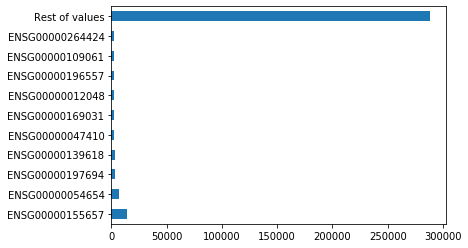




COLUMN 46 : GeneName
Nr of values: 9620
Type of column: object
MIR548N     10289
MIR548AZ     8781
MIR1268A     7648
MYHAS        6946
TTN          4575
            ...  
LENG8           1
FKBP11          1
VAV2            1
SCARA5          1
KCNN1           1
Name: GeneName, Length: 9620, dtype: int64


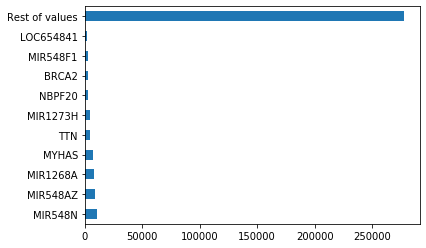




COLUMN 47 : General
Nr of values: 2
Type of column: bool
False    334203
True        398
Name: General, dtype: int64


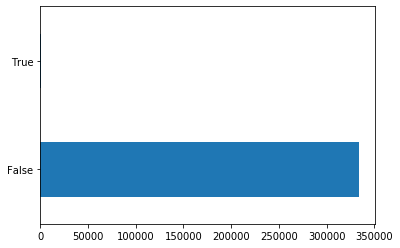




COLUMN 48 : Genitourinary
Nr of values: 2
Type of column: bool
False    319922
True      14679
Name: Genitourinary, dtype: int64


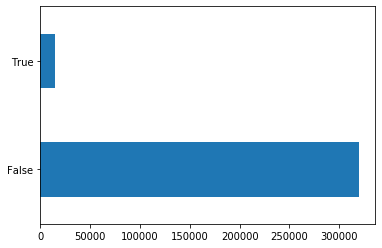




COLUMN 49 : GerpN
Nr of values: 1146
Type of column: float64
6.170    3035
5.650    2679
5.870    2582
5.740    2413
5.600    2407
         ... 
0.708       1
0.387       1
0.567       1
0.799       1
0.877       1
Name: GerpN, Length: 1146, dtype: int64


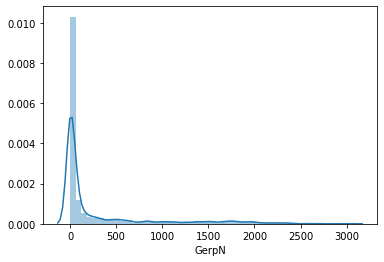




COLUMN 50 : GerpRS
Nr of values: 15205
Type of column: float64
3134.0    614
3477.7    597
1917.4    563
2677.3    470
2232.3    446
         ... 
6522.2      1
1013.2      1
1729.9      1
860.2       1
662.6       1
Name: GerpRS, Length: 15205, dtype: int64


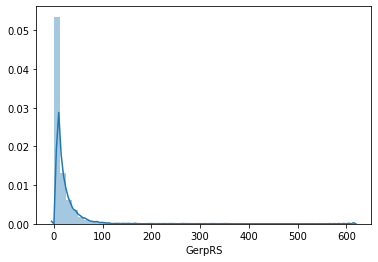




COLUMN 51 : GerpRSpval
Nr of values: 42156
Type of column: float64
0.000000e+00     42951
2.146100e-131      563
1.163960e-156      446
2.676060e-103      445
3.097140e-78       379
                 ...  
3.186290e-27         1
1.761530e-183        1
1.235350e-71         1
8.108510e-178        1
1.656330e-37         1
Name: GerpRSpval, Length: 42156, dtype: int64


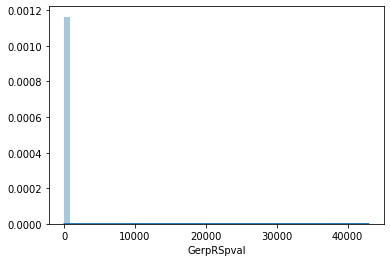




COLUMN 52 : GerpS
Nr of values: 5120
Type of column: float64
 0.00000    1426
 6.17000    1193
 5.87000    1095
 5.65000    1047
 5.74000    1003
            ... 
 0.00201       1
 0.02020       1
-0.01960       1
-0.04280       1
-0.00873       1
Name: GerpS, Length: 5120, dtype: int64


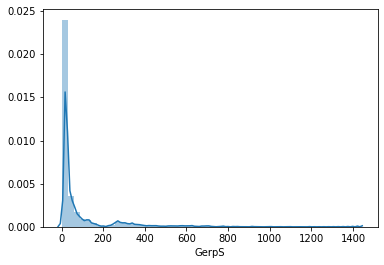




COLUMN 53 : Grantham
Nr of values: 81
Type of column: float64
29.0     10728
56.0      7297
58.0      7127
98.0      6736
64.0      4851
         ...  
59.0         1
153.0        1
195.0        1
158.0        1
124.0        1
Name: Grantham, Length: 81, dtype: int64


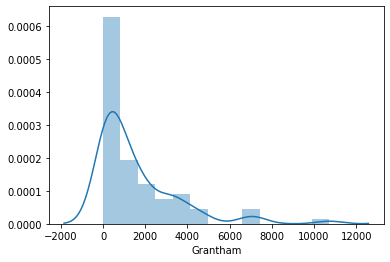




COLUMN 54 : Hematologic
Nr of values: 2
Type of column: bool
False    309902
True      24699
Name: Hematologic, dtype: int64


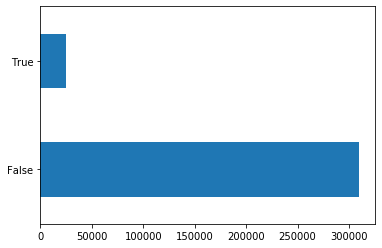




COLUMN 55 : Intron
Nr of values: 3482
Type of column: object
2/3        473
8/8        436
10/10      299
1/1        292
3/3        287
          ... 
19/83        1
74/145       1
81/105       1
96/96        1
273/362      1
Name: Intron, Length: 3482, dtype: int64


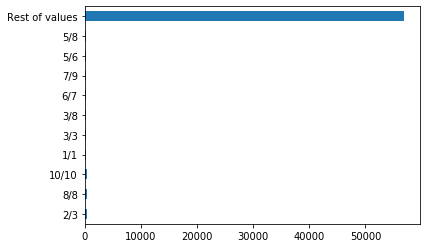




COLUMN 56 : Length
Nr of values: 106
Type of column: float64
0.0      299355
1.0       16685
2.0        5678
3.0        3246
4.0        2696
          ...  
104.0         1
148.0         1
83.0          1
99.0          1
89.0          1
Name: Length, Length: 106, dtype: int64


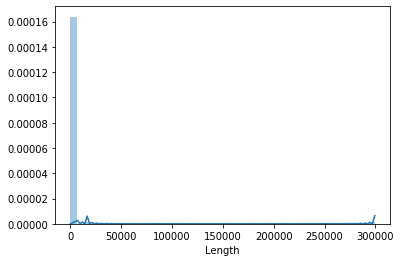




COLUMN 57 : Musculoskeletal
Nr of values: 2
Type of column: bool
False    251978
True      82623
Name: Musculoskeletal, dtype: int64


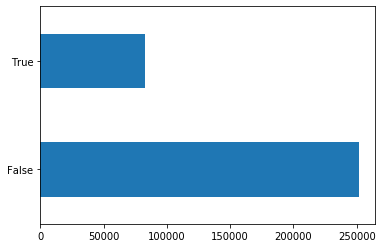




COLUMN 58 : Neurologic
Nr of values: 2
Type of column: bool
False    225722
True     108879
Name: Neurologic, dtype: int64


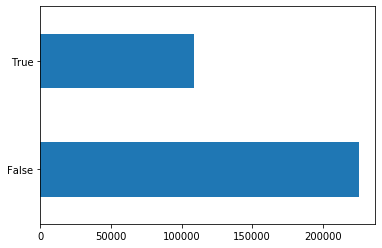




COLUMN 59 : Obstetric
Nr of values: 2
Type of column: bool
False    330998
True       3603
Name: Obstetric, dtype: int64


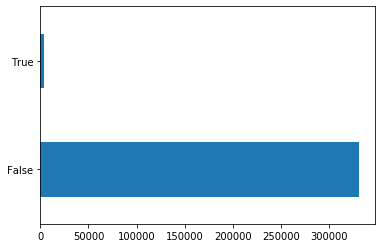




COLUMN 60 : Oncologic
Nr of values: 2
Type of column: bool
False    294367
True      40234
Name: Oncologic, dtype: int64


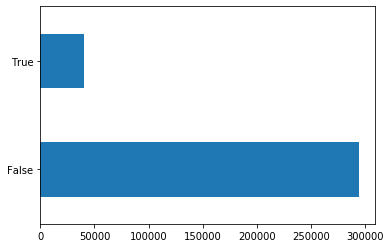




COLUMN 61 : Ophthalmologic
Nr of values: 2
Type of column: bool
False    283737
True      50864
Name: Ophthalmologic, dtype: int64


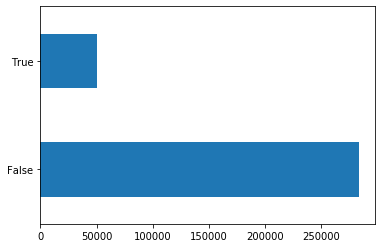




COLUMN 62 : PHRED
Nr of values: 11146
Type of column: float64
35.000    7066
34.000    6321
33.000    5046
32.000    4504
31.000    2508
          ... 
6.695        1
82.000       1
6.751        1
6.858        1
5.028        1
Name: PHRED, Length: 11146, dtype: int64


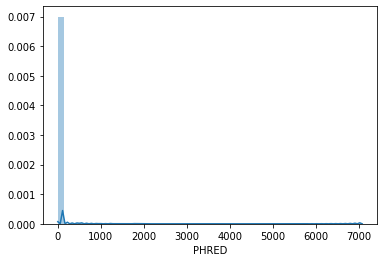




COLUMN 63 : PolyPhenCat
Nr of values: 4
Type of column: object
benign               62947
probably_damaging    37942
possibly_damaging    19685
unknown                183
Name: PolyPhenCat, dtype: int64


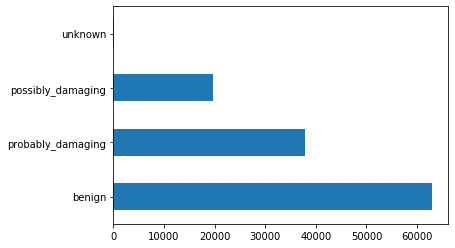




COLUMN 64 : PolyPhenVal
Nr of values: 988
Type of column: float64
0.000    11472
1.000     6705
0.999     5023
0.003     4229
0.001     3396
         ...  
0.363       14
0.555       13
0.337       12
0.485       10
0.538        9
Name: PolyPhenVal, Length: 988, dtype: int64


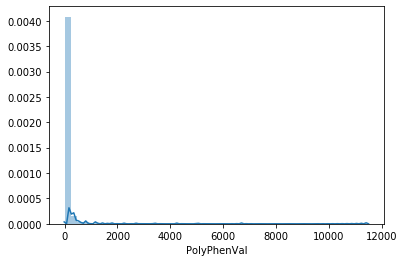




COLUMN 65 : Pos
Nr of values: 317718
Type of column: int64
35083508     17
38627152     14
47641559     12
35083509     12
92537353     11
             ..
133237641     1
47780746      1
11082635      1
165749644     1
57147392      1
Name: Pos, Length: 317718, dtype: int64


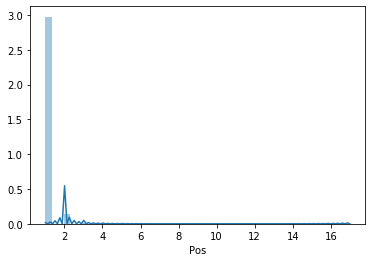




COLUMN 66 : Pulmonary
Nr of values: 2
Type of column: bool
False    324241
True      10360
Name: Pulmonary, dtype: int64


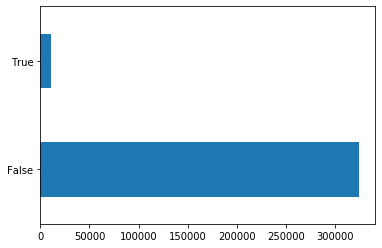




COLUMN 67 : Rare10000bp
Nr of values: 244
Type of column: float64
63.0     7948
56.0     7876
62.0     7715
60.0     7706
55.0     7702
         ... 
280.0       1
213.0       1
195.0       1
277.0       1
270.0       1
Name: Rare10000bp, Length: 244, dtype: int64


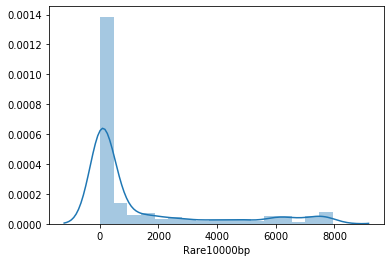




COLUMN 68 : Rare1000bp
Nr of values: 57
Type of column: float64
5.0     44652
4.0     43233
6.0     40905
3.0     36258
7.0     34452
8.0     26450
2.0     23725
9.0     20870
10.0    15278
1.0     11836
11.0    10295
12.0     6688
13.0     4568
14.0     3176
0.0      2774
15.0     2117
16.0     1468
17.0     1199
18.0      848
19.0      587
20.0      521
21.0      314
22.0      240
34.0      235
23.0      173
24.0      167
25.0      151
33.0      141
26.0       97
27.0       88
29.0       54
30.0       40
28.0       39
31.0       24
32.0       18
53.0       11
35.0        7
41.0        4
38.0        3
71.0        2
55.0        2
36.0        2
65.0        1
74.0        1
40.0        1
44.0        1
61.0        1
70.0        1
54.0        1
72.0        1
73.0        1
37.0        1
52.0        1
39.0        1
79.0        1
64.0        1
45.0        1
Name: Rare1000bp, dtype: int64


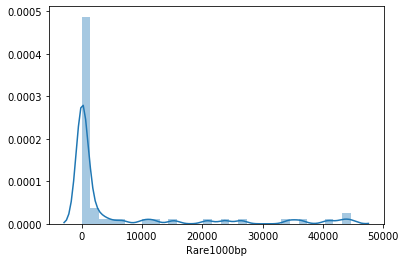




COLUMN 69 : Rare100bp
Nr of values: 18
Type of column: float64
0.0     180409
1.0     102616
2.0      34486
3.0       9769
4.0       2340
5.0        642
6.0        234
7.0        153
10.0        79
8.0         31
12.0        29
9.0         15
11.0        10
16.0         3
22.0         2
13.0         2
18.0         1
14.0         1
Name: Rare100bp, dtype: int64


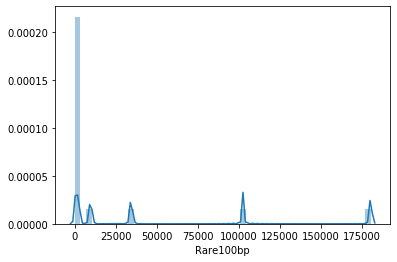




COLUMN 70 : RawScore
Nr of values: 323421
Type of column: float64
-0.223569    4
 0.134475    4
-0.033552    4
 0.186573    4
-0.243369    4
            ..
 2.069892    1
 4.460790    1
 2.128596    1
 4.651169    1
 1.850239    1
Name: RawScore, Length: 323421, dtype: int64


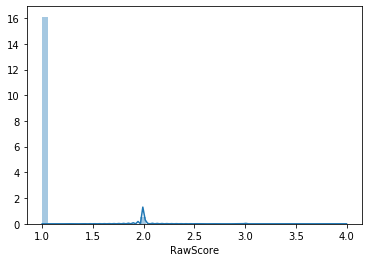




COLUMN 71 : Ref
Nr of values: 5121
Type of column: object
C                      102111
G                      100527
A                       53783
T                       52980
CT                       1226
                        ...  
GCTGCTGCTGCTGCTG            1
ATTCAGAGGATATTC             1
GGCAGCAGCA                  1
CCTCTTCTTCCTCTTCCTC         1
CACTTTCCACTTGG              1
Name: Ref, Length: 5121, dtype: int64


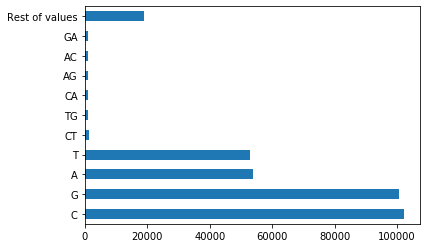




COLUMN 72 : Renal
Nr of values: 2
Type of column: bool
False    304446
True      30155
Name: Renal, dtype: int64


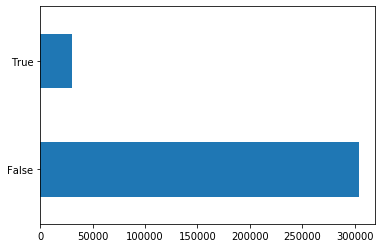




COLUMN 73 : SIFTcat
Nr of values: 2
Type of column: object
deleterious    59934
tolerated      59212
Name: SIFTcat, dtype: int64


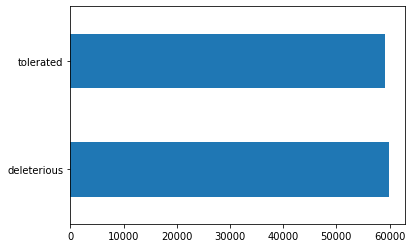




COLUMN 74 : SIFTval
Nr of values: 101
Type of column: float64
0.00    33008
0.01    10507
0.02     6353
0.03     4687
1.00     4640
        ...  
0.93       86
0.97       83
0.95       82
0.98       80
0.99       76
Name: SIFTval, Length: 101, dtype: int64


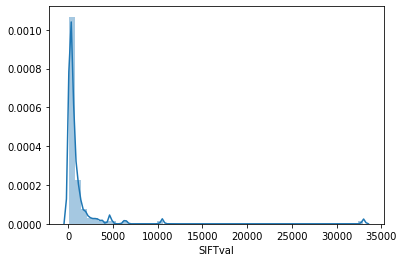




COLUMN 75 : Segway
Nr of values: 25
Type of column: object
TF2        35783
TF0        33408
GE0        31848
R5         27077
GE1        26598
GE2        23682
L1         13704
R1         13120
TF1        12343
R0         11400
L0         10820
R3         10790
F0         10196
F1         10094
GM1         9733
TSS         9481
R2          9023
D           8174
GS          7365
GM0         3728
R4          3678
H3K9me1     3275
E/GM        3035
C1          2764
C0          1518
Name: Segway, dtype: int64


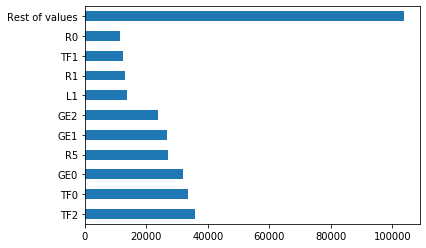




COLUMN 76 : Sngl10000bp
Nr of values: 1480
Type of column: float64
538.0     2347
556.0     2191
558.0     2163
557.0     2159
550.0     2147
          ... 
1424.0       1
1518.0       1
96.0         1
1278.0       1
1137.0       1
Name: Sngl10000bp, Length: 1480, dtype: int64


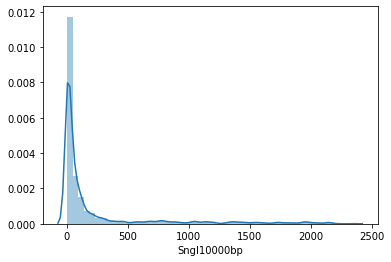




COLUMN 77 : Sngl1000bp
Nr of values: 240
Type of column: float64
54.0     10270
56.0     10269
55.0     10207
57.0     10135
53.0      9881
         ...  
230.0        1
213.0        1
223.0        1
226.0        1
205.0        1
Name: Sngl1000bp, Length: 240, dtype: int64


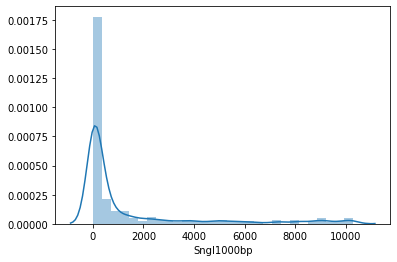




COLUMN 78 : Sngl100bp
Nr of values: 71
Type of column: float64
5.0     42164
6.0     41085
4.0     39459
7.0     36519
3.0     30946
        ...  
42.0        2
46.0        1
44.0        1
38.0        1
50.0        1
Name: Sngl100bp, Length: 71, dtype: int64


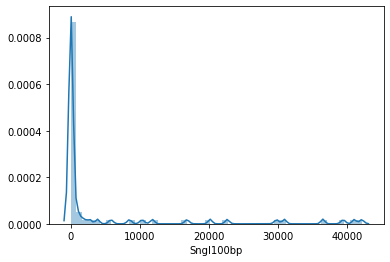




COLUMN 79 : Stars
Nr of values: 4
Type of column: float64
1.0    92747
2.0    20439
3.0     4120
4.0       19
Name: Stars, dtype: int64


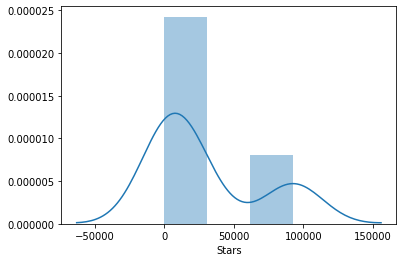




COLUMN 80 : TFBS
Nr of values: 109
Type of column: float64
1.0      25368
2.0      11843
3.0       5528
4.0       3448
5.0       2292
         ...  
112.0        2
105.0        2
109.0        2
106.0        1
118.0        1
Name: TFBS, Length: 109, dtype: int64


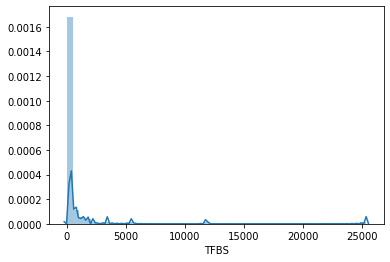




COLUMN 81 : TFBSPeaks
Nr of values: 223
Type of column: float64
1.0      21815
2.0       9811
3.0       5614
4.0       4070
5.0       3041
         ...  
215.0        1
224.0        1
246.0        1
209.0        1
218.0        1
Name: TFBSPeaks, Length: 223, dtype: int64


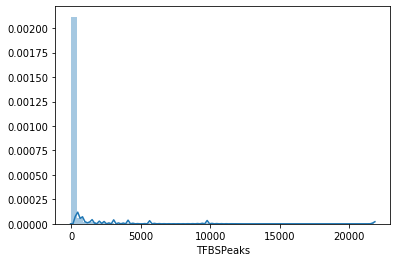




COLUMN 82 : TFBSPeaksMax
Nr of values: 15489
Type of column: float64
574.6504    382
56.5523     204
24.1861     189
27.0111     164
123.8453    163
           ... 
99.9722       1
28.3745       1
42.8259       1
35.0620       1
42.2231       1
Name: TFBSPeaksMax, Length: 15489, dtype: int64


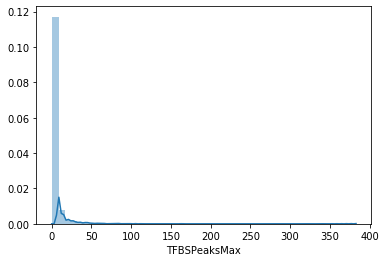




COLUMN 83 : Type
Nr of values: 3
Type of column: object
SNV    299787
DEL     24599
INS     10215
Name: Type, dtype: int64


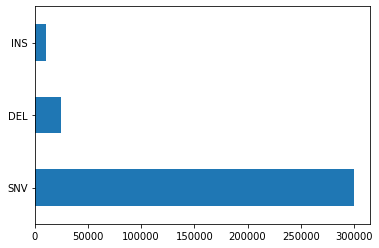




COLUMN 84 : allvalid
Nr of values: 2
Type of column: bool
False    303310
True      31291
Name: allvalid, dtype: int64


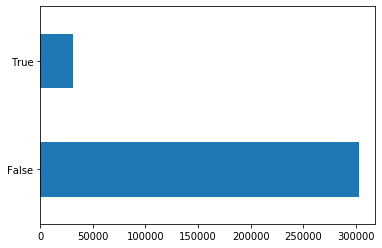




COLUMN 85 : bStatistic
Nr of values: 989
Type of column: float64
0.0      13318
952.0     2449
259.0     1983
970.0     1840
878.0     1725
         ...  
39.0         4
993.0        2
30.0         2
985.0        1
29.0         1
Name: bStatistic, Length: 989, dtype: int64


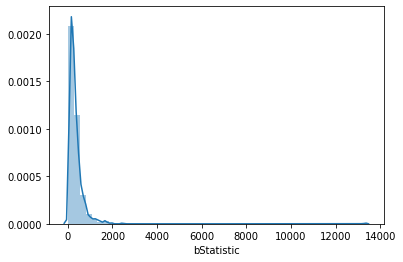




COLUMN 86 : binarized_label
Nr of values: 2
Type of column: int64
0    293920
1     40681
Name: binarized_label, dtype: int64


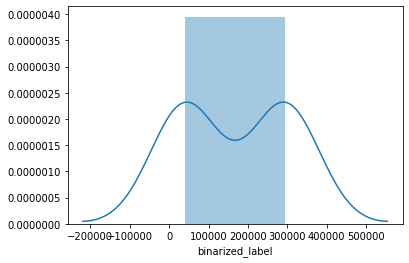




COLUMN 87 : cDNApos
Nr of values: 26524
Type of column: float64
886.0      110
753.0      108
754.0      107
760.0      107
844.0      107
          ... 
53472.0      1
97279.0      1
97282.0      1
48642.0      1
18319.0      1
Name: cDNApos, Length: 26524, dtype: int64


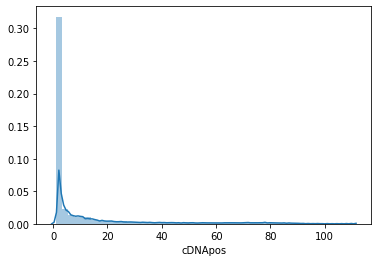




COLUMN 88 : cHmmBivFlnk
Nr of values: 88
Type of column: float64
0.0000    313661
0.0080      5696
0.0160      2097
0.0240      1603
0.0310       948
           ...  
0.0235         1
0.2595         1
0.0120         1
0.2795         1
0.0315         1
Name: cHmmBivFlnk, Length: 88, dtype: int64


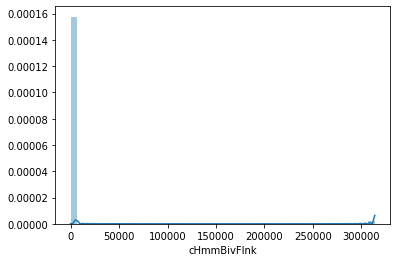




COLUMN 89 : cHmmEnh
Nr of values: 115
Type of column: float64
0.0000    180936
0.0080     46728
0.0160     24466
0.0240     13890
0.0310     10412
           ...  
0.7240         1
0.0865         1
0.1495         1
0.2045         1
0.1300         1
Name: cHmmEnh, Length: 115, dtype: int64


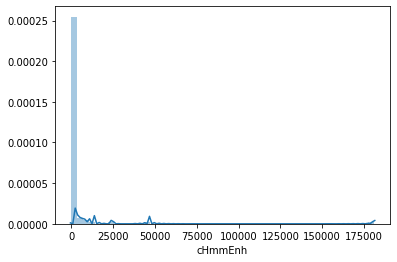




COLUMN 90 : cHmmEnhBiv
Nr of values: 75
Type of column: float64
0.0000    294922
0.0080     15208
0.0160      5934
0.0240      3065
0.0310      2057
           ...  
0.0830         1
0.1140         1
0.0430         1
0.0250         1
0.2085         1
Name: cHmmEnhBiv, Length: 75, dtype: int64


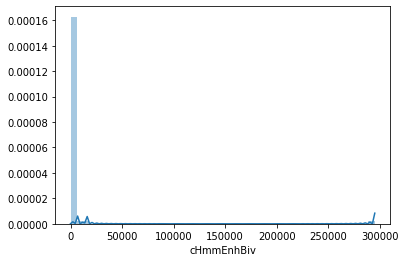




COLUMN 91 : cHmmEnhG
Nr of values: 117
Type of column: float64
0.0000    185556
0.0080     45597
0.0160     26002
0.0240     17050
0.0310      9711
           ...  
0.1300         1
0.6140         1
0.1060         1
0.2240         1
0.0435         1
Name: cHmmEnhG, Length: 117, dtype: int64


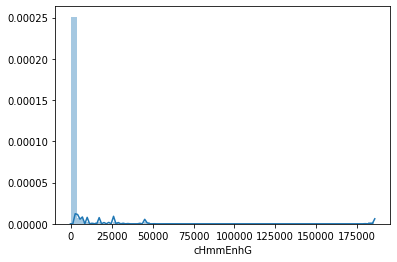




COLUMN 92 : cHmmHet
Nr of values: 107
Type of column: float64
0.0000    258923
0.0080     29080
0.0160     14800
0.0240      7774
0.0310      4877
           ...  
0.7640         1
0.2955         1
0.5670         1
0.5430         1
0.1240         1
Name: cHmmHet, Length: 107, dtype: int64


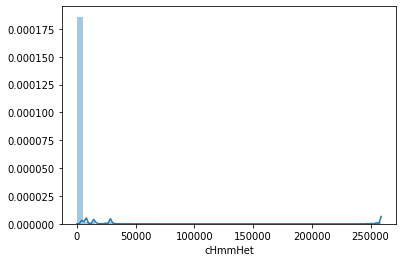




COLUMN 93 : cHmmQuies
Nr of values: 197
Type of column: float64
0.008    27526
0.000    27484
0.016    24582
0.024    13950
0.031    10554
         ...  
0.075        1
0.413        1
0.563        1
0.461        1
0.570        1
Name: cHmmQuies, Length: 197, dtype: int64


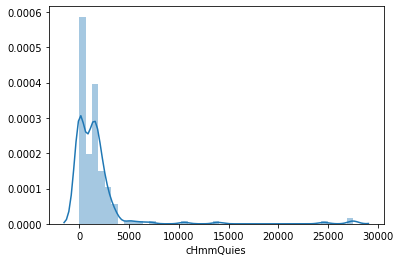




COLUMN 94 : cHmmReprPC
Nr of values: 146
Type of column: float64
0.0000    227838
0.0080     27887
0.0160     15528
0.0240      9104
0.0310      6733
           ...  
0.2955         1
0.0235         1
0.2245         1
0.0590         1
0.0980         1
Name: cHmmReprPC, Length: 146, dtype: int64


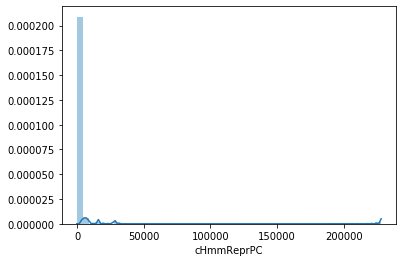




COLUMN 95 : cHmmReprPCWk
Nr of values: 148
Type of column: float64
0.0000    146391
0.0080     33224
0.0160     12215
0.0240     10043
0.0310      8139
           ...  
0.5355         1
0.4840         1
0.7440         1
0.3660         1
0.0200         1
Name: cHmmReprPCWk, Length: 148, dtype: int64


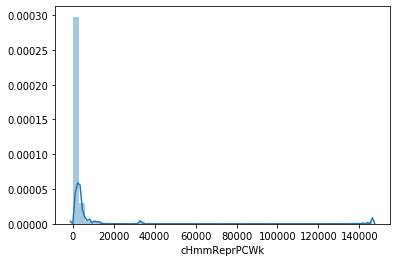




COLUMN 96 : cHmmTssA
Nr of values: 161
Type of column: float64
0.0000    282065
0.0080     13653
0.0160      4422
0.0240      2716
0.0310      2013
           ...  
0.0315         1
0.1740         1
0.0195         1
0.9490         1
0.6730         1
Name: cHmmTssA, Length: 161, dtype: int64


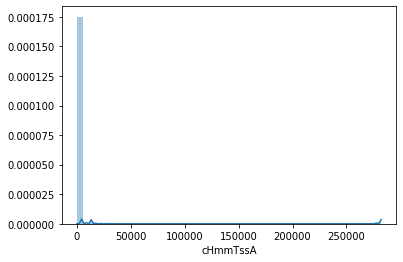




COLUMN 97 : cHmmTssAFlnk
Nr of values: 135
Type of column: float64
0.000    274152
0.008     20934
0.016      8947
0.024      4523
0.031      3977
          ...  
0.185         1
0.866         1
0.803         1
0.059         1
0.130         1
Name: cHmmTssAFlnk, Length: 135, dtype: int64


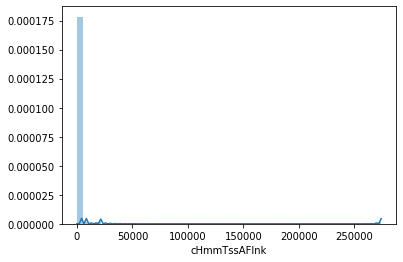




COLUMN 98 : cHmmTssBiv
Nr of values: 83
Type of column: float64
0.0000    304196
0.0080      8899
0.0160      3860
0.0240      2015
0.0310      1467
           ...  
0.4330         1
0.4765         1
0.2010         1
0.0910         1
0.1535         1
Name: cHmmTssBiv, Length: 83, dtype: int64


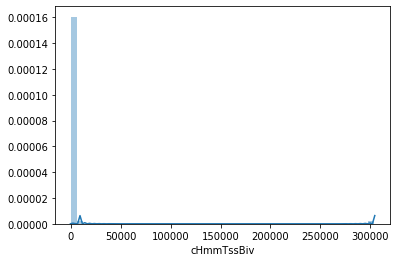




COLUMN 99 : cHmmTx
Nr of values: 248
Type of column: float64
0.0000    76236
0.0080    19471
0.0160    11363
0.0240     7623
0.0310     6278
          ...  
0.8035        1
0.1575        1
0.3030        1
0.8700        1
0.4370        1
Name: cHmmTx, Length: 248, dtype: int64


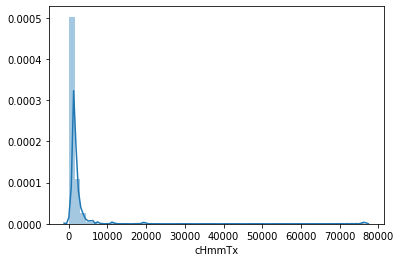




COLUMN 100 : cHmmTxFlnk
Nr of values: 125
Type of column: float64
0.0000    271441
0.0080     27825
0.0160     13869
0.0240      6569
0.0310      3197
           ...  
0.7720         1
0.4880         1
0.0510         1
0.2675         1
0.2950         1
Name: cHmmTxFlnk, Length: 125, dtype: int64


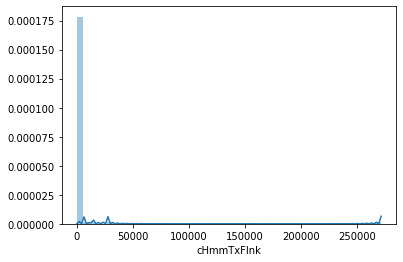




COLUMN 101 : cHmmTxWk
Nr of values: 259
Type of column: float64
0.0000    19988
0.0080    13451
0.0160    11477
0.0240     9516
0.0310     8339
          ...  
0.2480        1
0.1220        1
0.3425        1
0.4210        1
0.0235        1
Name: cHmmTxWk, Length: 259, dtype: int64


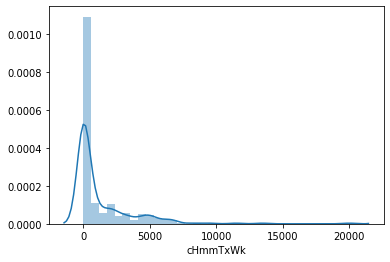




COLUMN 102 : cHmmZnfRpts
Nr of values: 119
Type of column: float64
0.0000    271302
0.0080     33878
0.0160     11174
0.0240      4976
0.0310      2657
           ...  
0.0865         1
0.0155         1
0.9450         1
0.8900         1
0.8500         1
Name: cHmmZnfRpts, Length: 119, dtype: int64


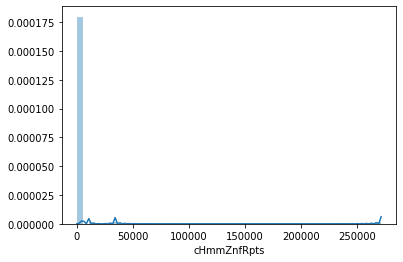




COLUMN 103 : chr_pos_ref_alt
Nr of values: 334601
Type of column: object
10_88446899_G_A      1
9_136219601_CTA_C    1
14_64537383_T_G      1
15_93492086_T_G      1
1_186099180_C_T      1
                    ..
X_70465624_C_T       1
22_17594977_A_G      1
2_179442400_G_T      1
X_70465643_A_G       1
20_33581955_G_A      1
Name: chr_pos_ref_alt, Length: 334601, dtype: int64


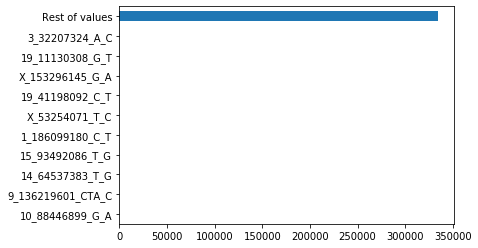




COLUMN 104 : chr_pos_ref_alt_gene
Nr of values: 334601
Type of column: object
14_64589140_C_A_MIR548AZ         1
9_129461696_G_A_RP11-489N22.3    1
2_182545205_C_T_AC013733.3       1
1_220267519_G_T_RNU5F-1          1
17_6337433_G_A_AIPL1             1
                                ..
3_9487359_G_T_SETD5              1
9_107578620_G_A_ABCA1            1
17_41219804_T_C_BRCA1            1
9_131389244_C_T_MIR1268A         1
6_51900457_ATC_A_PKHD1           1
Name: chr_pos_ref_alt_gene, Length: 334601, dtype: int64


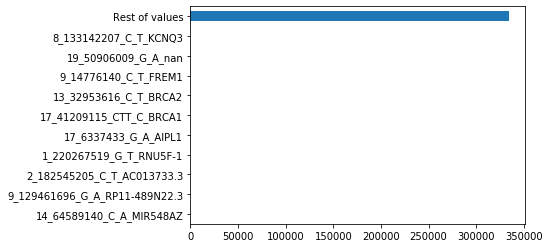




COLUMN 105 : clinpred
Nr of values: 119354
Type of column: float64
1.000000    18
0.000295    17
0.999970    17
0.000581     7
0.999966     7
            ..
0.106360     1
0.000365     1
0.343313     1
0.024730     1
0.342754     1
Name: clinpred, Length: 119354, dtype: int64


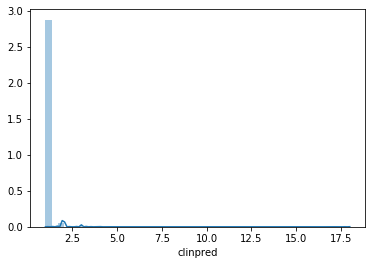




COLUMN 106 : dbscSNV-ada_score
Nr of values: 21131
Type of column: float64
0.999988    874
0.999987    740
0.999990    664
0.999986    343
0.999982    258
           ... 
0.000118      1
0.999991      1
0.000711      1
0.995285      1
0.011775      1
Name: dbscSNV-ada_score, Length: 21131, dtype: int64


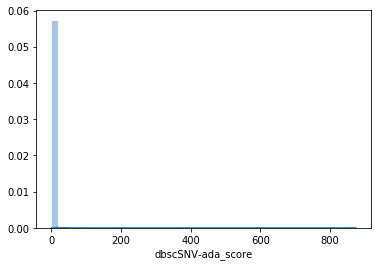




COLUMN 107 : dbscSNV-rf_score
Nr of values: 1063
Type of column: object
0.0                    3014
0.002                  1294
0.004                   873
0.938                   814
0.006                   554
                       ... 
0.81                      1
0.742                     1
0.11800000000000001       1
0.474                     1
0.7020000000000001        1
Name: dbscSNV-rf_score, Length: 1063, dtype: int64


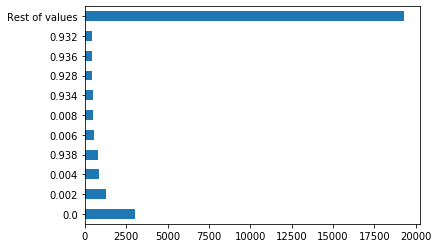




COLUMN 108 : fathmm_score
Nr of values: 63214
Type of column: float64
0.990749    25
0.991091    15
0.991682    12
0.991363    11
0.991769    11
            ..
0.649318     1
0.211790     1
0.318894     1
0.711424     1
0.015625     1
Name: fathmm_score, Length: 63214, dtype: int64


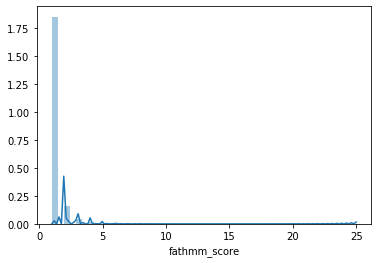




COLUMN 109 : inClinvar
Nr of values: 2
Type of column: object
False    209071
True     117325
Name: inClinvar, dtype: int64


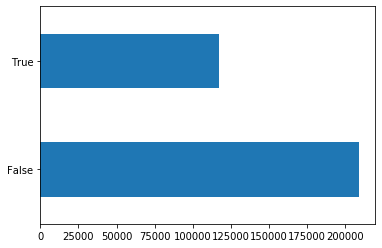




COLUMN 110 : inClinvar1Star
Nr of values: 2
Type of column: object
False    301818
True      24578
Name: inClinvar1Star, dtype: int64


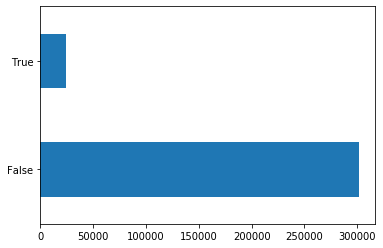




COLUMN 111 : inClinvar2Star
Nr of values: 2
Type of column: object
False    233649
True      92747
Name: inClinvar2Star, dtype: int64


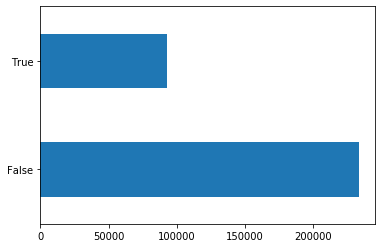




COLUMN 112 : inVKGLInsertion
Nr of values: 2
Type of column: object
False    313542
True        110
Name: inVKGLInsertion, dtype: int64


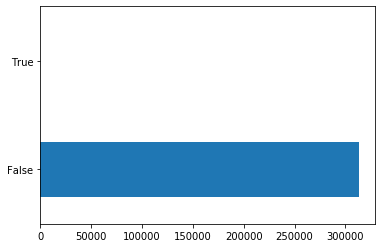




COLUMN 113 : inheritance
Nr of values: 31
Type of column: object
AD                                                                                                     109466
AR                                                                                                      51505
AD/AR                                                                                                   33894
XL                                                                                                      11452
AD/AR/Digenic                                                                                            1870
AD/Digenic                                                                                                912
AR/Digenic                                                                                                609
AD/BG                                                                                                     541
AR                                                  

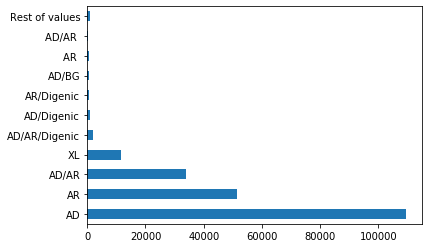




COLUMN 114 : isAR
Nr of values: 2
Type of column: bool
False    245501
True      89100
Name: isAR, dtype: int64


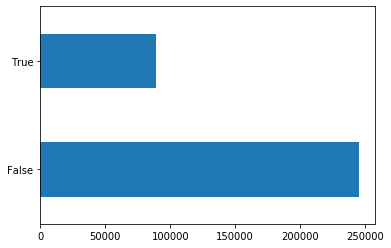




COLUMN 115 : isInsertion
Nr of values: 2
Type of column: bool
False    324386
True      10215
Name: isInsertion, dtype: int64


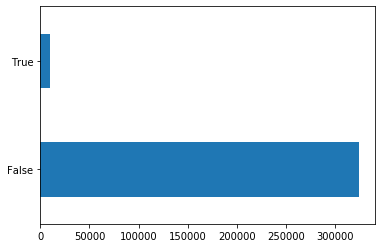




COLUMN 116 : isPopulation
Nr of values: 2
Type of column: bool
False    189190
True     145411
Name: isPopulation, dtype: int64


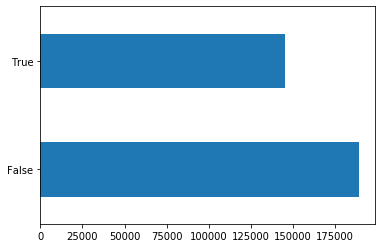




COLUMN 117 : isVKGL_needsFurtherCorrection
Nr of values: 1
Type of column: bool
False    334601
Name: isVKGL_needsFurtherCorrection, dtype: int64


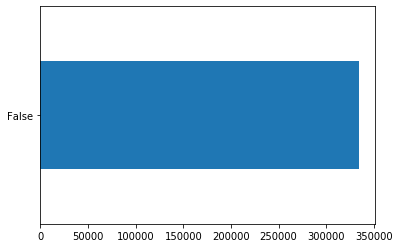




COLUMN 118 : label
Nr of values: 2
Type of column: object
Benign        293920
Pathogenic     40681
Name: label, dtype: int64


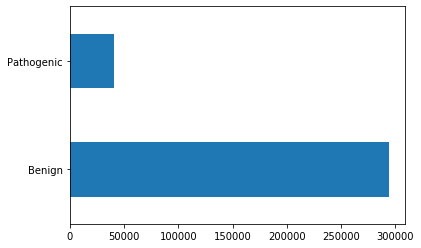




COLUMN 119 : mamPhCons
Nr of values: 1001
Type of column: float64
1.000    82143
0.000    51440
0.999    19268
0.001    13421
0.998     8966
         ...  
0.562       31
0.348       29
0.472       28
0.465       28
0.538       25
Name: mamPhCons, Length: 1001, dtype: int64


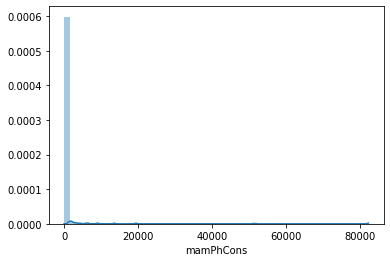




COLUMN 120 : mamPhyloP
Nr of values: 8013
Type of column: float64
 2.938    1309
-0.000     897
 2.368     786
 2.933     522
 2.891     443
          ... 
-5.815       1
-5.328       1
-4.326       1
-3.540       1
-3.900       1
Name: mamPhyloP, Length: 8013, dtype: int64


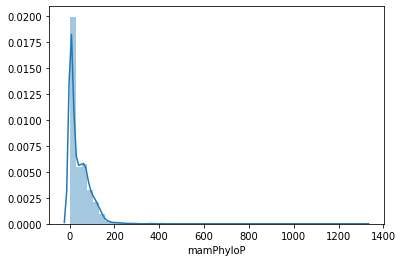




COLUMN 121 : max_AF
Nr of values: 60700
Type of column: float64
0.000000    75902
0.000032     5478
0.000058     2686
0.000030     2287
0.001193     2156
            ...  
0.000006        1
0.000090        1
0.000090        1
0.000359        1
0.002751        1
Name: max_AF, Length: 60700, dtype: int64


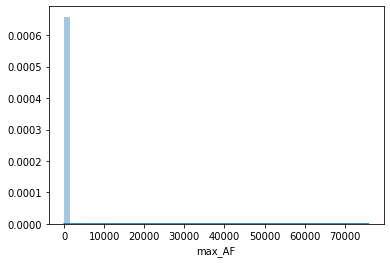




COLUMN 122 : minDistTSE
Nr of values: 62468
Type of column: float64
1.0        724
2.0        723
3.0        629
5.0        607
8.0        588
          ... 
96380.0      1
27625.0      1
96375.0      1
63332.0      1
18241.0      1
Name: minDistTSE, Length: 62468, dtype: int64


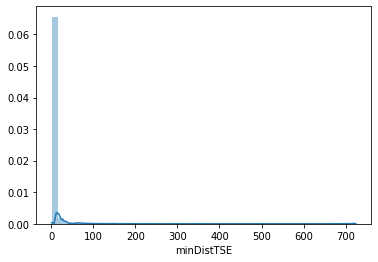




COLUMN 123 : minDistTSS
Nr of values: 80873
Type of column: float64
1.0         610
3.0         541
2.0         523
7.0         506
6.0         488
           ... 
394223.0      1
62632.0       1
49842.0       1
39065.0       1
131069.0      1
Name: minDistTSS, Length: 80873, dtype: int64


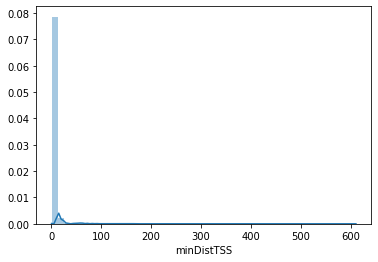




COLUMN 124 : mirSVR-Aln
Nr of values: 69
Type of column: float64
120.0    4558
140.0    3182
145.0    1937
147.0    1492
150.0    1435
         ... 
182.0       2
187.0       1
186.0       1
185.0       1
180.0       1
Name: mirSVR-Aln, Length: 69, dtype: int64


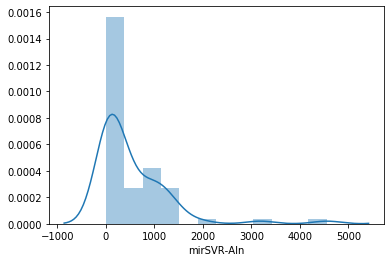




COLUMN 125 : mirSVR-E
Nr of values: 2962
Type of column: float64
-15.06    74
-26.11    53
-18.51    48
-10.02    47
-16.96    46
          ..
-27.64     1
-29.86     1
-34.47     1
-37.12     1
-28.89     1
Name: mirSVR-E, Length: 2962, dtype: int64


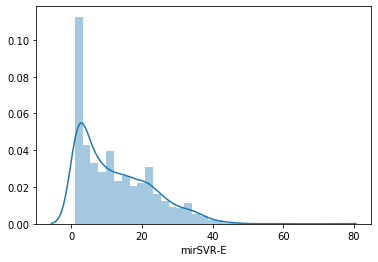




COLUMN 126 : mirSVR-Score
Nr of values: 8920
Type of column: float64
-0.0001    195
-0.0002    179
-0.0004    175
-0.0003    146
-0.0000    145
          ... 
-1.3287      1
-0.6762      1
-0.6011      1
-0.2912      1
-0.9974      1
Name: mirSVR-Score, Length: 8920, dtype: int64


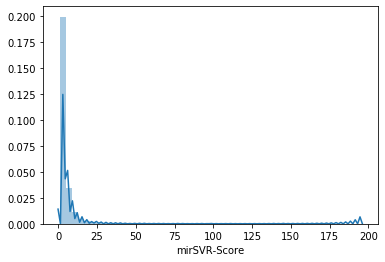




COLUMN 127 : motifDist
Nr of values: 552
Type of column: float64
 0.00     1159
 1.00      750
-1.00      217
 0.04      204
 0.01      199
          ... 
-2.93        1
-3.89        1
-2.32        1
-6.50        1
-14.50       1
Name: motifDist, Length: 552, dtype: int64


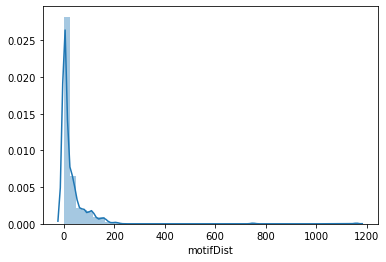




COLUMN 128 : motifECount
Nr of values: 13
Type of column: float64
1.0     1165
2.0      390
3.0      147
4.0       77
5.0       36
6.0       22
8.0       15
10.0      11
12.0       7
7.0        7
9.0        7
11.0       4
13.0       1
Name: motifECount, dtype: int64


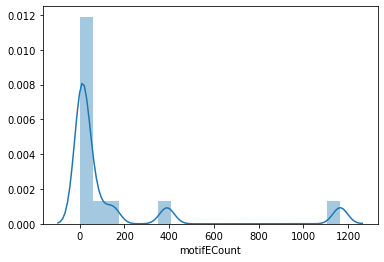




COLUMN 129 : motifEHIPos
Nr of values: 2
Type of column: float64
0.0    1358
1.0     531
Name: motifEHIPos, dtype: int64


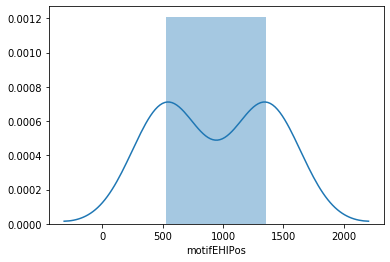




COLUMN 130 : motifEName
Nr of values: 58
Type of column: object
CTCF:MA0139.1      366
Egr1:MA0162.2      173
Egr1:PB0010.1      150
E2F1:MA0024.2      103
Egr1:MA0341.1       91
Yy1:MA0095.2        81
Znf263:MA0528.1     73
Max:PB0043.1        54
Gabp:MA0062.2       53
Gabp:PB0020.1       52
Nrsf:MA0138.2       51
Cjun:MA0303.1       42
E2F4:MA0470.1       42
Max:PB0147.1        40
E2F4:MA0541.1       39
USF1:MA0281.1       39
Egr1:MA0366.1       36
Egr1:MA0337.1       35
USF1:MA0093.2       27
Gabp:PB0124.1       27
Egr1:PB0114.1       21
Max:MA0569.1        19
ZBTB33:MA0527.1     17
Srf:MA0083.2        16
HNF4A:MA0114.2      15
E2F6:MA0471.1       15
Jund:MA0491.1       14
Cjun:MA0488.1       14
ELF1:MA0473.1       13
CTCFL:MA0531.1      13
PU1:PB0058.1        12
Max:MA0058.2        12
SP1:MA0079.3        12
FOSL2:MA0478.1      12
Gabp:MA0062.1        9
Cjun:MA0489.1        9
PU1:MA0080.3         8
Srf:MA0271.1         8
Tr4:MA0504.1         8
Cmyc:MA0147.2        7
EBF1:MA0154.2

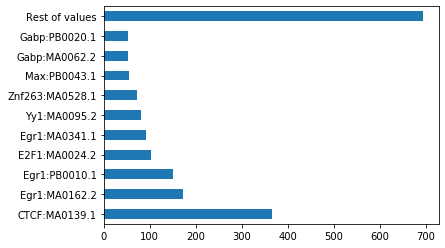




COLUMN 131 : motifEScoreChng
Nr of values: 184
Type of column: float64
-0.203    89
-0.030    41
-0.007    37
-0.103    37
 0.006    33
          ..
-0.070     1
-0.246     1
 0.045     1
-0.094     1
-0.131     1
Name: motifEScoreChng, Length: 184, dtype: int64


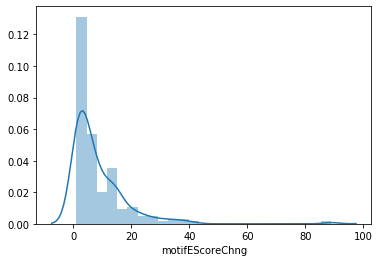




COLUMN 132 : nAA
Nr of values: 1604
Type of column: object
L          18223
S          17508
T          15574
V          15065
R          13716
           ...  
LC             1
PPQX           1
E*MNSFX        1
QQQH           1
*TS            1
Name: nAA, Length: 1604, dtype: int64


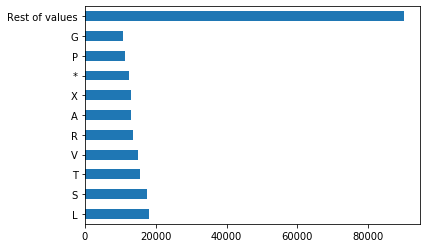




COLUMN 133 : notinTest1
Nr of values: 2
Type of column: bool
True     328728
False      5873
Name: notinTest1, dtype: int64


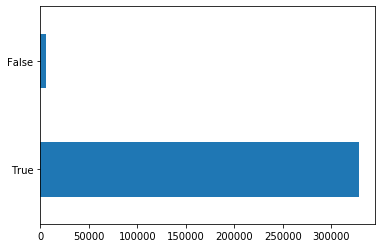




COLUMN 134 : oAA
Nr of values: 2668
Type of column: object
R          22933
A          18869
L          17014
P          16699
S          16373
           ...  
KVL            1
RLRFA          1
GFD            1
KAA            1
LPPKSEV        1
Name: oAA, Length: 2668, dtype: int64


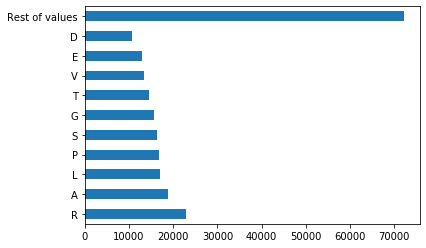




COLUMN 135 : priPhCons
Nr of values: 1000
Type of column: float64
0.998    10175
0.997     8048
0.001     7314
0.996     6862
0.000     5994
         ...  
0.538       84
0.487       84
0.514       83
0.411       79
0.508       75
Name: priPhCons, Length: 1000, dtype: int64


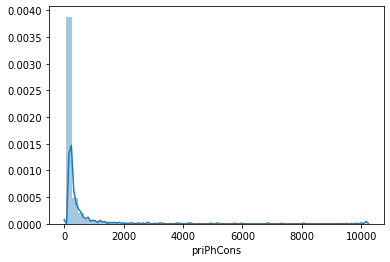




COLUMN 136 : priPhyloP
Nr of values: 3932
Type of column: float64
 0.651    38653
 0.530    24044
 0.557    18495
 0.645    14741
 0.457    13711
          ...  
-3.368        1
-4.955        1
-2.066        1
-3.780        1
-5.427        1
Name: priPhyloP, Length: 3932, dtype: int64


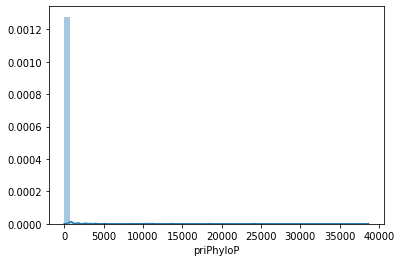




COLUMN 137 : protPos
Nr of values: 15918
Type of column: float64
142.0      304
68.0       301
172.0      301
80.0       299
144.0      298
          ... 
5857.0       1
23427.0      1
11713.0      1
29826.0      1
5302.0       1
Name: protPos, Length: 15918, dtype: int64


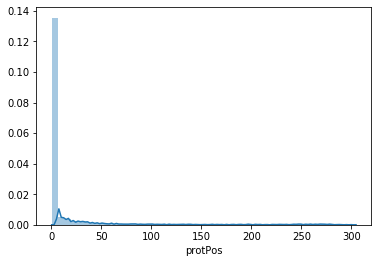




COLUMN 138 : provean
Nr of values: 2281
Type of column: float64
-0.00     70671
 0.73       357
 0.85       334
 0.80       334
 0.79       331
          ...  
 23.03        1
 29.77        1
-4.33         1
-3.47         1
-5.06         1
Name: provean, Length: 2281, dtype: int64


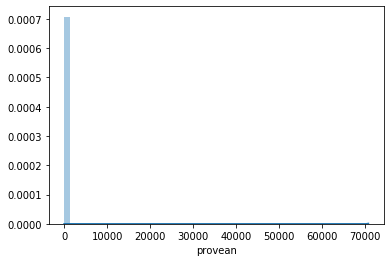




COLUMN 139 : relCDSpos
Nr of values: 196870
Type of column: float64
0.333333    96
0.666667    88
0.833333    65
1.000000    42
0.500000    38
            ..
0.526756     1
0.501102     1
0.804435     1
0.746310     1
0.314570     1
Name: relCDSpos, Length: 196870, dtype: int64


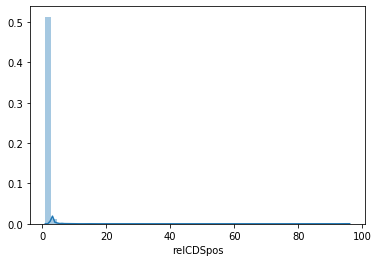




COLUMN 140 : relProtPos
Nr of values: 159388
Type of column: float64
1.000000    227
0.500000    146
0.666667    113
0.333333    113
0.750000     81
           ... 
0.666592      1
0.349643      1
0.492638      1
0.175725      1
0.587737      1
Name: relProtPos, Length: 159388, dtype: int64


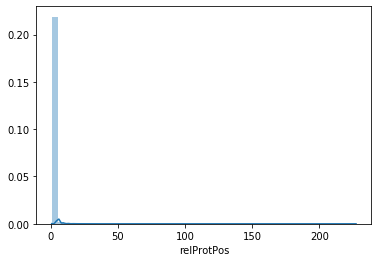




COLUMN 141 : relcDNApos
Nr of values: 225820
Type of column: float64
0.500000    34
0.333333    30
0.400000    26
0.666667    24
0.250000    23
            ..
0.120067     1
0.525664     1
0.306940     1
0.541277     1
0.582173     1
Name: relcDNApos, Length: 225820, dtype: int64


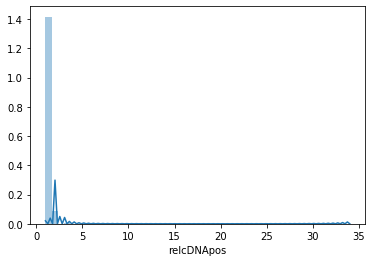




COLUMN 142 : revel
Nr of values: 1001
Type of column: float64
0.030    402
0.041    398
0.033    398
0.043    384
0.036    379
        ... 
0.001     17
0.997     15
1.000      9
0.999      9
0.000      7
Name: revel, Length: 1001, dtype: int64


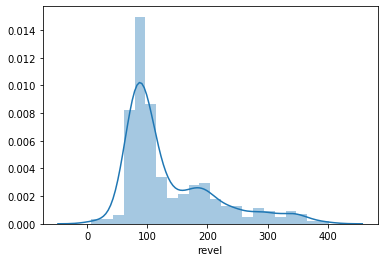




COLUMN 143 : sift
Nr of values: 1001
Type of column: float64
0.000    60334
1.000    20095
0.999     9029
0.998     4826
0.997     3338
         ...  
0.058       18
0.187       17
0.054       16
0.045       15
0.026       12
Name: sift, Length: 1001, dtype: int64


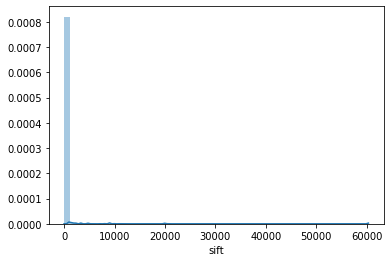




COLUMN 144 : source
Nr of values: 3
Type of column: object
unknown    209071
clinvar    117325
vkgl         8205
Name: source, dtype: int64


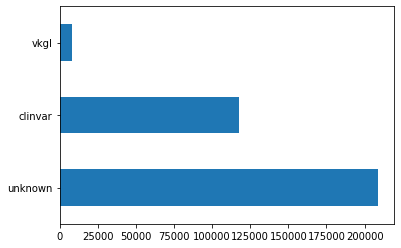




COLUMN 145 : tOverlapMotifs
Nr of values: 28
Type of column: float64
1.0     11145
2.0      2838
3.0      1337
4.0       620
5.0       367
6.0       214
7.0       115
10.0       58
8.0        56
9.0        48
11.0       30
15.0       16
12.0       16
20.0       12
13.0       10
14.0        7
17.0        6
16.0        5
21.0        5
19.0        4
18.0        4
22.0        4
27.0        3
36.0        2
26.0        2
31.0        1
23.0        1
24.0        1
Name: tOverlapMotifs, dtype: int64


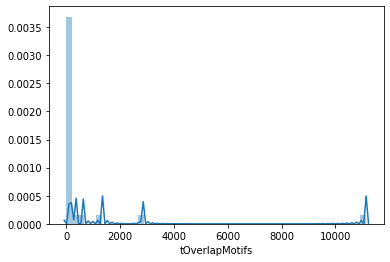




COLUMN 146 : targetScan
Nr of values: 67
Type of column: float64
99.0    40
96.0    33
98.0    32
97.0    28
78.0    27
        ..
15.0     1
27.0     1
50.0     1
43.0     1
62.0     1
Name: targetScan, Length: 67, dtype: int64


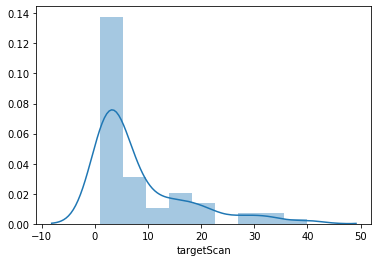




COLUMN 147 : to_be_deleted
Nr of values: 2
Type of column: bool
False    331169
True       3432
Name: to_be_deleted, dtype: int64


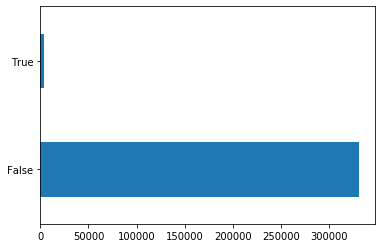




COLUMN 148 : verPhCons
Nr of values: 1001
Type of column: float64
1.000    114089
0.000     56851
0.999     15472
0.001     12531
0.998      6736
          ...  
0.520        24
0.490        23
0.525        22
0.630        21
0.557        20
Name: verPhCons, Length: 1001, dtype: int64


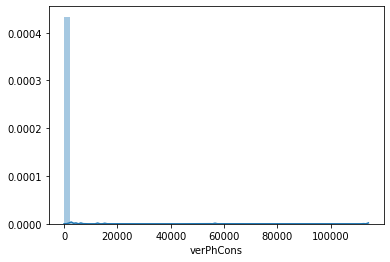




COLUMN 149 : verPhyloP
Nr of values: 11330
Type of column: float64
 0.000    744
 0.311    209
 0.202    192
 0.192    190
 0.275    179
         ... 
-4.800      1
-4.165      1
-5.890      1
-7.652      1
-3.881      1
Name: verPhyloP, Length: 11330, dtype: int64


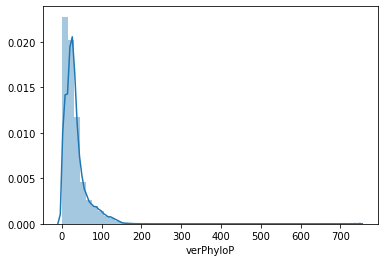




COLUMN 150 : inTest
Nr of values: 1
Type of column: bool
False    334601
Name: inTest, dtype: int64


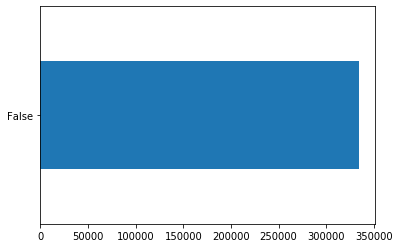




COLUMN 151 : sample_weight
Nr of values: 2
Type of column: float64
0.8    301818
1.0     32783
Name: sample_weight, dtype: int64


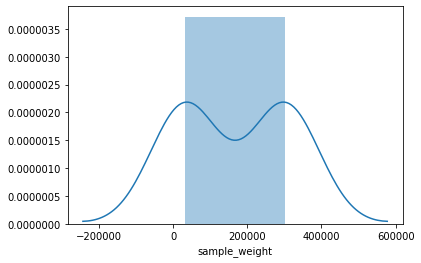

In [276]:
for i in range(len(train.columns)):
    c = train.columns[i]
    print('COLUMN', i, ':', c)
    counts = train[c].value_counts()
    t = train[c].dtype
    print('Nr of values:', len(counts))
    print('Type of column:', t)
    print(counts)
    
    #if type of variable is numerical, plot histogram, else plot barplot (of the top 10 values if there are more than 10 values). 
    if t == 'int64' or t == 'float64':
        sns.distplot(counts)
    else:   
        if len(counts) > 10:
            rest = counts[10:].sum()
            counts = counts[0:10]
            counts['Rest of values'] = rest
        counts.plot(kind='barh')
    if c not in all_features_model:
        c = 'NOT-USED_' + c
    plt.savefig('../figures/data_exploration/feature_frequency_plots_all_data/' + c.replace('/', '_') + '.png', bbox_inches='tight')
    plt.show()
    print('\n\n')

<h1>Subsetting the data on non-coding variants</h1>
<br>To generate the noncoding subset, only keep variants where 'Consequence' points to non-coding.

In [8]:
train.Consequence.value_counts()

NON_SYNONYMOUS      128064
SYNONYMOUS           67625
INTRONIC             44145
FRAME_SHIFT          17306
DOWNSTREAM           16284
STOP_GAINED          12788
SPLICE_SITE          11730
UPSTREAM              9335
3PRIME_UTR            8717
REGULATORY            6657
CANONICAL_SPLICE      5813
INFRAME               3399
5PRIME_UTR            1372
NONCODING_CHANGE      1278
STOP_LOST               75
INTERGENIC               9
UNKNOWN                  3
Name: Consequence, dtype: int64

In [11]:
nc_consq_values = ['INTRONIC', 'DOWNSTREAM', 'UPSTREAM', '3PRIME_UTR', '5PRIME_UTR', 'INTERGENIC', 'NONCODING_CHANGE']
nc = train.loc[train.Consequence.isin(nc_consq_values)]
#nc_test = test.loc[test.Consequence.isin(nc_consq_values)]

nc.to_csv('../data/train_nc.txt', sep='\t', index=False)
#nc_test.to_csv('../data/test_nc.txt', sep='\t', index=False)

print('Percentage of non-coding variants in whole dataset:', nc.shape[0]/train.shape[0]*100)
print(nc.shape)
c = nc['label'].value_counts()
print('Percentage pathogenic in non-coding dataset:', round(c['Pathogenic'] / nc.shape[0] * 100, 2))
print(c)
print('Percentage pathogenic in whole dataset:', round( train['label'].value_counts()['Pathogenic']/train.shape[0]*100, 2))

Percentage of non-coding variants in whole dataset: 24.249778093908862
(81140, 152)
Percentage pathogenic in non-coding dataset: 2.19
Benign        79367
Pathogenic     1773
Name: label, dtype: int64
Percentage pathogenic in whole dataset: 12.16


Check how much NA values there are per column for the whole dataset and the noncoding subset, and remove non-informative features from the noncoding subset.

In [9]:
na_all = train[all_features_model].isnull().sum().divide(train.shape[0]).multiply(100).round(2)
na_nc = nc[all_features_model].isnull().sum().divide(nc.shape[0]).multiply(100).round(2)

In [10]:
feature_importance = list(map(lambda x: x[0], sorted([[k,v] for k, v in model.best_estimator_.get_booster().get_fscore().items()], key=lambda x: x[1], reverse=True)))
features_model_not_in_feature_importances = list(numerical_features_cadd.difference(set(feature_importance)))
print('Features from the model not in feature importances:', features_model_not_in_feature_importances)

#order the numerical features on importance. Add the other features to the end of the list
feature_importance_numerical = [x for x in feature_importance if x in numerical_features_cadd] + features_model_not_in_feature_importances


Features from the model not in feature importances: ['protPos']


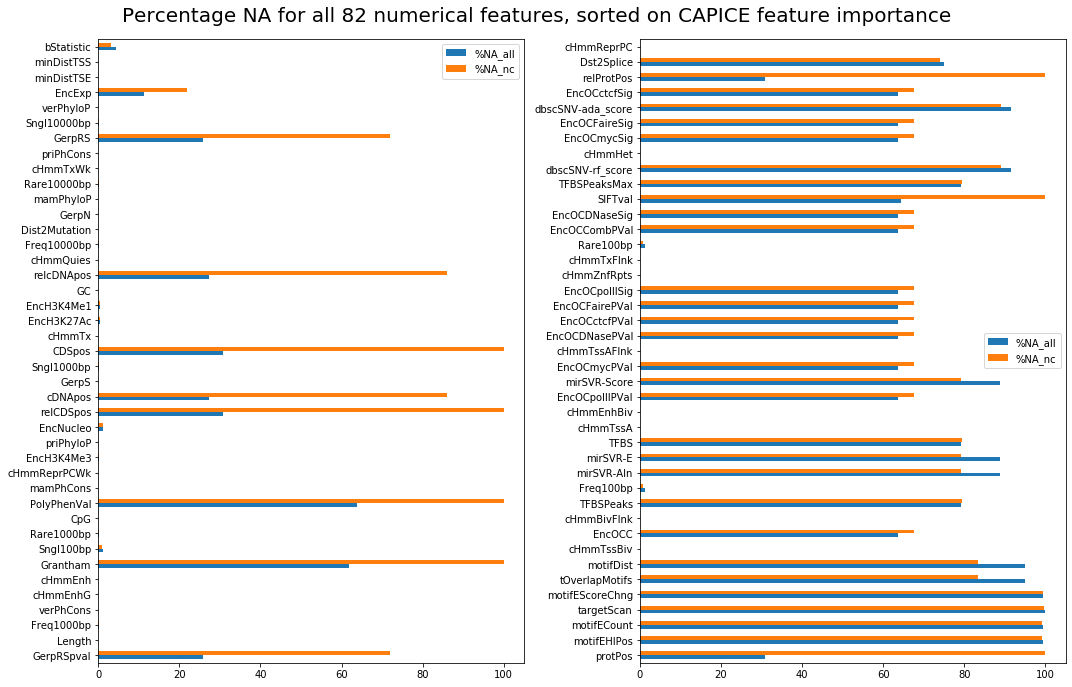

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))
na_df_numerical = pd.DataFrame({'%NA_all': na_all, '%NA_nc': na_nc}, index=na_nc.index).reindex(feature_importance_numerical[::-1])
na_df_numerical[round(na_df_numerical.shape[0]/2):].plot.barh(rot=0, ax=ax0)
na_df_numerical[:round(na_df_numerical.shape[0]/2)].plot.barh(rot=0, ax=ax1)
fig.suptitle('Percentage NA for all ' + str(len(feature_importance_numerical)) + ' numerical features, sorted on CAPICE feature importance', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figures/data_exploration/percentage_NA_numerical.png', bbox_inches='tight')


<Figure size 360x360 with 0 Axes>

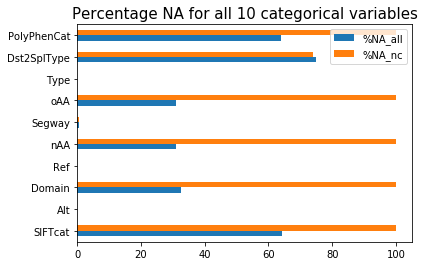

In [12]:
plt.figure(figsize=(5, 5))
na_df_categorical = pd.DataFrame({'%NA_all': na_all, '%NA_nc': na_nc}, index=na_nc.index).reindex(categorical_features_cadd)
na_df_categorical.plot.barh(rot=0)
plt.title('Percentage NA for all ' + str(len(categorical_features_cadd)) + ' categorical variables', fontsize=15)
plt.savefig('../figures/data_exploration/percentage_NA_categorical.png', bbox_inches='tight')

As can be seen in the plots above, some columns have a high percentage of NA values. For the noncoding variants, there are some columns that contain a lot of NA values (e.g. CDSpos, Domain, PolyPhen, SIFT). Drop these columns from the noncoding dataset (filtering out columns with more than 20% of NA values).

In [13]:
features_to_drop = na_df_numerical[na_df_numerical['%NA_nc'] > 20].index.tolist() + na_df_categorical[na_df_categorical['%NA_nc'] > 20].index.tolist()
print(len(features_to_drop), 'features from the', len(nc.columns) ,'will be dropped from the noncoding dataset due to having more than 20% NA values')

45 features from the 152 will be dropped from the noncoding dataset due to having more than 20% NA values


In [14]:
nc = nc.drop(features_to_drop, axis=1)

<h1>Feature correlation</h1>

In [15]:
len(set(nc.columns).intersection(set(model_features)))

43

Text(0.5, 1, 'Feature correlation for all variants')

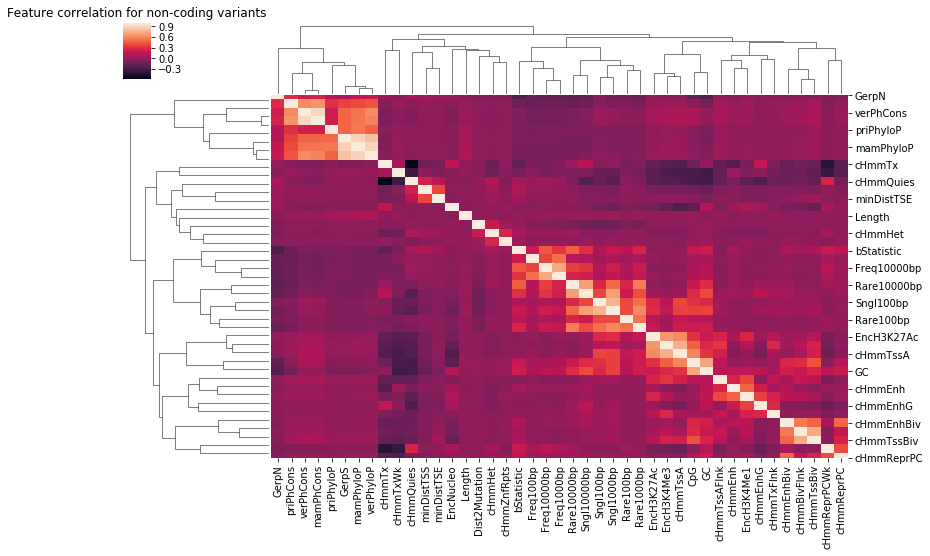

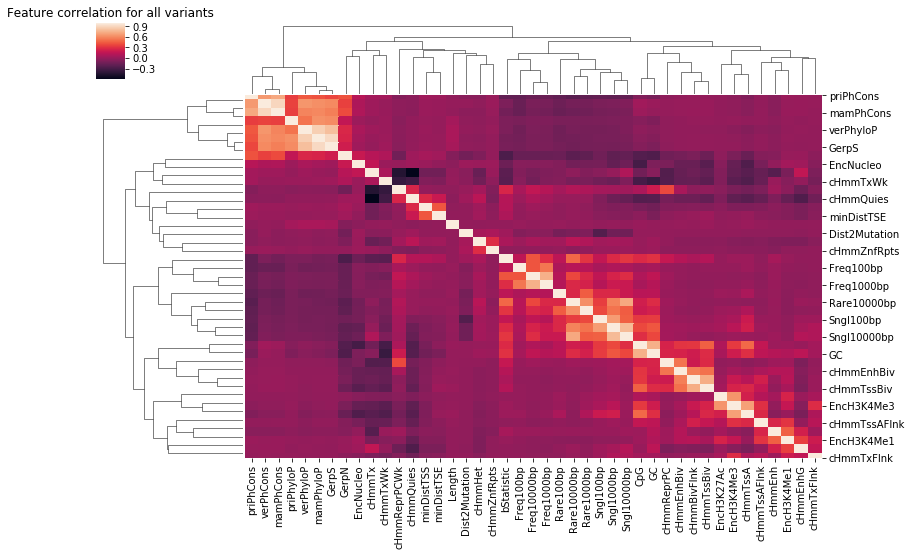

In [16]:
numerical_features = set(nc.columns).intersection(numerical_features_cadd)

#delete two columns because they contain NAs causing clustermap crash
#numerical_features.remove('relProtPos')
#numerical_features.remove('motifEScoreChng')

correlations_matrix = nc[numerical_features].corr()
clustermap(correlations_matrix, figsize=(13,8))
plt.title('Feature correlation for non-coding variants')
#plt.savefig('../figures/data_exploration/nc_features_correlation.png', bbox_inches='tight')

correlations_matrix = train[numerical_features].corr()
clustermap(correlations_matrix, figsize=(13,8))
plt.title('Feature correlation for all variants')
#plt.savefig('../figures/data_exploration/all_features_correlation.png', bbox_inches='tight')

<h1>PCA and tSNE</h1>

In [20]:
def dimreduction(df, features, n_pcs, plot_pc_variance=True, plottitle='PC_variance_ratio'):
    print('Dataframe with {} rows and {} columns. {} columns will be used for dimension reduction.'.format(df.shape[0], df.shape[1], len(features)))
    df_filtered = df[features].dropna()
    print('Dropping {} rows that contain NA values. Continuing with {} rows.'.format(df.shape[0]-df_filtered.shape[0], df_filtered.shape[0]))
    print(df[features].dropna().shape) 
    
    print('Performing PCA, calculating {} components.'.format(n_pcs))
    pca = PCA(n_components=n_pcs)
    min_max_scaler = preprocessing.StandardScaler() 
    normed_data = min_max_scaler.fit_transform(df_filtered)
    normed_pd = pd.DataFrame(data=normed_data, columns=features)
    pca.fit(normed_pd)
    pcs = pca.fit_transform(normed_pd)

    if plot_pc_variance:
        labels = [i+1 for i in range(len(pca.explained_variance_ratio_))]
        index = np.arange(len(labels))
        plt.bar(index, pca.explained_variance_ratio_)
        plt.xlabel('PC')
        plt.ylabel('Variance ratio')
        plt.xticks(index, labels, fontsize=6.5)
        plt.title('PC variance ratio')
        plt.show()
        plt.savefig('../figures/data_exploration/' + plottitle + '.png')
    
    pc_df = pd.DataFrame(data = pcs, columns=['PC' + str(x+1) for x in range(pcs.shape[1])])
    print(pc_df.shape)
    #add features that were not used for PCA to the pc df so we can use them for coloring later on
    remaining_features = set(df.columns).difference(df_filtered.columns) 
    df_dimred = pd.concat([pc_df.reset_index(), df.loc[df_filtered.index, list(remaining_features)].reset_index()], axis=1)
    
    print('Performing tSNE on 10 PCs...')
    #tsne = TSNE(n_components=2)
    #tsne_results = tsne.fit_transform(pc_df)

    #df_dimred['TSNE1'] = tsne_results[:,0]
    #df_dimred['TSNE2'] = tsne_results[:,1]
    
    print('Done!')
    
    return df_dimred

def plot_scatter(df, x, y, color_on, plottitle):
    #if feature to color on is not in
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(1,1,1) #nrows, ncols, index,
    ax.set_xlabel(x, fontsize = 30)
    ax.set_ylabel(y, fontsize = 30)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    #ax.set_title('title', fontsize = 20)
    
    targets = sorted(list(set(df[color_on])))
    for target in targets:
        indicesToKeep = df[color_on] == target
        ax.scatter(df.loc[indicesToKeep, x]
               , df.loc[indicesToKeep, y]
               , s = 8, alpha=1)
    ax.legend(targets, fontsize=30, markerscale=3)
    ax.grid()
    plt.savefig('../figures/data_exploration/' + plottitle + '.png')

Dataframe with 81140 rows and 107 columns. 43 columns will be used for dimension reduction.
Dropping 4366 rows that contain NA values. Continuing with 76774 rows.
(76774, 43)
Performing PCA, calculating 40 components.


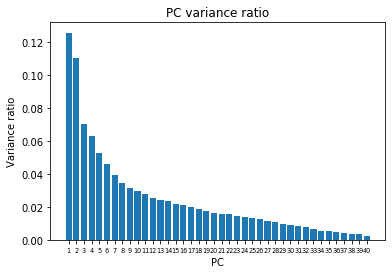

(76774, 40)
Performing tSNE on 10 PCs...
Done!


<Figure size 432x288 with 0 Axes>

In [18]:
nc_dimred = dimreduction(nc, numerical_features, n_pcs=40, plottitle='PC_variance_ratio_noncoding')

In [52]:
nc_dimred = pickle.load(open('../data/noncoding_dimred.pkl', 'rb'))

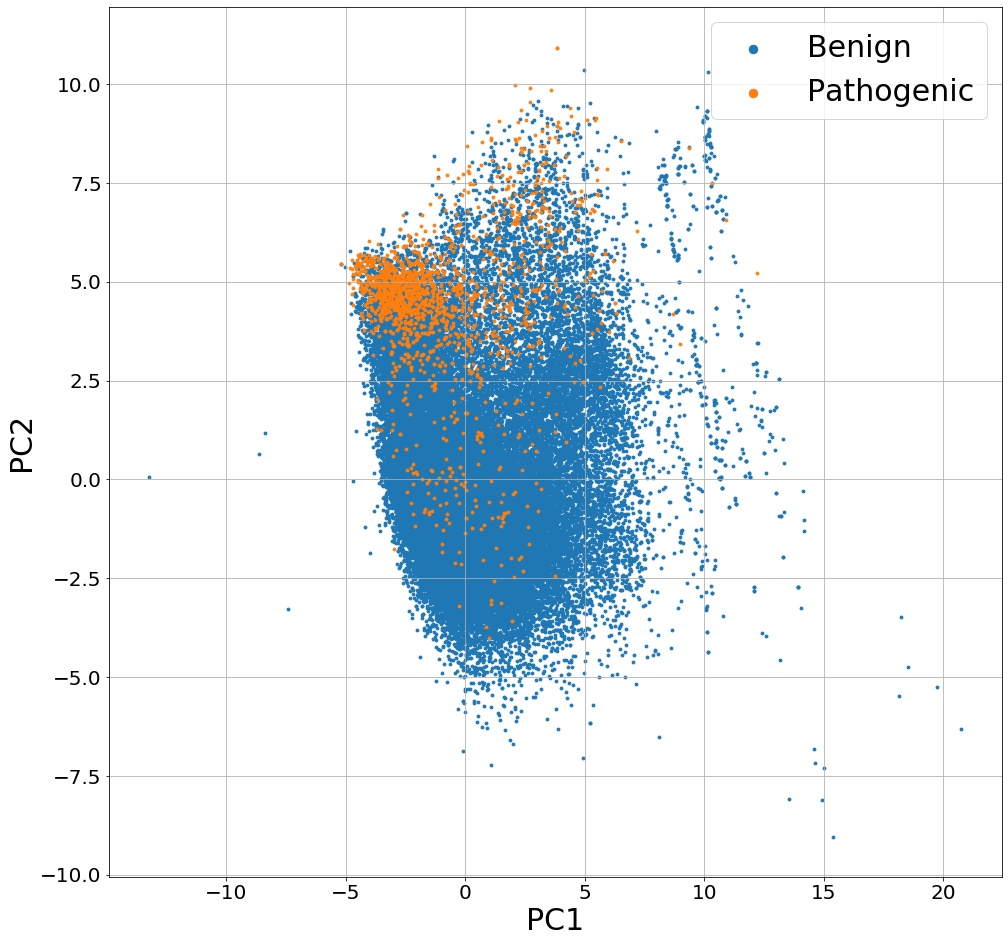

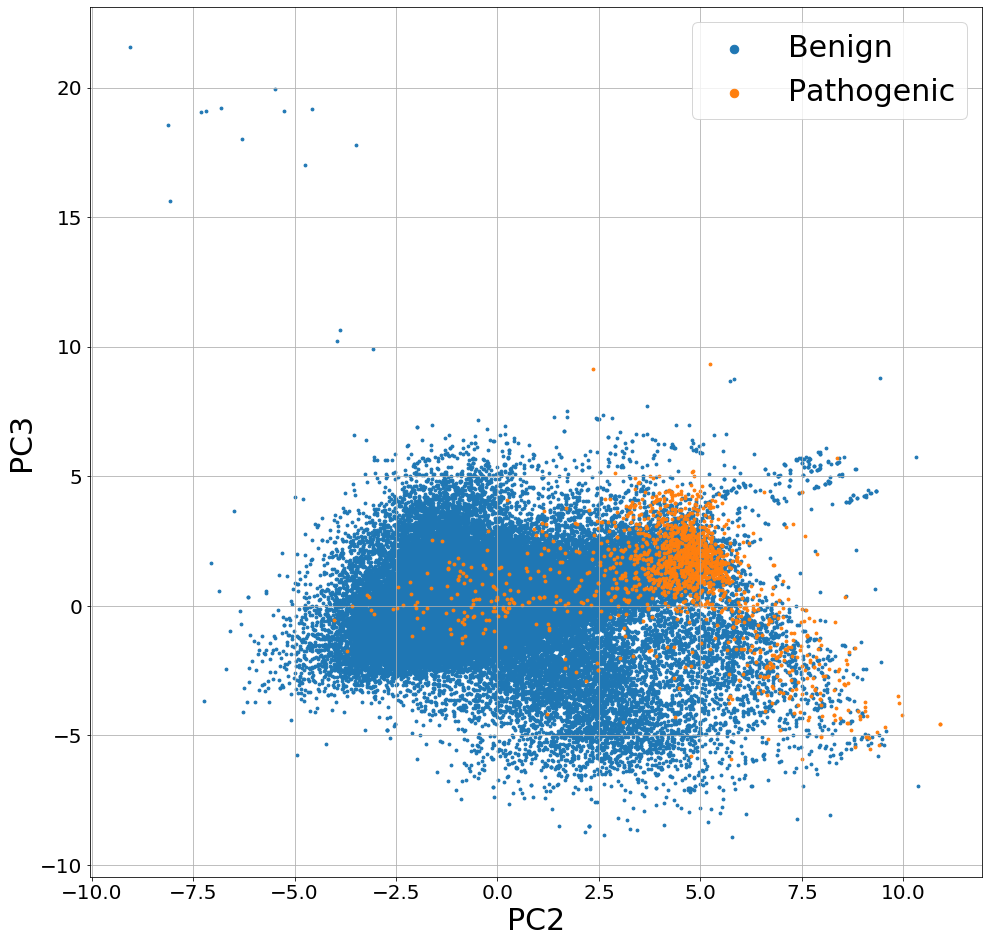

In [21]:
plot_scatter(nc_dimred, x='PC1', y='PC2', color_on='label', plottitle='PC1_PC2_noncoding')
plot_scatter(nc_dimred, x='PC2', y='PC3', color_on='label', plottitle='PC2_PC3_noncoding')

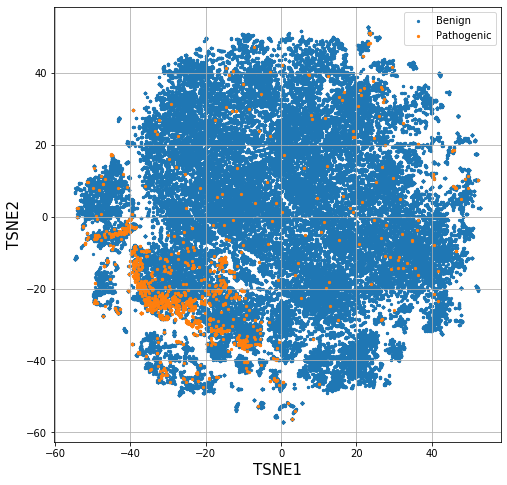

In [56]:
plot_scatter(nc_dimred, x='TSNE1', y='TSNE2', color_on='label', plottitle='TSNE_noncoding')

<h1>Feature violin plots</h1>

For each feature, plot the distribution per label and other categorical features. 

['verPhyloP', -61.68979448782635, 0.0]


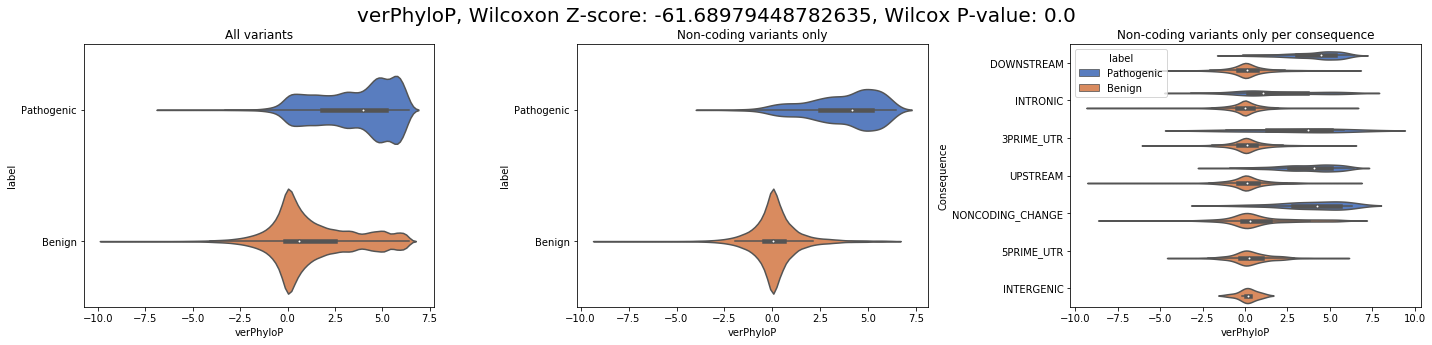

['verPhCons', -60.177601383580985, 0.0]


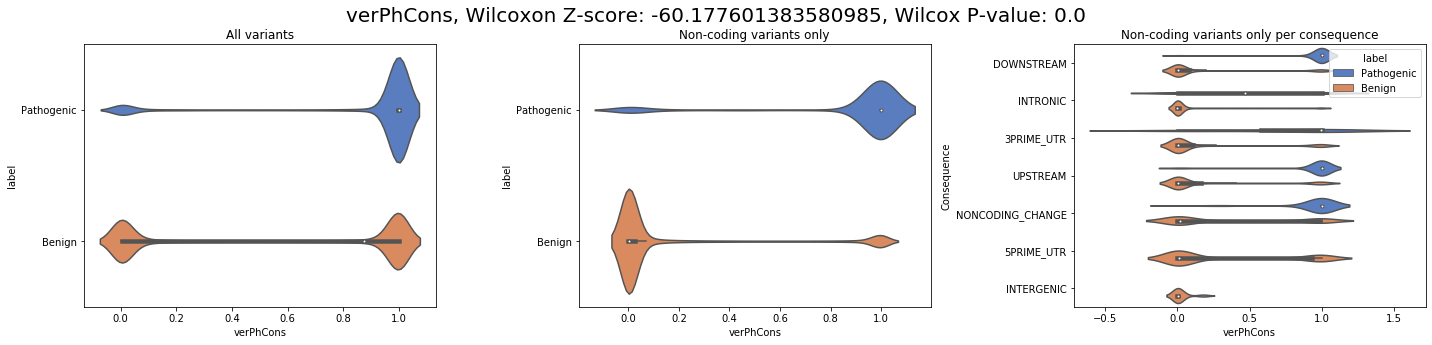

['GerpS', -59.7190462128915, 0.0]


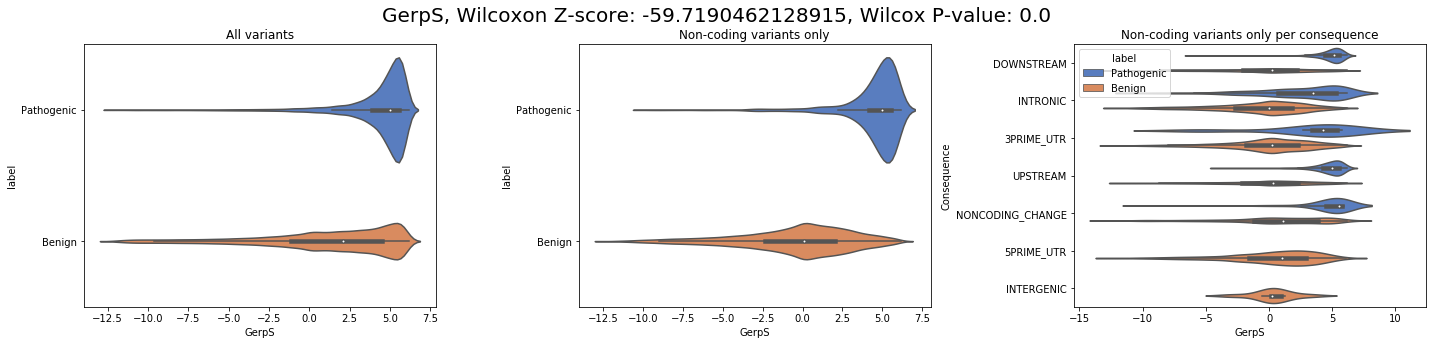

['mamPhyloP', -59.40222650045232, 0.0]


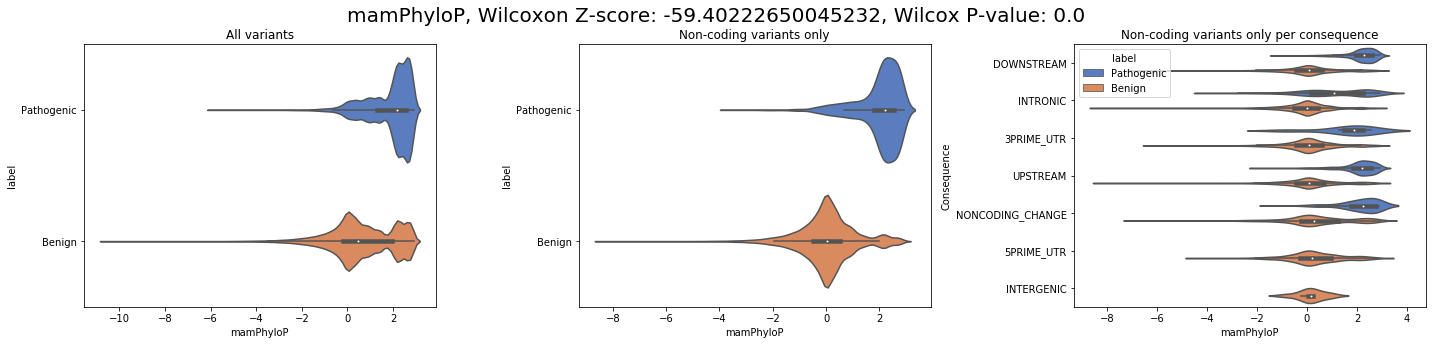

['mamPhCons', -58.8729171382691, 0.0]


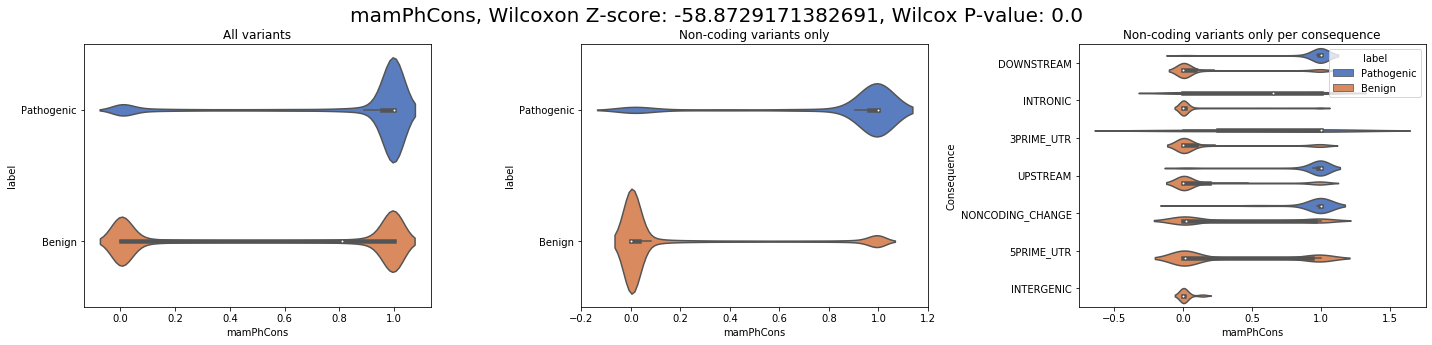

['priPhCons', -42.42345490103274, 0.0]


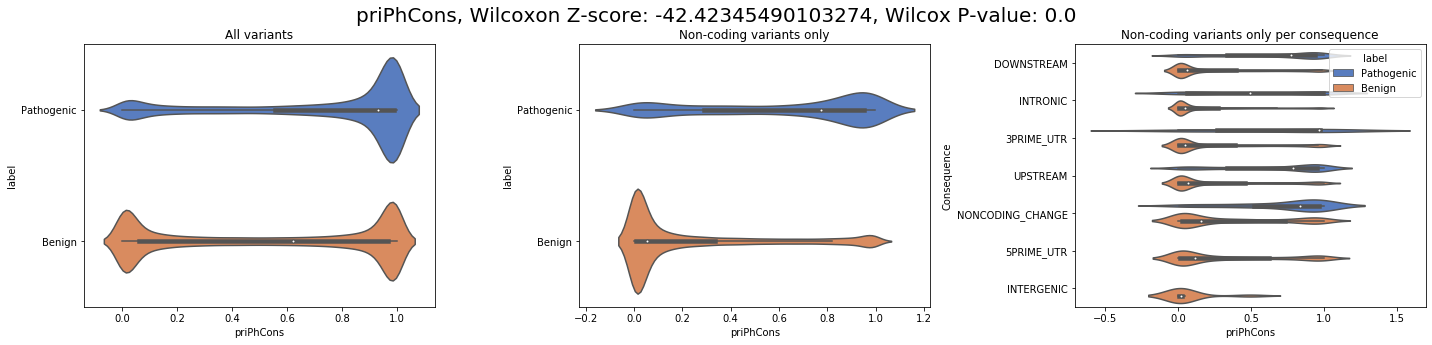

['priPhyloP', -32.9849747222161, 1.3340413085799866e-238]


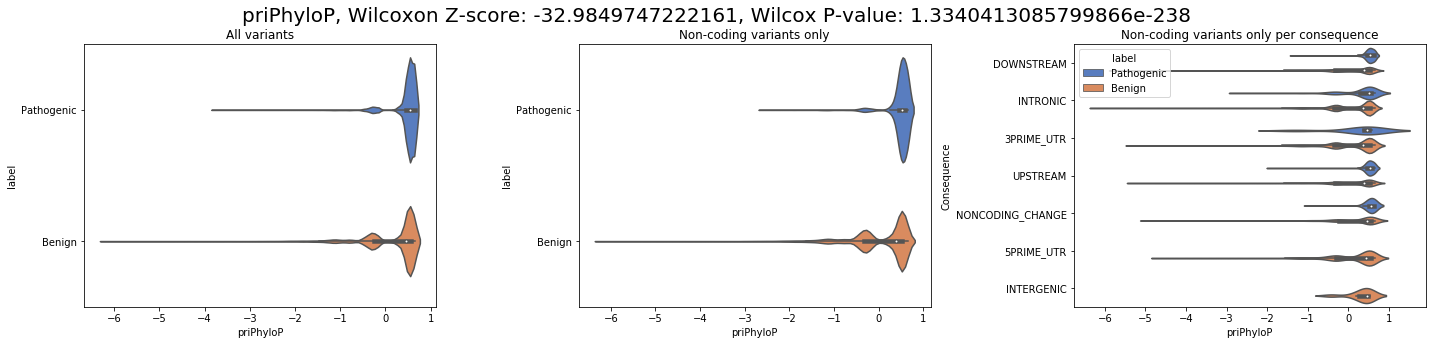

['GerpN', -30.379596195127323, 1.0218483948500876e-202]


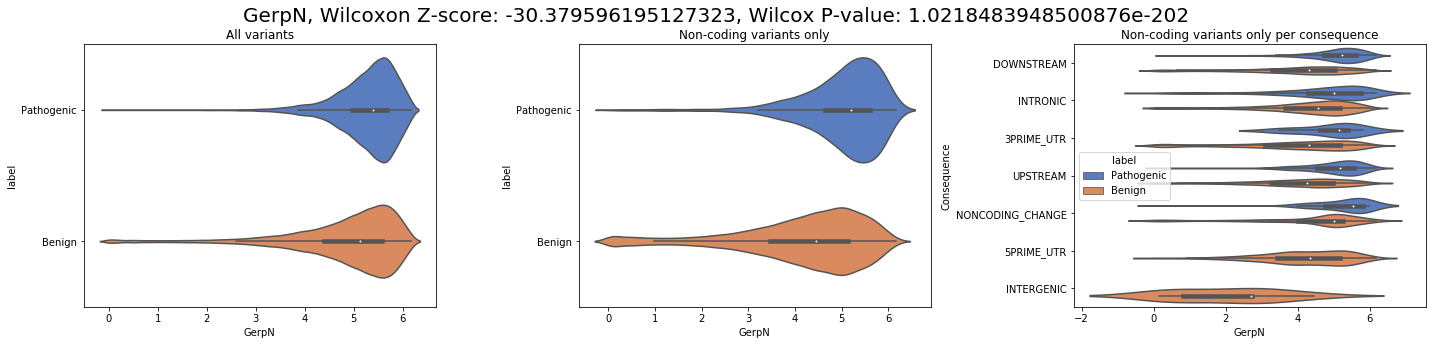

['minDistTSS', 20.249854321290428, 3.562920230209972e-91]


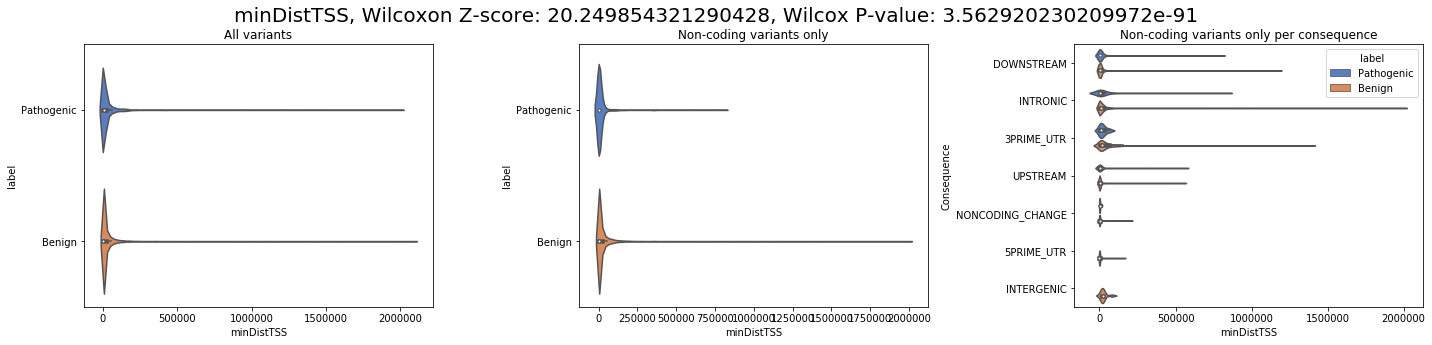

['cHmmQuies', 14.525836948901926, 8.312082680677146e-48]


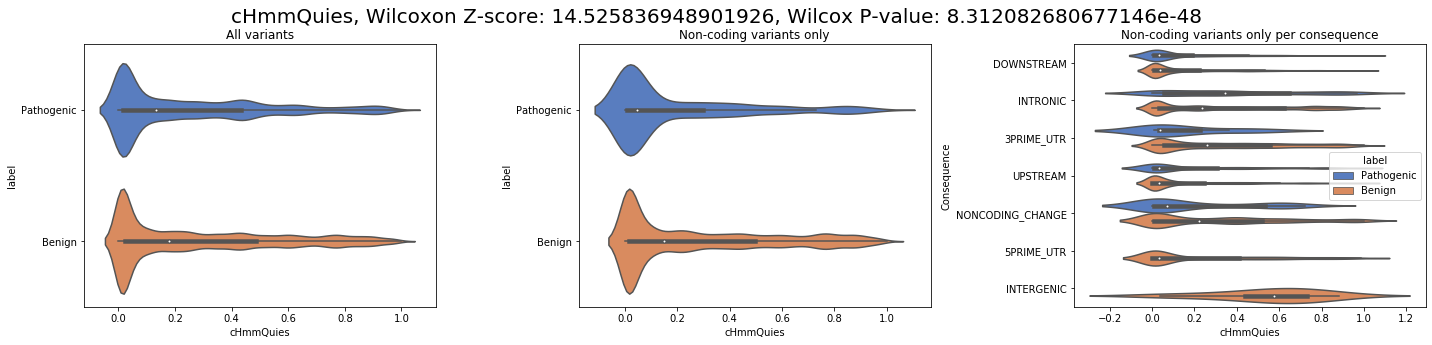

['CpG', -14.114425268222593, 3.095291224565843e-45]


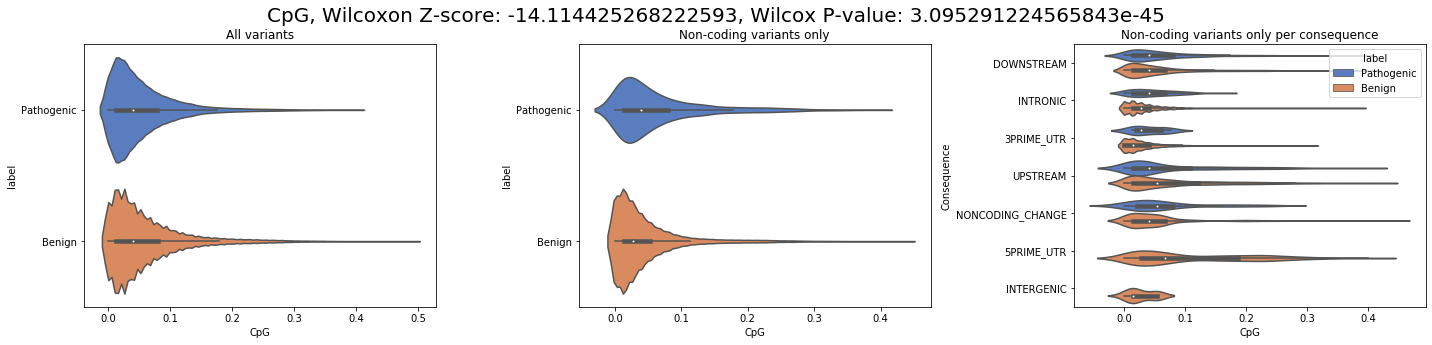

['GC', -13.697867231699071, 1.0455035954895845e-42]


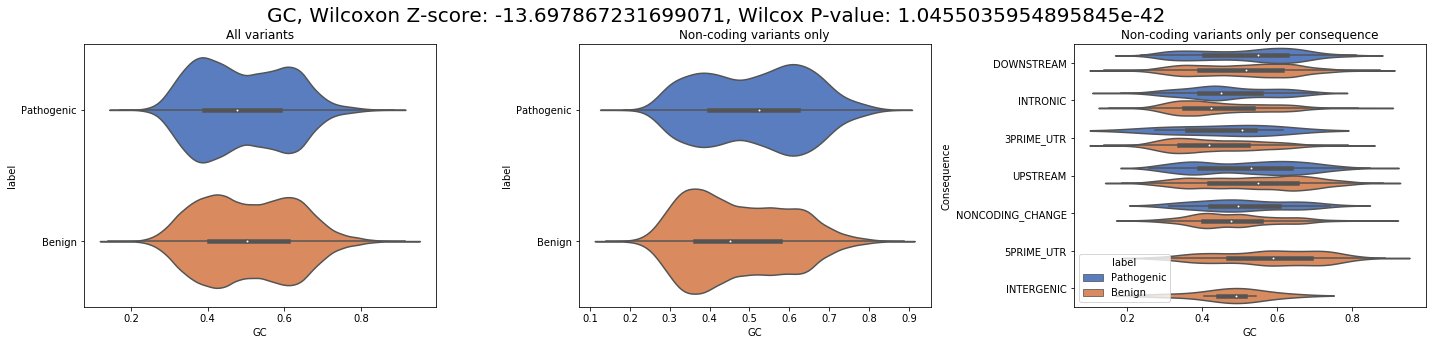

['EncH3K27Ac', -13.525579642598444, 1.1046946598432618e-41]


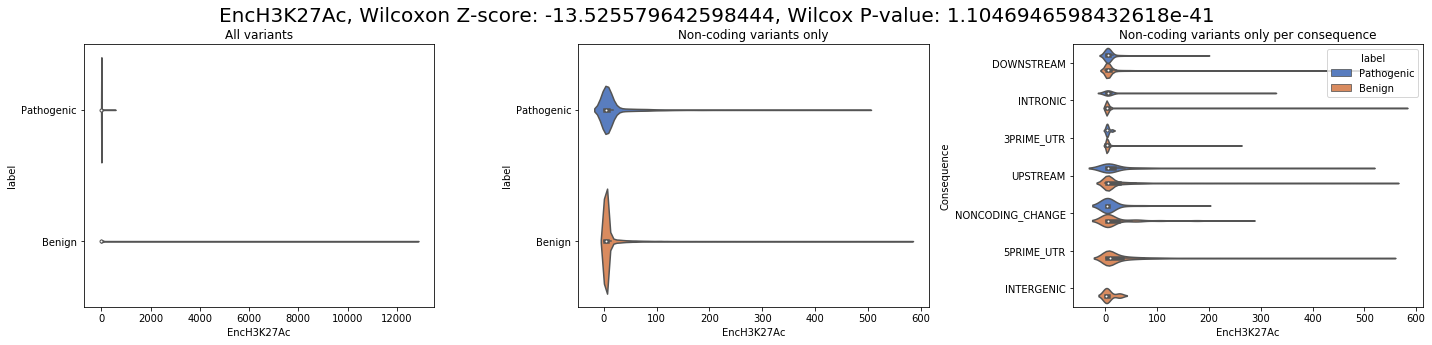

['cHmmTxFlnk', -9.734237763602646, 2.154266705183527e-22]


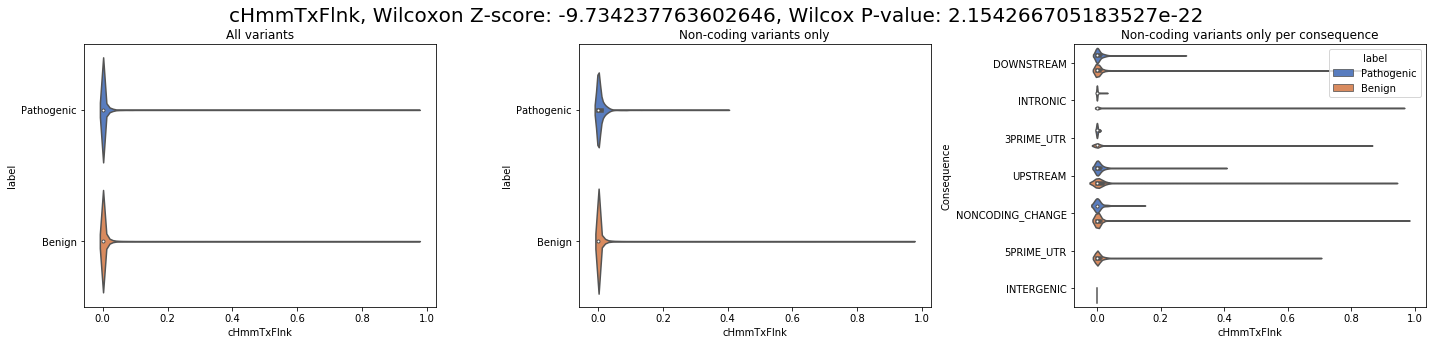

['cHmmReprPCWk', 9.083899336663334, 1.0475315915164627e-19]


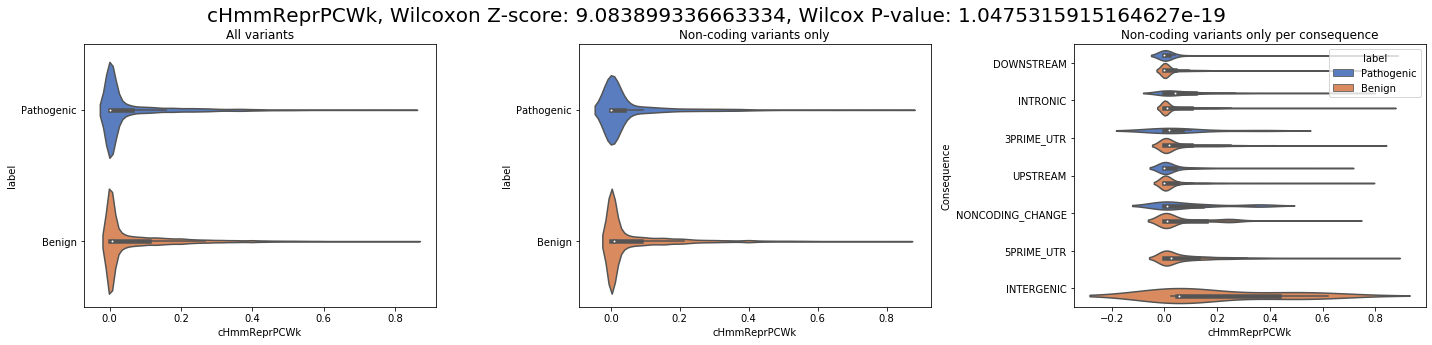

['Rare100bp', 9.048884126098342, 1.4443675224499218e-19]


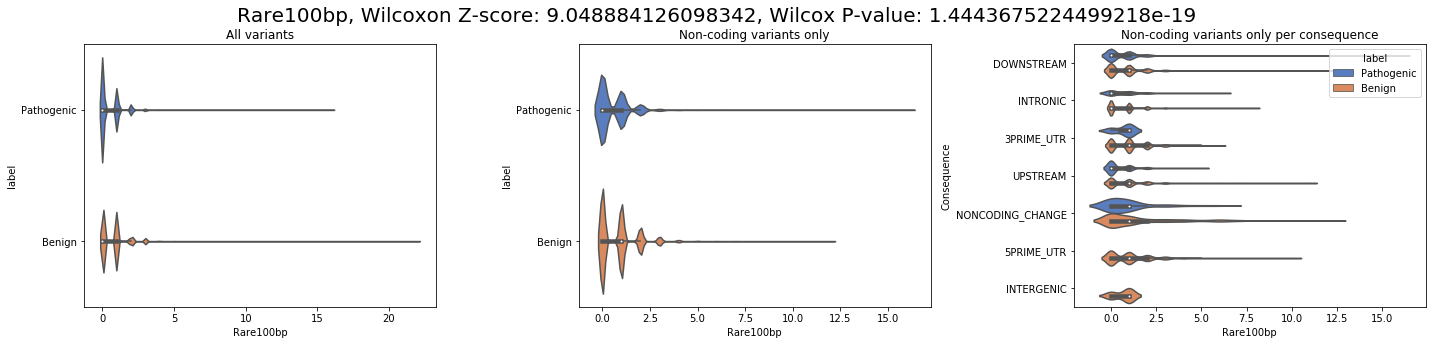

['Freq100bp', 8.861142091907839, 7.919884548678723e-19]


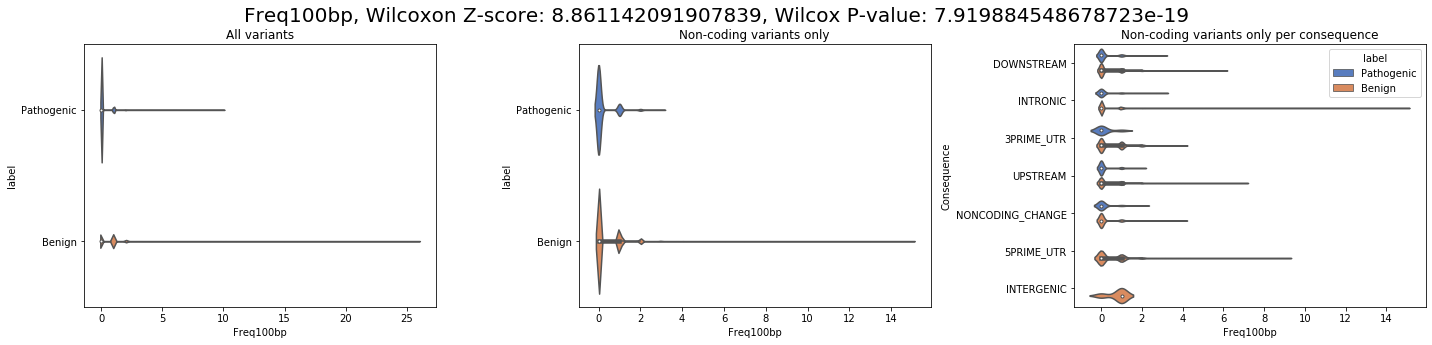

['EncH3K4Me1', -8.68513159618407, 3.7830416730835286e-18]


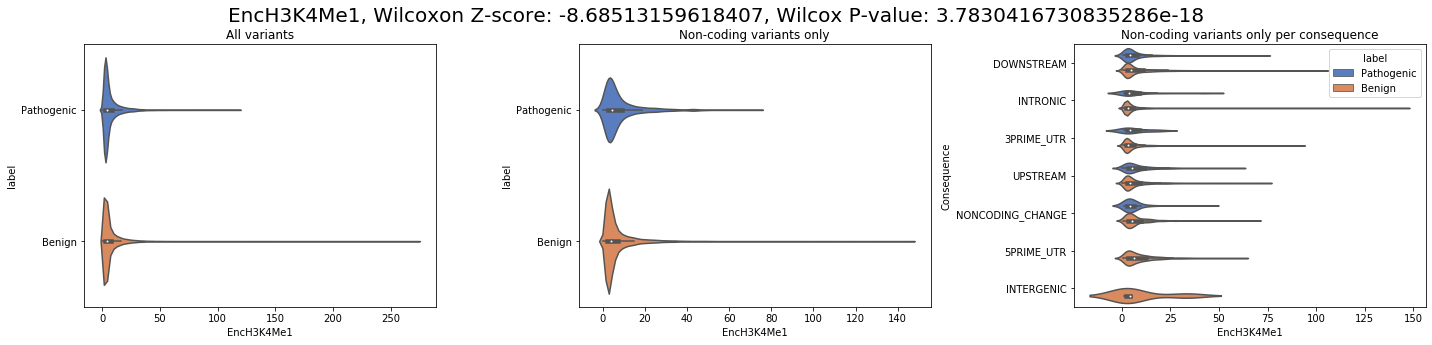

['minDistTSE', 8.502626645425847, 1.8534827565609317e-17]


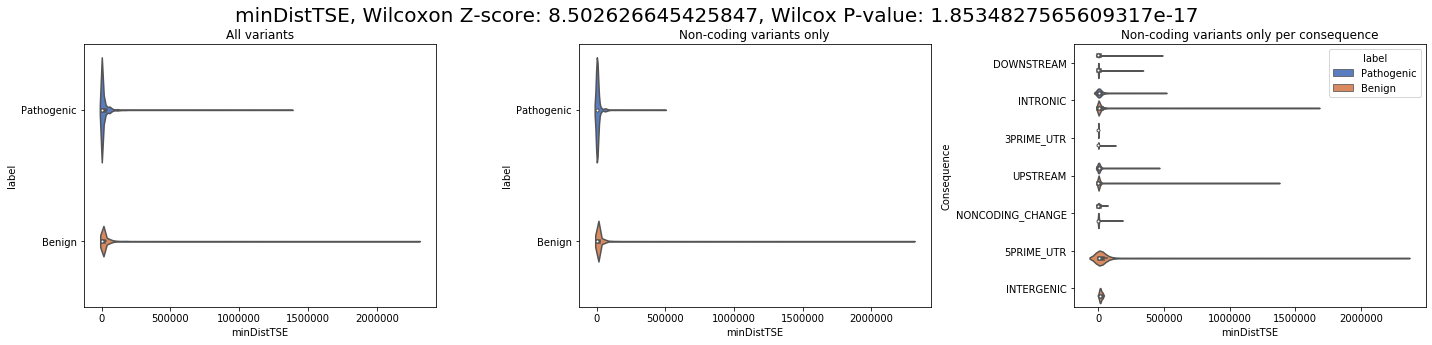

['cHmmTssA', -8.069288618372898, 7.070893713919135e-16]


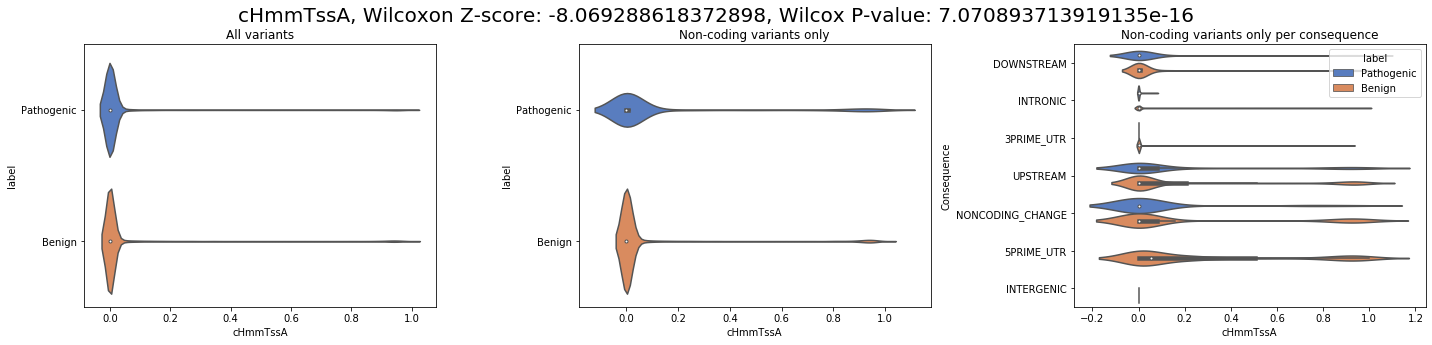

['Freq10000bp', 7.901817792804927, 2.7486502061570623e-15]


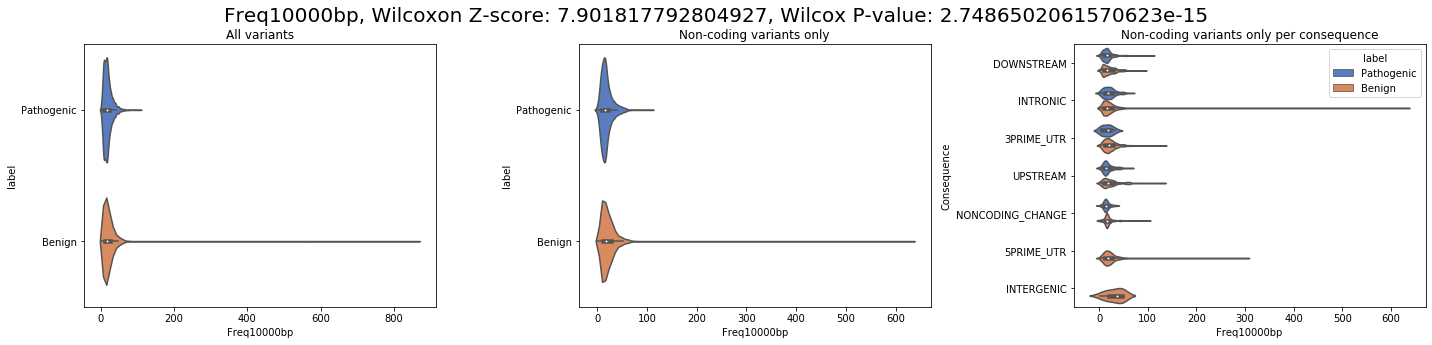

['EncH3K4Me3', -7.539086845280841, 4.732737249471715e-14]


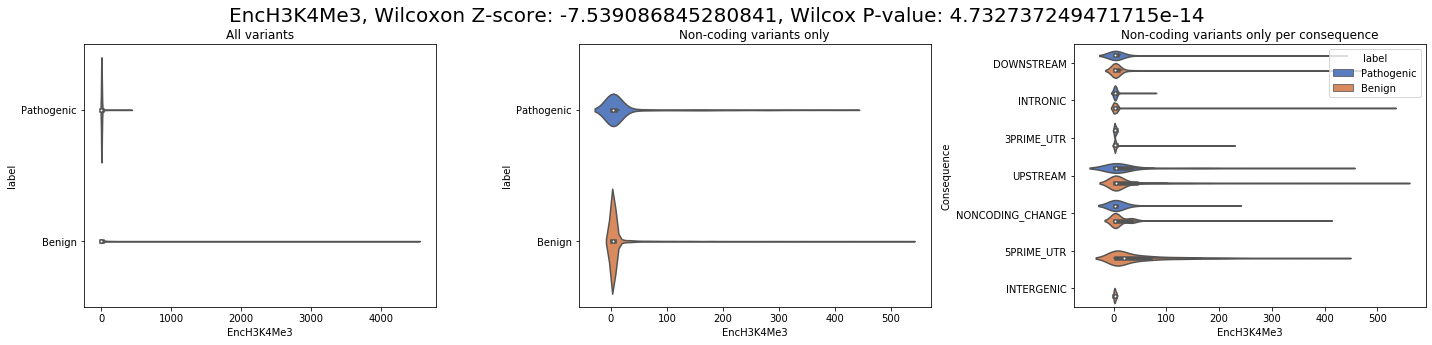

['cHmmTssAFlnk', -6.886405903778984, 5.7219577540074945e-12]


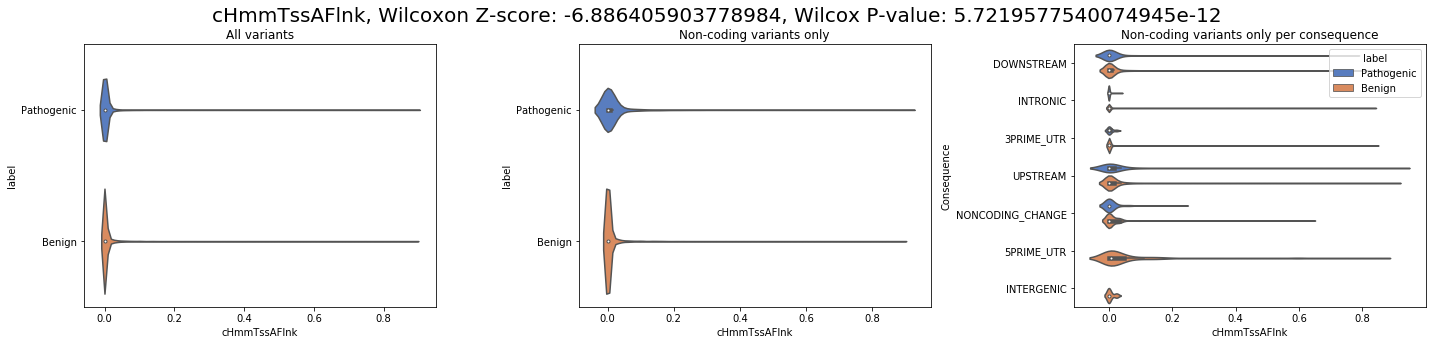

['Freq1000bp', 6.7420747138558665, 1.561407490869726e-11]


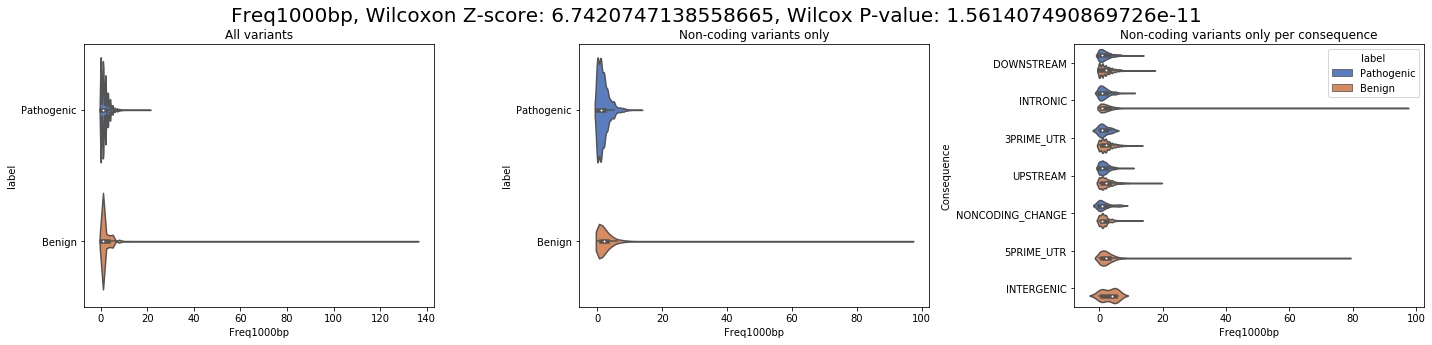

['Sngl10000bp', -6.4691476758129145, 9.855724165169096e-11]


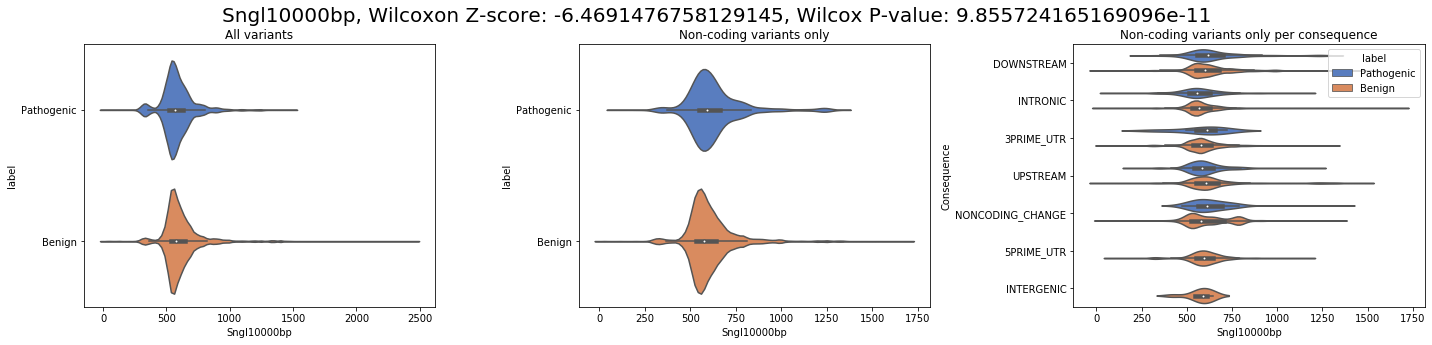

['bStatistic', 5.445612848434094, 5.162731927135912e-08]


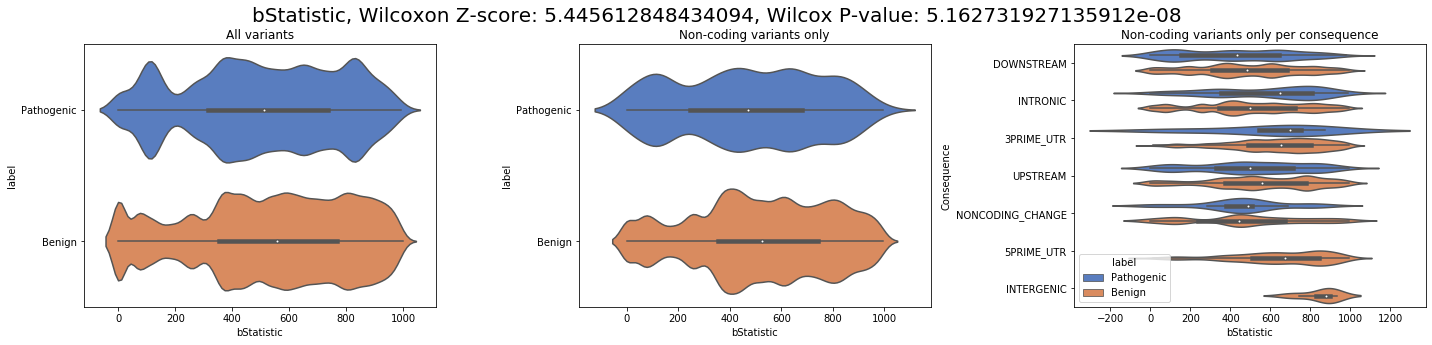

['Sngl1000bp', -5.021016962708105, 5.139861970987428e-07]


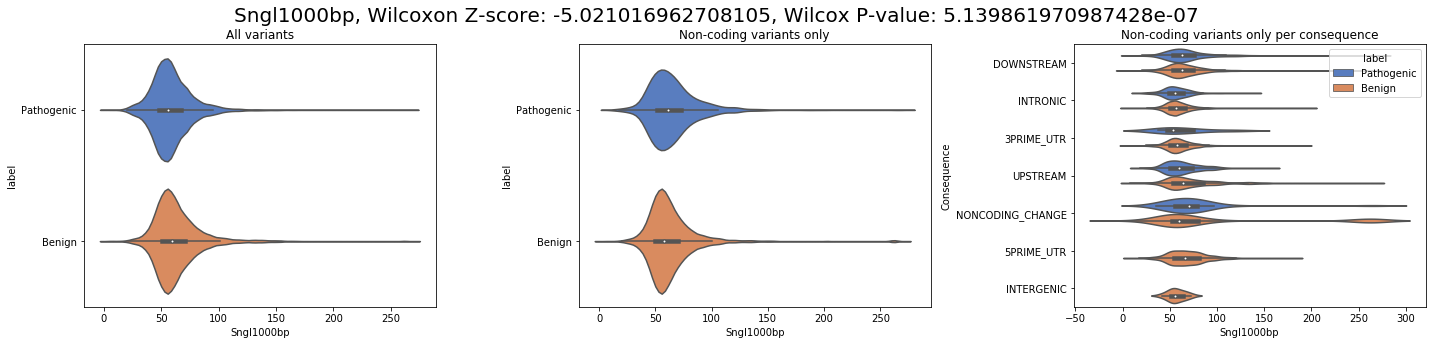

['cHmmEnhG', -4.678462908121757, 2.8903344143363896e-06]


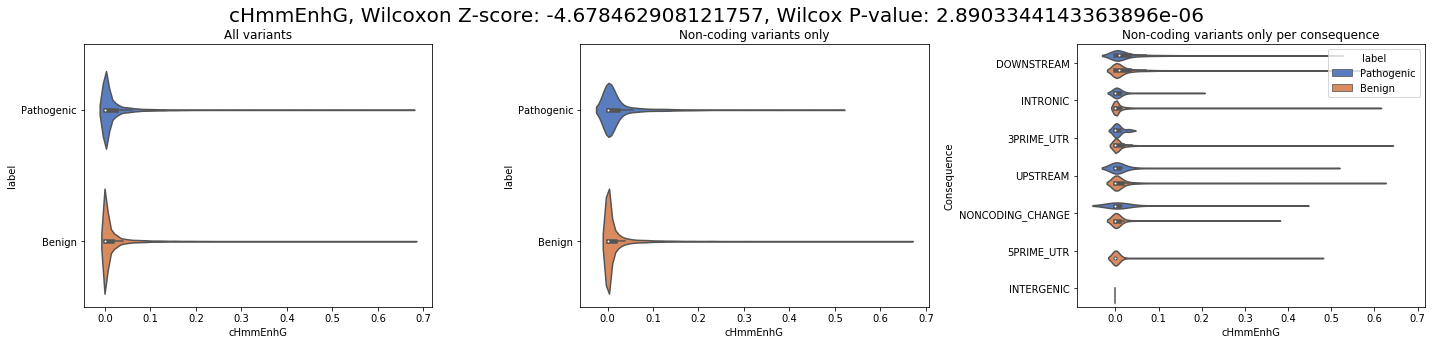

['cHmmTssBiv', -4.5165802868778275, 6.284629572228293e-06]


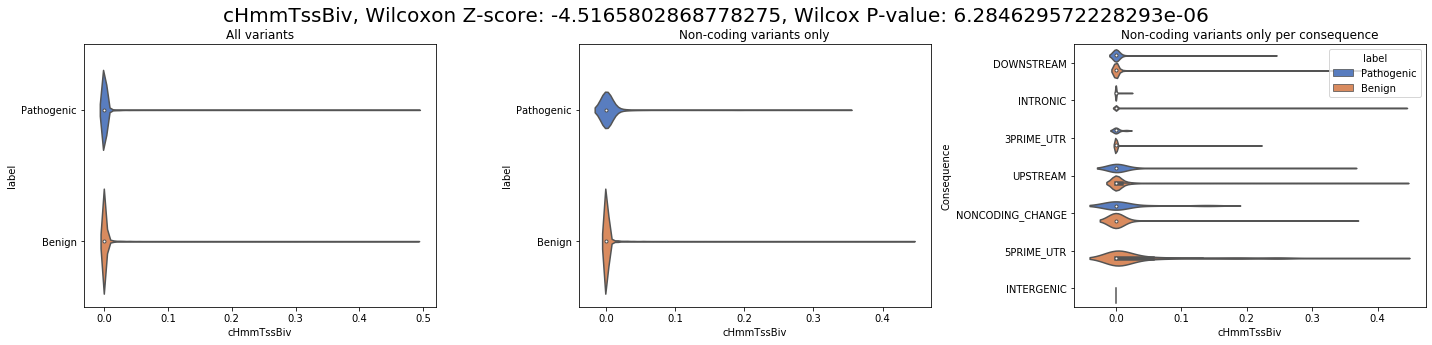

['cHmmReprPC', 3.6347665653625016, 0.00027823244645702906]


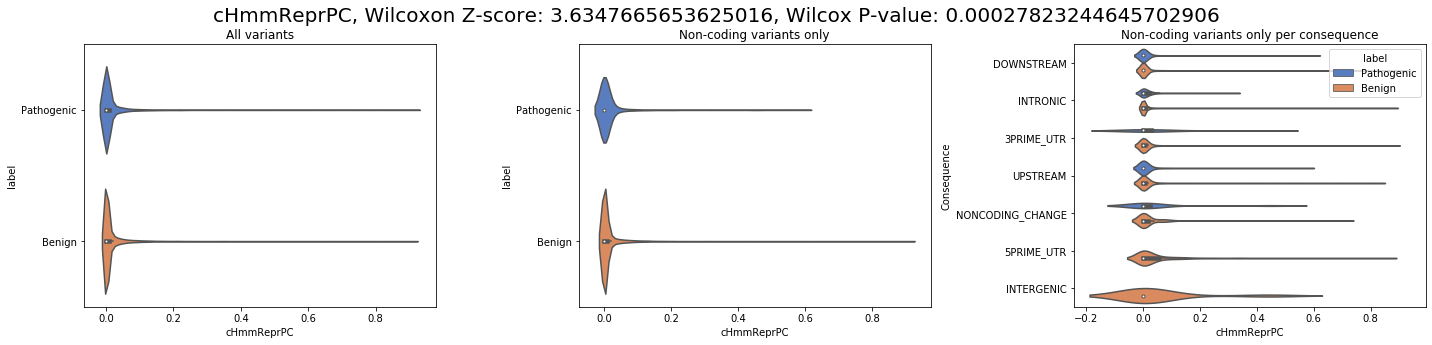

['Rare1000bp', 3.3975482657189255, 0.0006799259266983793]


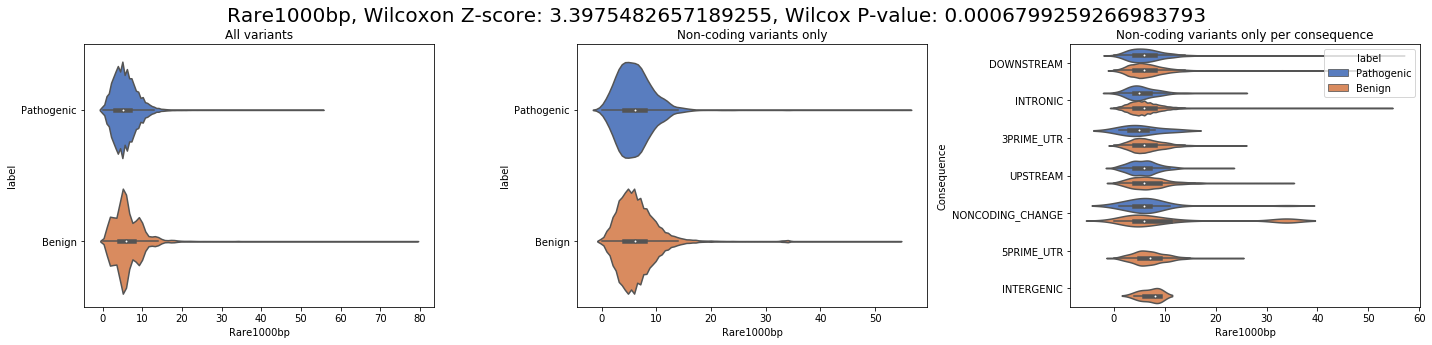

['Rare10000bp', 2.895866735572167, 0.0037811293299725417]


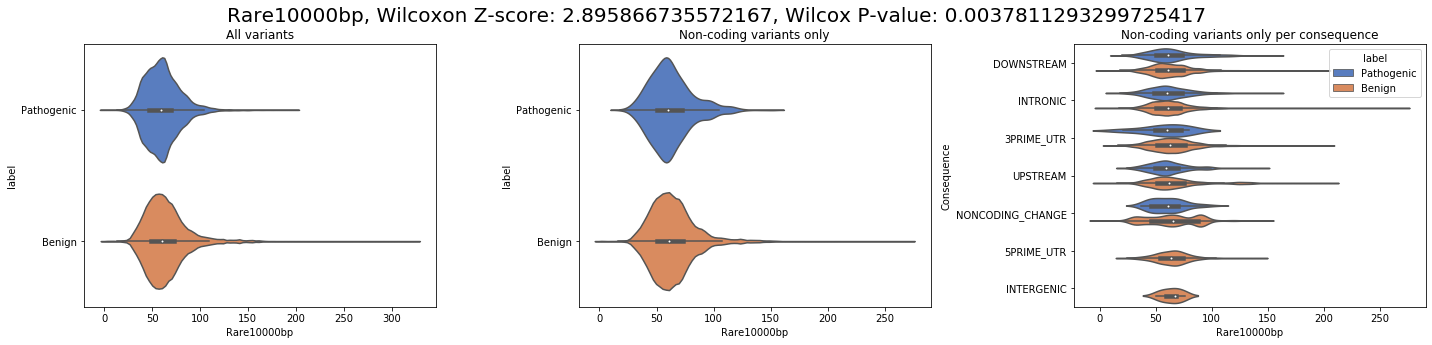

['cHmmHet', 2.859226629785452, 0.0042467526937250725]


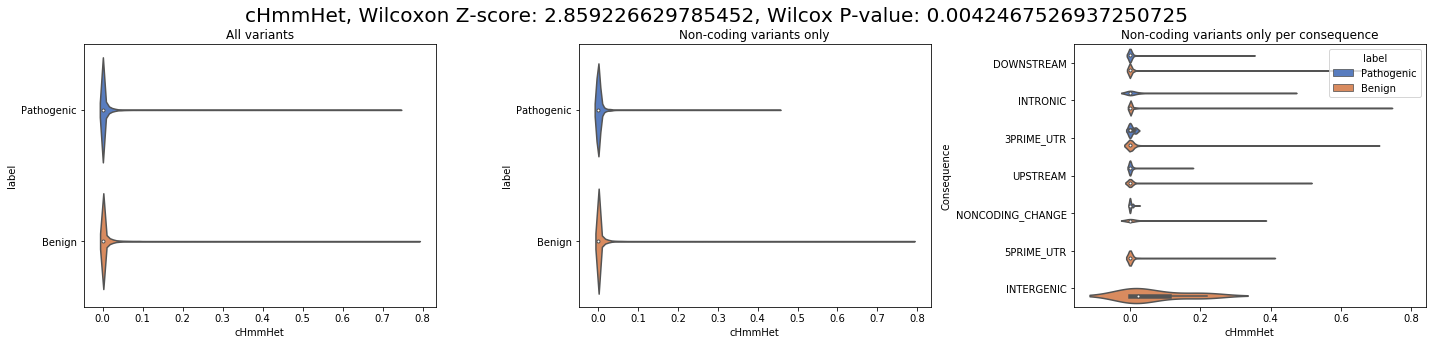

['EncNucleo', -2.851586546731899, 0.00435016421765719]


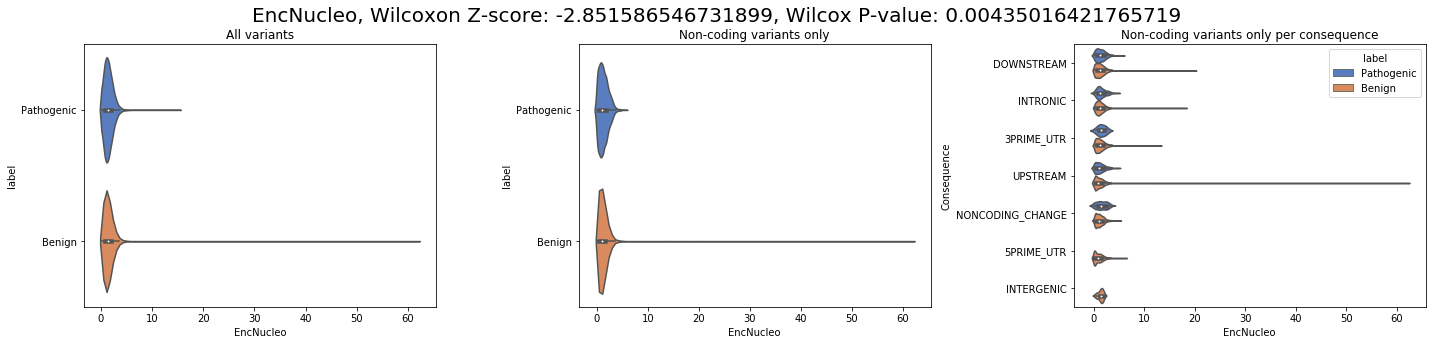

['Sngl100bp', -2.5791910595864005, 0.00990319964288722]


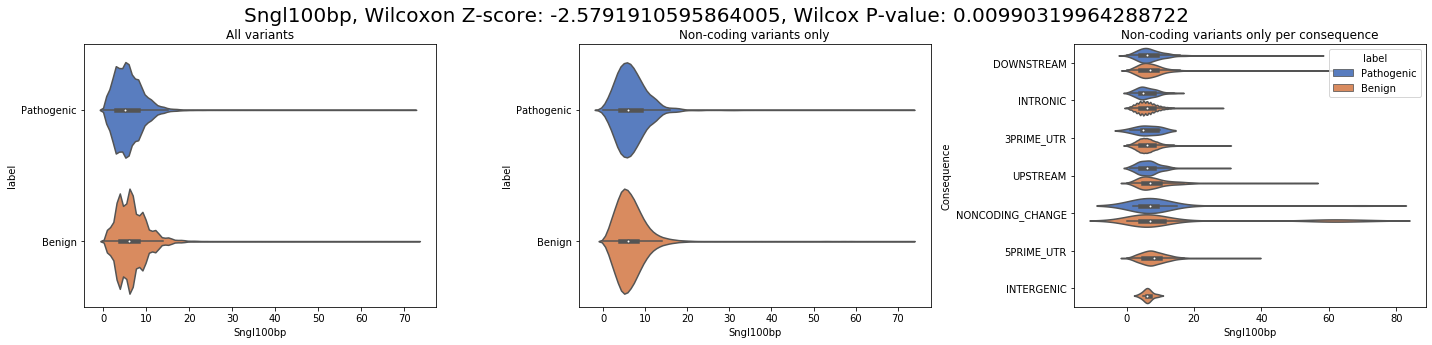

['cHmmTx', -1.8495264781272205, 0.0643818280793303]


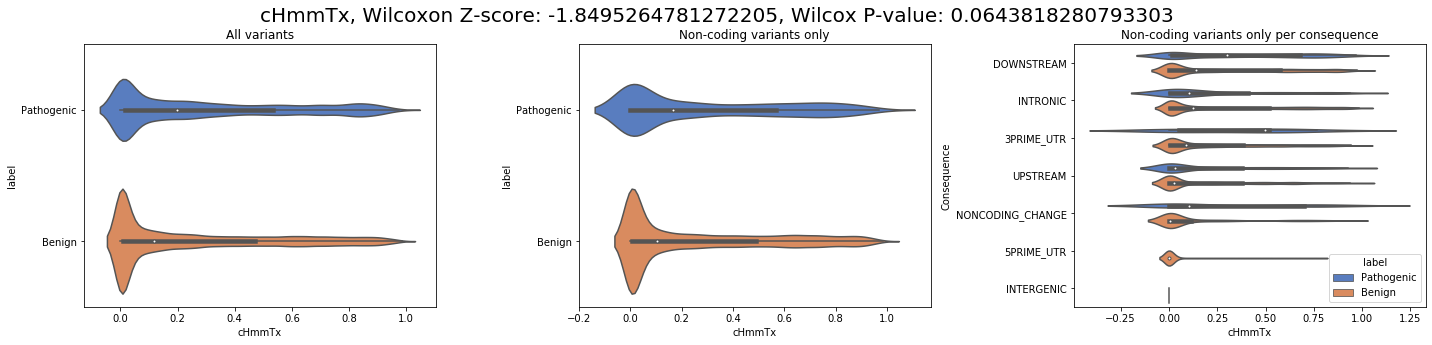

['cHmmBivFlnk', -1.698383030318714, 0.08943549281068777]


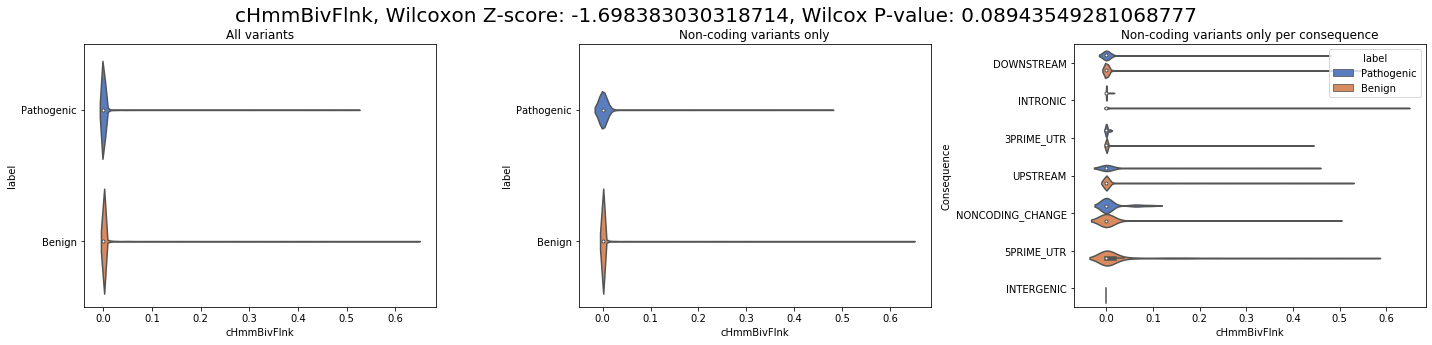

['Dist2Mutation', -1.6386407076099176, 0.10128810916843103]


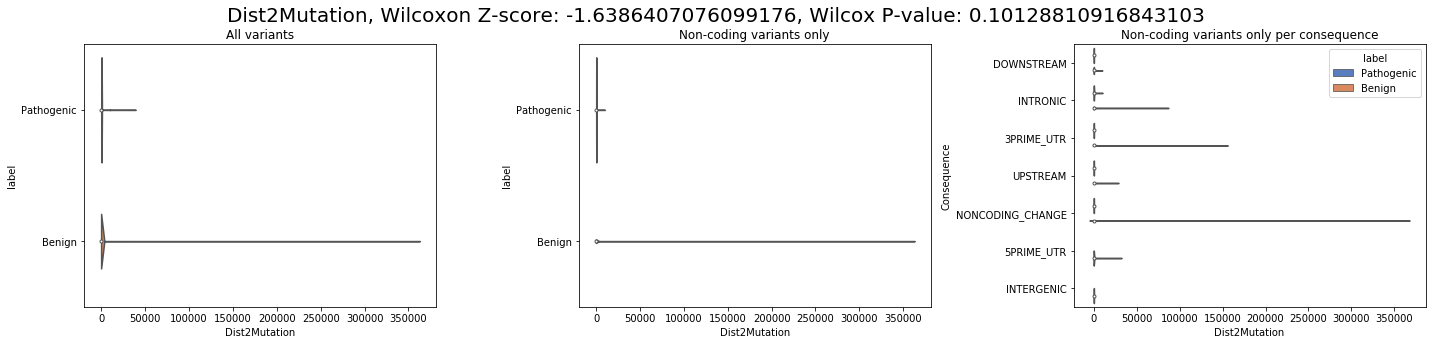

['cHmmEnh', -1.6323041288304465, 0.10261543389404838]


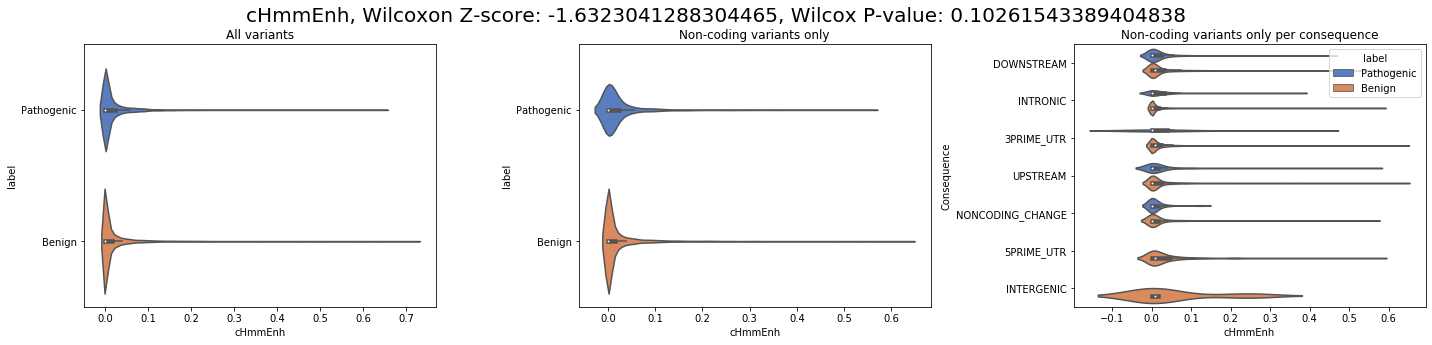

['cHmmEnhBiv', -1.536579347202275, 0.12439635328052025]


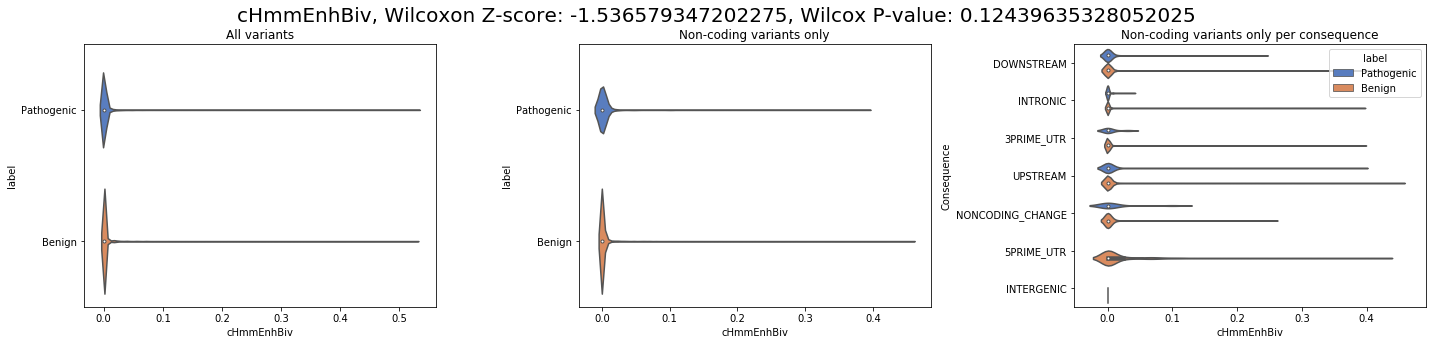

['Length', 0.9619430971116736, 0.33607818830702574]


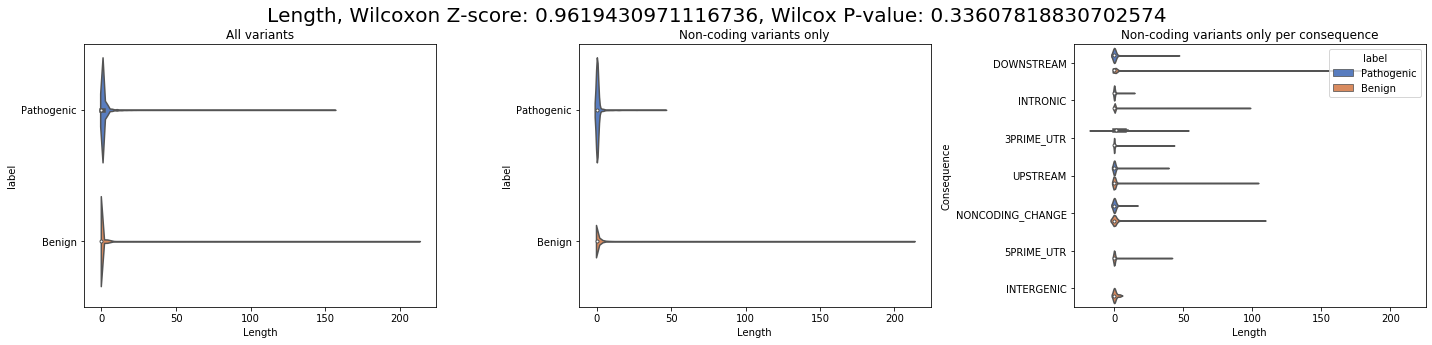

['cHmmZnfRpts', -0.6525712482597593, 0.5140327263585036]


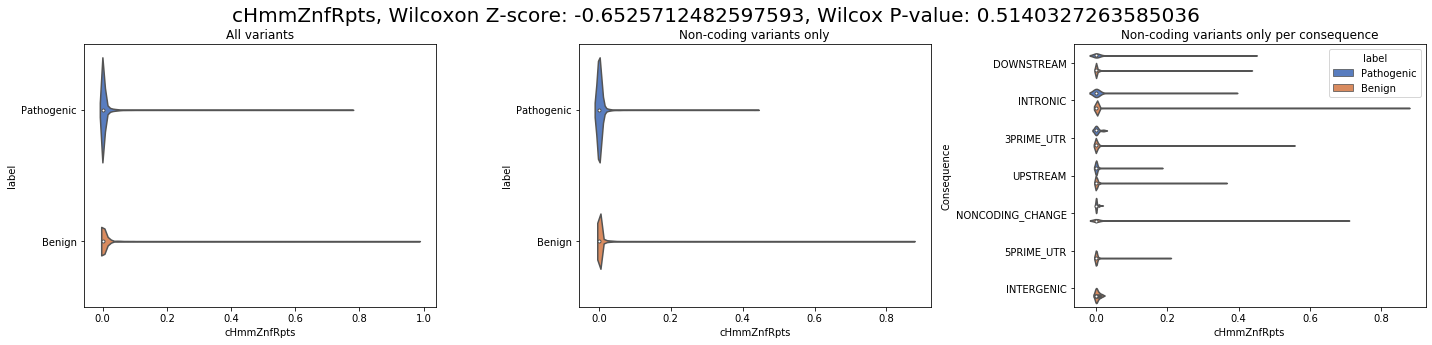

['cHmmTxWk', -0.5473523627524935, 0.5841366761602784]


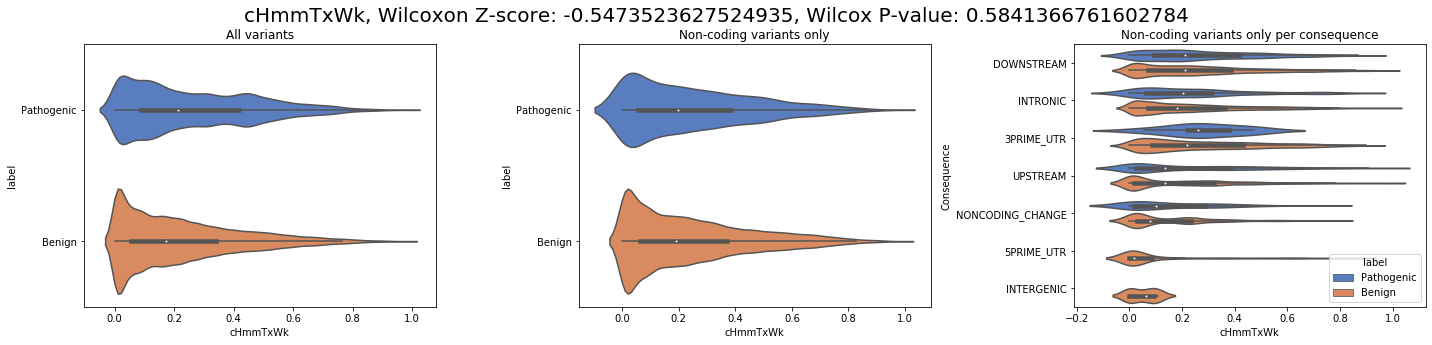

In [626]:
#perform Wilcoxon test for each feature between the benign and pathogenic variants so the plots can be sorted on importance.
l = []
for feature in numerical_features:
    w = scipy.stats.ranksums(x=nc.loc[nc['label'] == 'Benign'][feature].tolist(), y=nc.loc[nc['label'] == 'Pathogenic'][feature].tolist())
    l.append([feature, w[0], w[1]])

l = sorted(l, key=lambda x: abs(x[1]), reverse=True)

for feature in l:
    print(feature)
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))
    sns.violinplot(x=feature[0], y="label", data=train, palette="muted", ax=ax0)
    sns.violinplot(x=feature[0], y="label", data=nc, palette="muted", ax=ax1)
    sns.violinplot(x=feature[0], y="Consequence", hue="label", data=nc, palette="muted", ax=ax2)
    #sns.violinplot(x=feature[0], y="Type", hue="label", data=nc, palette="muted", ax=ax3)
    
    ax0.set_title('All variants')
    ax1.set_title('Non-coding variants only')
    ax2.set_title('Non-coding variants only per consequence')
    #ax3.set_title('Non-coding variants only per type')
    
    fig.tight_layout()
    fig.suptitle('{}, Wilcoxon Z-score: {}, Wilcox P-value: {}'.format(feature[0], feature[1], feature[2], 4), fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    #plt.savefig('../figures/data_exploration/violinplots_nc/{}_{}.png'.format(abs(round(feature[1], 2)), feature[0]), bbox_inches='tight')
    plt.show()

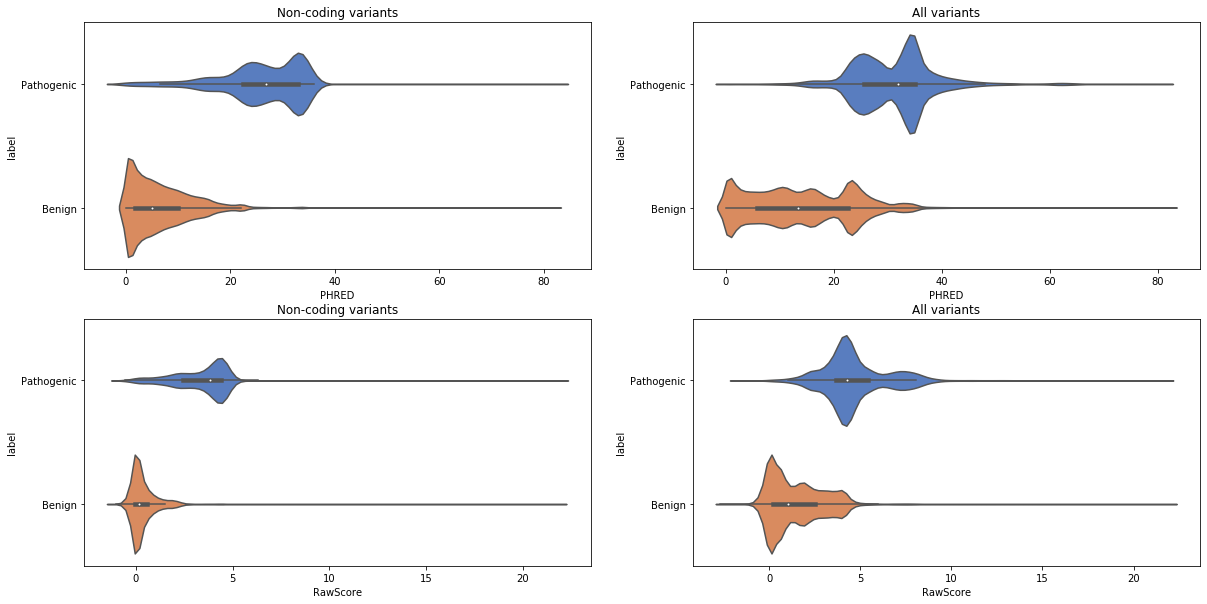

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
sns.violinplot(x='PHRED', y="label", data=nc, palette="muted", ax=ax1)
sns.violinplot(x='PHRED', y="label", data=train, palette="muted", ax=ax2)
sns.violinplot(x='RawScore', y="label", data=nc, palette="muted", ax=ax3)
sns.violinplot(x='RawScore', y="label", data=train, palette="muted", ax=ax4)

ax1.set_title('Non-coding variants')
ax2.set_title('All variants')
ax3.set_title('Non-coding variants')
ax4.set_title('All variants')
plt.savefig('../figures/data_exploration/CADD_scores.png')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
sns.violinplot(x='PHRED', y="label", data=nc, palette="muted", ax=ax1)
sns.violinplot(x='PHRED', y="label", data=train, palette="muted", ax=ax2)
sns.violinplot(x='RawScore', y="label", data=nc, palette="muted", ax=ax3)
sns.violinplot(x='RawScore', y="label", data=train, palette="muted", ax=ax4)

ax1.set_title('Non-coding variants')
ax2.set_title('All variants')
ax3.set_title('Non-coding variants')
ax4.set_title('All variants')
plt.savefig('../figures/data_exploration/CADD_scores.png')

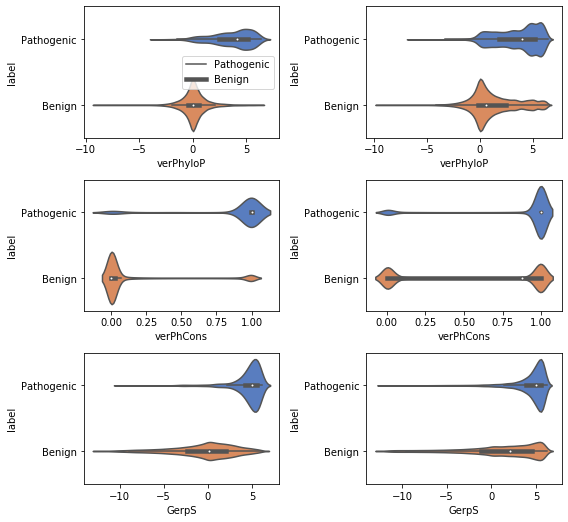

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

sns.violinplot(x='verPhyloP', y="label", data=nc, palette="muted", ax=ax1)
sns.violinplot(x='verPhyloP', y="label", data=train, palette="muted", ax=ax2)

sns.violinplot(x='verPhCons', y="label", data=nc, palette="muted", ax=ax3)
sns.violinplot(x='verPhCons', y="label", data=train, palette="muted", ax=ax4)

sns.violinplot(x='GerpS', y="label", data=nc, palette="muted", ax=ax5)
sns.violinplot(x='GerpS', y="label", data=train, palette="muted", ax=ax6)

ax1.legend(['Pathogenic', 'Benign'], markerscale=3)

# ax1.set_title('Non-coding variants')
# ax2.set_title('All variants')
# ax3.set_title('Non-coding variants')
# ax4.set_title('All variants')
# ax5.set_title('Non-coding variants')
# ax6.set_title('All variants')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('../figures/data_exploration/thesis_design/violinplots.png')

Are the SNPs from Smedley2016 (453 SNPs) in our dataset?

In [10]:
smedley2016 = pd.read_csv('../files/ReMM/mmc2_combined.txt', sep='\t')

In [11]:
smedley2016['Chrom'] = smedley2016['Chr'].apply(lambda x: x[3:])
smedley2016.head()

Chr   Position Ref Alt        OMIM   Gene      PMID Mutation_type  \
0  chr1   21890663   G   A  MIM 241500   ALPL  10679946      enhancer   
1  chr1  209989478   C  CA  MIM 119300   IRF6  24442519      enhancer   
2  chr2  219524871   A   G  MIM 124000  BCS1L  19389488      enhancer   
3  chr7  156061506   C   T  MIM 142945    SHH  18836447      enhancer   
4  chr7  156583831   T   C  MIM 174500    SHH  17152067      enhancer   

  Annotations Chrom  
0         NaN     1  
1         NaN     1  
2         NaN     2  
3         NaN     7  
4         NaN     7

In [12]:
snp_intersection = pd.merge(train, smedley2016,  how='inner', left_on=['#Chrom','Pos', 'Alt'], right_on = ['Chrom','Position', 'Alt'])

In [13]:
snp_intersection.shape

(32, 161)

In [14]:
snp_intersection[['label', '#Chrom', 'Pos','Alt', 'Ref_x', 'Ref_y', 'PMID', 'source', 'CCDS', 'ConsDetail', 'Mutation_type', 'AnnoType', 'Consequence', 'Gene', 'sample_weight']]

label #Chrom        Pos Alt Ref_x Ref_y      PMID   source  \
0   Pathogenic     19   49468602   A   AAC   AAC  12730114     vkgl   
1   Pathogenic      1  228337561   G     A     A  20695017  clinvar   
2   Pathogenic     11   46761055   A     G     G   8916933  clinvar   
3   Pathogenic      9  130616761   A     G     G  22192717  clinvar   
4   Pathogenic     11   47470726   C     T     T  12651869  clinvar   
5   Pathogenic      2  122288485   A     G     G  21474760  clinvar   
6   Pathogenic      2  122288503   A     G     G  26522830  clinvar   
7   Pathogenic      9   35657773   C     T     T  16244706  clinvar   
8   Pathogenic      9   35657952   A     G     G  16244706  clinvar   
9   Pathogenic      9   35657945   C     T     T  11207361  clinvar   
10  Pathogenic     19   11200086   G     C     C  17625505  clinvar   
11  Pathogenic     19   11200086   C    CT    CT  14616764  clinvar   
12  Pathogenic     11    5246715   C     T     T   1374896  clinvar   
13  Pathogenic     11    5246717   C     T     T   1856830  clinvar   
14  Pathogenic     11    5248280   T     C     C   1536956  clinvar   
15  Pathogenic     16     223690   T   TAA   TAA  26193977  clinvar   
16  Pathogenic     16     223693   G     A     A  11480787  clinvar   
17  Pathogenic     16     223691   G     A     A   1581238  clinvar   
18  Pathogenic     11    5246718   G     A     A   4018033  clinvar   
19  Pathogenic     19   11200073   T     C     C  10484771  clinvar   
20      Benign      5  176836585   G     C     C  18832903  clinvar   
21      Benign      8   19796671   G     T     T   9017514  clinvar   
22      Benign      X  103031893   T     C     C   8723686  clinvar   
23      Benign      5  176836590   A     G     G  18832903  clinvar   
24      Benign     12   15130918   C     G     G  15629837  clinvar   
25      Benign      2   71913729   A     T     T  16705711  clinvar   
26      Benign      6  118869423   C     A     A  18241046  clinvar   
27      Benign      X  153991099   G     C     C  11379875  unknown   
28      Benign      9  130616643   T     C     C  22192717  unknown   
29      Benign      2  122288501   A     G     G  25735804  clinvar   
30      Benign      1   91382343   C     G     G  21695231  unknown   
31      Benign      3  169482592   T     C     C  25346280  unknown   

           CCDS       ConsDetail Mutation_type             AnnoType  \
0   CCDS12744.1       downstream          5UTR           Intergenic   
1   CCDS55689.1       downstream      promotor           Intergenic   
2   CCDS31477.1       downstream          3UTR           Intergenic   
3           NaN       regulatory          5UTR    RegulatoryFeature   
4           NaN       regulatory          5UTR    RegulatoryFeature   
5           NaN  non_coding_exon      RNA_gene  NonCodingTranscript   
6           NaN  non_coding_exon      RNA_gene  NonCodingTranscript   
7    CCDS6584.2       downstream      RNA_gene           Intergenic   
8    CCDS6584.2       downstream      RNA_gene           Intergenic   
9    CCDS6584.2       downstream      enhancer           Intergenic   
10          NaN       regulatory          5UTR    RegulatoryFeature   
11          NaN       regulatory          5UTR    RegulatoryFeature   
12          NaN         upstream          3UTR           Intergenic   
13          NaN         upstream          3UTR           Intergenic   
14          NaN         upstream          5UTR           Intergenic   
15          NaN       downstream          3UTR           Intergenic   
16          NaN       downstream          3UTR           Intergenic   
17          NaN       downstream          3UTR           Intergenic   
18          NaN         upstream          3UTR           Intergenic   
19          NaN       regulatory      promotor    RegulatoryFeature   
20  CCDS34302.1         upstream      promotor           Intergenic   
21   CCDS6012.1      5_prime_UTR          5UTR           Transcript   
22  CCDS14513.1      5_prime_UTR

In [206]:
#consequence == noncoding_change, upstream, downstream, intergenic, intronic, 5'utr, 3'utr
vgkl
#try out more annotations tools
#annovar, snpf, vep
# 
#percentage pathogenic
c = snp_intersection['label'].value_counts()
print('Percentage pathogenic:', round(float(c['Pathogenic']) / (float(c['Pathogenic']) + float(c['Benign'])) * 100, 2))

Percentage pathogenic: 62.5


In [15]:
snp_intersection_test = pd.merge(test, smedley2016,  how='inner', left_on=['#Chrom','Pos', 'Alt'], right_on = ['Chrom','Position', 'Alt'])
snp_intersection_test.shape

(4, 160)

In [16]:
snp_intersection_test[['label', '#Chrom', 'Pos','Alt', 'Ref_x', 'Ref_y', 'CCDS', 'ConsDetail', 'source', 'Mutation_type', 'AnnoType', 'Consequence']]

label #Chrom        Pos Alt Ref_x Ref_y         CCDS       ConsDetail  \
0  Pathogenic     19   11200089   T     C     C          NaN       regulatory   
1  Pathogenic      5  149340544   C     T     T          NaN       regulatory   
2  Pathogenic      9   21974860   A     C     C  CCDS56565.1      5_prime_UTR   
3  Pathogenic      2  122288468   T     C     C          NaN  non_coding_exon   

    source Mutation_type             AnnoType       Consequence  
0  clinvar      promotor    RegulatoryFeature        REGULATORY  
1  clinvar          5UTR    RegulatoryFeature        REGULATORY  
2  clinvar          5UTR           Transcript        5PRIME_UTR  
3  clinvar      RNA_gene  NonCodingTranscript  NONCODING_CHANGE

In [17]:
snp_intersection[['label', '#Chrom', 'Pos','Alt', 'Ref_x', 'Ref_y', 'PMID', 'source', 'CCDS', 'ConsDetail', 'Mutation_type', 'AnnoType', 'Consequence', 'Gene']][snp_intersection['PMID'] == 18241046]

label #Chrom        Pos Alt Ref_x Ref_y      PMID   source        CCDS  \
26  Benign      6  118869423   C     A     A  18241046  clinvar  CCDS5120.1   

   ConsDetail Mutation_type    AnnoType Consequence Gene  
26   upstream      promotor  Intergenic    UPSTREAM  PLN

In [236]:
for x in train.columns:
    if 'phylo' in x.lower():
        print(x)

mamPhyloP
priPhyloP
verPhyloP


<h1>Subsetting the data on non-coding variants</h1>

#consequence == noncoding_change, upstream, downstream, intergenic, intronic, 5'utr, 3'utr
vgkl
#try out more annotations tools
#annovar, snpf, vep
# 
#percentage pathogenic
Todo:
    - Separate noncoding SNPs
    - Plot benigh/pathogenic per feature. 
    - PCA/tSNE on numeric variables, colour on features
    - Correlation matrix for coding and non-coding (only CADD features?)

In [14]:
train.Consequence.value_counts()

NON_SYNONYMOUS      128064
SYNONYMOUS           67625
INTRONIC             44145
FRAME_SHIFT          17306
DOWNSTREAM           16284
STOP_GAINED          12788
SPLICE_SITE          11730
UPSTREAM              9335
3PRIME_UTR            8717
REGULATORY            6657
CANONICAL_SPLICE      5813
INFRAME               3399
5PRIME_UTR            1372
NONCODING_CHANGE      1278
STOP_LOST               75
INTERGENIC               9
UNKNOWN                  3
Name: Consequence, dtype: int64

To generate the noncoding subset, only keep variants where 'Consequence' points to non-coding (see list nc_consq_values below)

In [182]:
print(features_model_categorical)
for f in features_model_categorical:
    if f in nc.columns:
        print('FEATURE:', f, '\n', nc[f].value_counts())
        print('\n')

{'PolyPhenCat', 'Ref', 'Alt', 'Type', 'SIFTcat', 'Domain', 'Segway', 'nAA', 'Dst2SplType', 'oAA'}
FEATURE: Ref 
 C                                                                                                            21855
G                                                                                                            21757
A                                                                                                            15804
T                                                                                                            15285
CT                                                                                                             353
                                                                                                             ...  
GAGCGCGGTGGCGCGG                                                                                                 1
TCTGGGGACCAGAGGGCCAGAAAGCTCAAAGCCTATGTTCCCCCTGCCCCTGCATGGCCCTCCCTCCCACCAACTCATCTCT

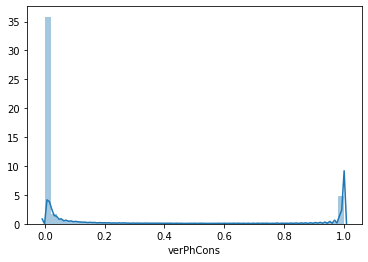

In [73]:
sns.distplot(nc['verPhCons'].dropna())

KeyError: 'PolyPhenCat'

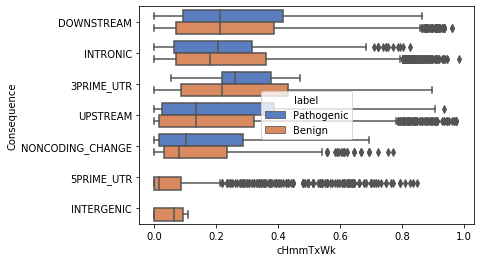

Check the first 10 PC's with tSNE.

<h1>How well does the current model predict for non-coding variants?</h1>

In [ ]:
#load test results -> subset on noncoding variants -> calculate ROC